In [2]:
import sys
sys.path.insert(0, '../')

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import interpolate
from scipy.signal import butter, sosfiltfilt, find_peaks
from utils import *
import os
from enum import Enum
import copy

%matplotlib inline
mpl.rcParams['lines.linewidth'] = 1
mpl.rcParams['font.family'] = 'arial'
mpl.rcParams['font.size'] = 14
np.set_printoptions(threshold=sys.maxsize,
                    suppress=True)

import torch
import torch.nn as nn
from torch.utils.data import random_split
from torch.utils.data import DataLoader, SubsetRandomSampler
from scipy import stats
from sklearn.model_selection import KFold

torch.manual_seed(199711)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(torch.__config__.show())
print(f'PyTorch is running on {device}')

PyTorch built with:
  - C++ Version: 199711
  - MSVC 193431937
  - Intel(R) Math Kernel Library Version 2020.0.2 Product Build 20200624 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.7.3 (Git Hash 6dbeffbae1f23cbbeae17adb7b5b13f1f37c080e)
  - OpenMP 2019
  - LAPACK is enabled (usually provided by MKL)
  - CPU capability usage: AVX2
  - CUDA Runtime 11.8
  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_37;-gencode;arch=compute_50,code=sm_50;-gencode;arch=compute_60,code=sm_60;-gencode;arch=compute_61,code=sm_61;-gencode;arch=compute_70,code=sm_70;-gencode;arch=compute_75,code=sm_75;-gencode;arch=compute_80,code=sm_80;-gencode;arch=compute_86,code=sm_86;-gencode;arch=compute_90,code=sm_90;-gencode;arch=compute_37,code=compute_37
  - CuDNN 8.7
  - Magma 2.5.4
  - Build settings: BLAS_INFO=mkl, BUILD_TYPE=Release, CUDA_VERSION=11.8, CUDNN_VERSION=8.7.0, CXX_COMPILER=C:/cb/pytorch_1000000000000/work/tmp_bin/sccache-cl.exe, CXX_FLAGS=/DWIN32 /D_WINDOWS /GR /EH

___
**PREPROCESSING**

In [3]:
directory = '../dataset/tano'
filenames = [filename for filename in os.listdir(directory) if filename.endswith('.csv')]
labels = [filename.split('.')[0] for filename in filenames]
labels

['deep_breath',
 'dry_cough',
 'jumping_jack',
 'push_up',
 'random',
 'swallowing',
 'throat_clearing']

In [4]:
class Label(Enum):
    DEEP_BREATH = 0
    DRY_COUGH = 1
    JUMPING_JACK = 2
    PUSH_UP = 3
    SWALLOWING = 4
    THROAT_CLEARING = 5

BREATH

deep_breath.csv
torch.Size([14, 1])
torch.Size([14, 7, 3000])


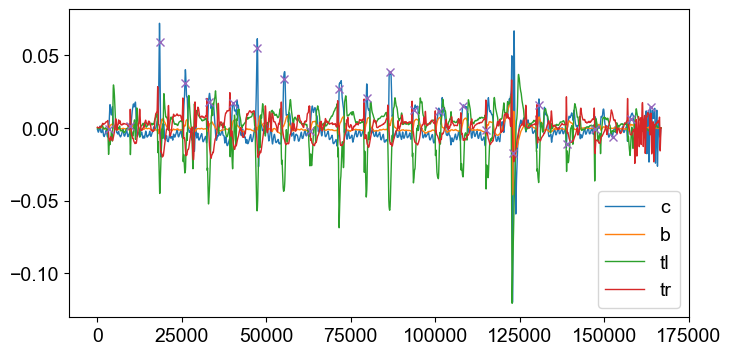

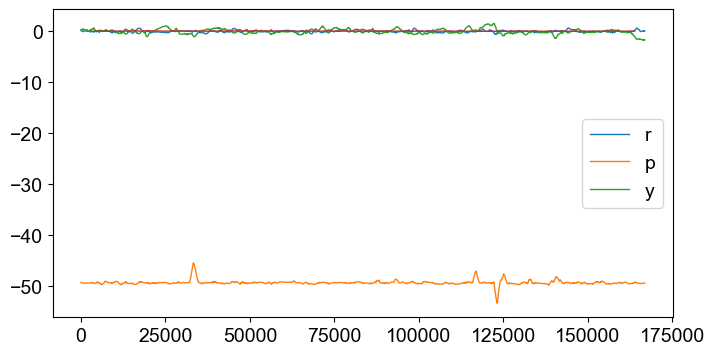

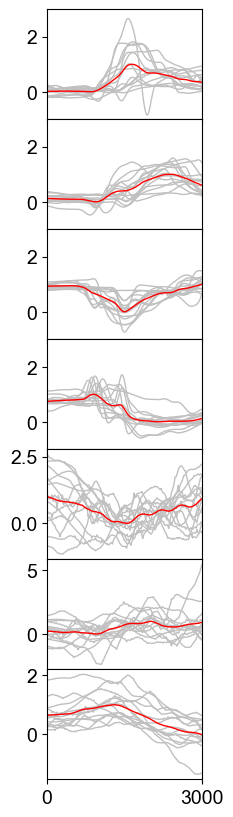

In [5]:
# deep breath
# Load
filename = filenames[0]
print(filename)
data_raw = pd.read_csv(os.path.join('..', 'dataset', 'tano', filename), delimiter=',', header=None)
timestamps, c, b, tl, tr, r, p, y = (data_raw[i].to_numpy() for i in range(data_raw.shape[1]))
timestamps -= timestamps[0]

# Preprocess
y = detrend(y, method='butter', fc=2)
r, p, y = despike(r, 10, 0.2), despike(p, 10, 0.2), despike(y, 10, 0.2)

# Upsample
data_combined = np.column_stack([c, b, tl, tr, r, p, y])
data = np.zeros((int(np.around((len(timestamps) + 1) * 100 + 1)), 7))
for i in range(data_combined.shape[1]):
    _, data[:, i] = upsample(timestamps, data_combined[:, i], ratio=100)
timestamps, _ = upsample(timestamps, timestamps, ratio=100) # Update timestamps with the upsampled version

# Butterworth
sos = butter(3, [0.1, 5], 'bandpass', output='sos', fs=1000) # for pvs
data[:, :4] = sosfiltfilt(sos, data[:, :4], axis=0)
sos = butter(2, [3, 7], 'bandstop', output='sos', fs=1000) # for angles
data[:, 4:] = sosfiltfilt(sos, data[:, 4:], axis=0)

# Find peaks
peaks, _ = find_peaks(-data[:, 2], distance=5000) # NOTE: Choose from seven channels to get the best result
plt.figure(figsize=(8, 4))
plt.plot(timestamps, data[:, :4])
plt.plot(peaks, data[peaks, 0], 'x')
plt.legend(['c', 'b', 'tl', 'tr'])

plt.figure(figsize=(8, 4))
plt.plot(timestamps, data[:, 4:])
plt.plot(peaks, data[peaks, 0])
plt.legend(['r', 'p', 'y'])

# Construct slices_0
window_width = 3000
expanded_peaks = peak_expand(peaks, window_width, len(timestamps))
slices_0 = []
for idx in range(expanded_peaks.shape[0]):
    slices_0.append(data[expanded_peaks[idx, :]])
slices_0 = np.array(slices_0)

# Create mask to filter outliers
# TODO: it should be easier to do the transpose -> (1, 0, 2) for all
mask = np.all(np.array([filter_windows(channel) for channel in np.transpose(slices_0,
                                                                            (1, 0, 2))]),
              axis=0)
slices_0 = slices_0[mask.astype(bool), :, :]
slices_0 = torch.tensor(np.transpose(slices_0, (0, 2, 1)))
labels_0 = torch.broadcast_to(torch.tensor(Label.DEEP_BREATH.value), (slices_0.shape[0], 1))
print(labels_0.shape)
print(slices_0.shape)

# Normalize after constructing slices using the average window as reference
slices_mean = torch.mean(slices_0, axis=0) # [n_ch, n_points]
slices_normalized = torch.zeros_like(slices_0)
slices_min = torch.zeros(slices_mean.shape[0])
amp_factors = torch.zeros(slices_mean.shape[0])
for ch in range(slices_mean.shape[0]):
    ch_max = torch.max(slices_mean[ch, :])
    ch_min = torch.min(slices_mean[ch, :])
    slices_min[ch] = ch_min
    amp_factors[ch] = 1 / (ch_max - ch_min)
for ch in range(slices_0.shape[1]):
    slices_normalized[:, ch, :] = (slices_0[:, ch, :] - slices_min[ch]) * amp_factors[ch]
slices_0 = slices_normalized

fig, axes = plt.subplots(nrows=7, ncols=1, figsize=(2, 10), sharex=True)
fig.subplots_adjust(hspace=0)
for ch, ax in enumerate(axes):
    for idx in range(slices_0.shape[0]):
        ax.plot(slices_0[idx, ch, :], 'silver')
    ax.plot((slices_mean[ch, :] - slices_min[ch]) * amp_factors[ch], 'r')
    ax.set_xlim(0, window_width)
    ax.set_xticks([0, window_width])
    if ch < 4:
        ax.set_ylim(-1, 3)
plt.show()

dry_cough.csv
torch.Size([18, 1])
torch.Size([18, 7, 3000])


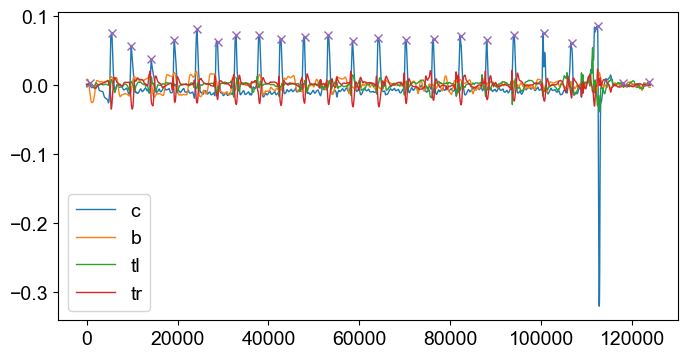

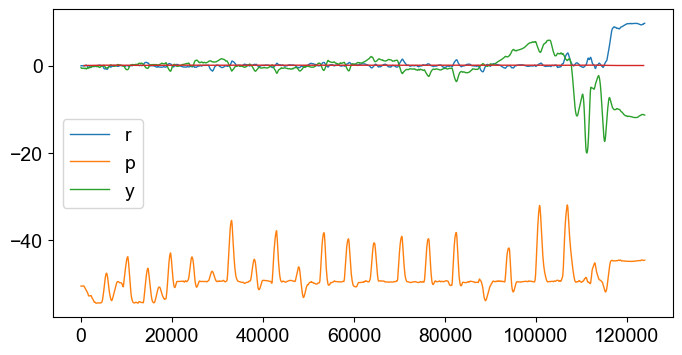

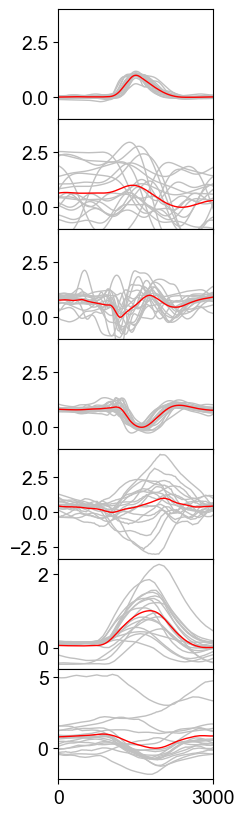

In [14]:
# dry cough
# Load
filename = filenames[1]
print(filename)
data_raw = pd.read_csv(os.path.join('..', 'dataset', 'tano', filename), delimiter=',', header=None)
timestamps, c, b, tl, tr, r, p, y = (data_raw[i].to_numpy() for i in range(data_raw.shape[1]))
timestamps -= timestamps[0]

# Preprocess
y = detrend(y, method='butter', fc=2)
r, p, y = despike(r, 10, 0.2), despike(p, 10, 0.2), despike(y, 10, 0.2)

# Upsample
data_combined = np.column_stack([c, b, tl, tr, r, p, y])
data = np.zeros((int(np.around((len(timestamps) + 1) * 100 + 1)), 7))
for i in range(data_combined.shape[1]):
    _, data[:, i] = upsample(timestamps, data_combined[:, i], ratio=100)
timestamps, _ = upsample(timestamps, timestamps, ratio=100) # Update timestamps with the upsampled version

# Butterworth
sos = butter(2, [0.1, 5], 'bandpass', output='sos', fs=1000) # for pvs
data[:, :4] = sosfiltfilt(sos, data[:, :4], axis=0)
sos = butter(3, 1, 'lowpass', output='sos', fs=1000)
data[:, 1] = sosfiltfilt(sos, data[:, 1], axis=0)

sos = butter(2, [3, 7], 'bandstop', output='sos', fs=1000) # for angles
data[:, 4:] = sosfiltfilt(sos, data[:, 4:], axis=0)

# Find peaks
peaks, _ = find_peaks(data[:, 0], distance=4000)
plt.figure(figsize=(8, 4))
plt.plot(timestamps, data[:, :4])
plt.plot(peaks, data[peaks, 0], 'x')
plt.legend(['c', 'b', 'tl', 'tr'])

plt.figure(figsize=(8, 4))
plt.plot(timestamps, data[:, 4:])
plt.plot(peaks, data[peaks, 0])
plt.legend(['r', 'p', 'y'])

# Construct slices
window_width = 3000
expanded_peaks = peak_expand(peaks, window_width, len(timestamps))
slices_1 = []
for idx in range(expanded_peaks.shape[0]):
    slices_1.append(data[expanded_peaks[idx, :]])
slices_1 = np.array(slices_1)

# Create mask to filter outliers
# TODO: it should be easier to do the transpose -> (1, 0, 2) for all
mask = np.all(np.array([filter_windows(channel) for channel in np.transpose(slices_1,
                                                                            (1, 0, 2))]),
              axis=0)
slices_1 = slices_1[mask.astype(bool), :, :]
slices_1 = torch.tensor(np.transpose(slices_1, (0, 2, 1)))
labels_1 = torch.broadcast_to(torch.tensor(Label.DRY_COUGH.value), (slices_1.shape[0], 1))
print(labels_1.shape)
print(slices_1.shape)

# Normalize after constructing slices using the average window as reference
slices_mean = torch.mean(slices_1, axis=0) # [n_ch, n_points]
slices_normalized = torch.zeros_like(slices_1)
slices_min = torch.zeros(slices_mean.shape[0])
amp_factors = torch.zeros(slices_mean.shape[0])
for ch in range(slices_mean.shape[0]):
    ch_max = torch.max(slices_mean[ch, :])
    ch_min = torch.min(slices_mean[ch, :])
    slices_min[ch] = ch_min
    amp_factors[ch] = 1 / (ch_max - ch_min)
for ch in range(slices_1.shape[1]):
    slices_normalized[:, ch, :] = (slices_1[:, ch, :] - slices_min[ch]) * amp_factors[ch]
slices_1 = slices_normalized

fig, axes = plt.subplots(nrows=7, ncols=1, figsize=(2, 10), sharex=True)
fig.subplots_adjust(hspace=0)
for ch, ax in enumerate(axes):
    for idx in range(slices_1.shape[0]):
        ax.plot(slices_1[idx, ch, :], 'silver')
    ax.plot((slices_mean[ch, :] - slices_min[ch]) * amp_factors[ch], 'r')
    ax.set_xlim(0, window_width)
    ax.set_xticks([0, window_width])
    if ch < 4:
        ax.set_ylim(-1, 4)
plt.show()

dry_cough.csv


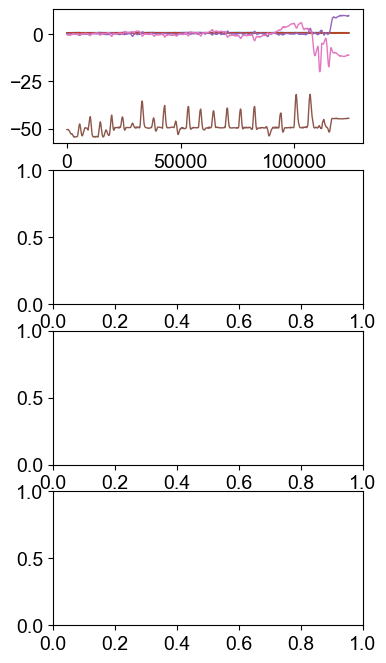

In [18]:
# dry cough

fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(4, 8))

# Load
filename = filenames[1]
print(filename)
data_raw = pd.read_csv(os.path.join('..', 'dataset', 'tano', filename), delimiter=',', header=None)
timestamps, c, b, tl, tr, r, p, y = (data_raw[i].to_numpy() for i in range(data_raw.shape[1]))
timestamps -= timestamps[0]

# Preprocess
y = detrend(y, method='butter', fc=2)
r, p, y = despike(r, 10, 0.2), despike(p, 10, 0.2), despike(y, 10, 0.2)

# Upsample
data_combined = np.column_stack([c, b, tl, tr, r, p, y])
data = np.zeros((int(np.around((len(timestamps) + 1) * 100 + 1)), 7))
for i in range(data_combined.shape[1]):
    _, data[:, i] = upsample(timestamps, data_combined[:, i], ratio=100)
timestamps, _ = upsample(timestamps, timestamps, ratio=100) # Update timestamps with the upsampled version

axes[0].plot(timestamps, data)

# Butterworth
sos = butter(2, [0.1, 5], 'bandpass', output='sos', fs=1000) # for pvs
data[:, :4] = sosfiltfilt(sos, data[:, :4], axis=0)
sos = butter(3, 1, 'lowpass', output='sos', fs=1000)
data[:, 1] = sosfiltfilt(sos, data[:, 1], axis=0)

sos = butter(2, [3, 7], 'bandstop', output='sos', fs=1000) # for angles
data[:, 4:] = sosfiltfilt(sos, data[:, 4:], axis=0)

# Find peaks
peaks, _ = find_peaks(data[:, 0], distance=4000)


# plt.plot(timestamps, data[:, :4])
# plt.plot(peaks, data[peaks, 0], 'x')
# plt.xlim(0, 100000)
# plt.xticks(np.arange(0, 120000, 20000), labels=np.arange(0, 120, 20))
# plt.ylim(-0.1, 0.1)

jumping_jack.csv
torch.Size([13, 1])
torch.Size([13, 7, 3000])


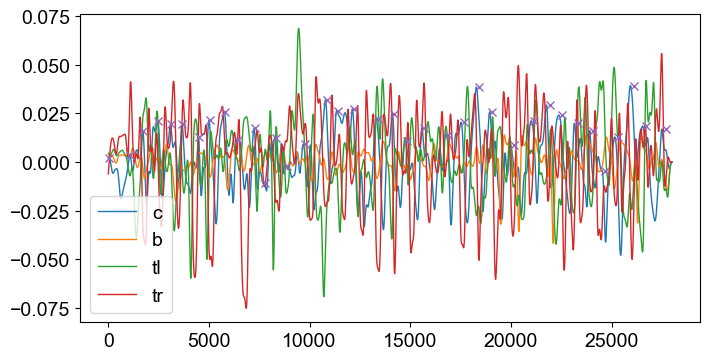

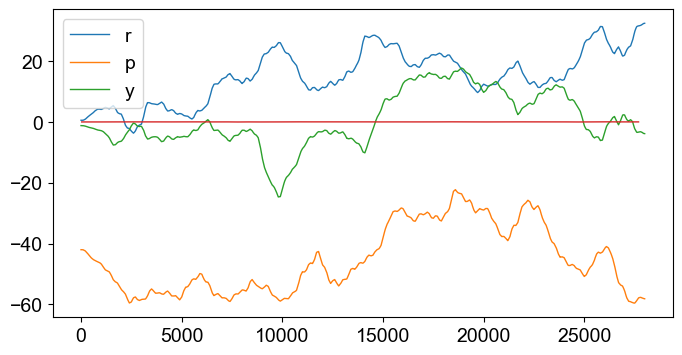

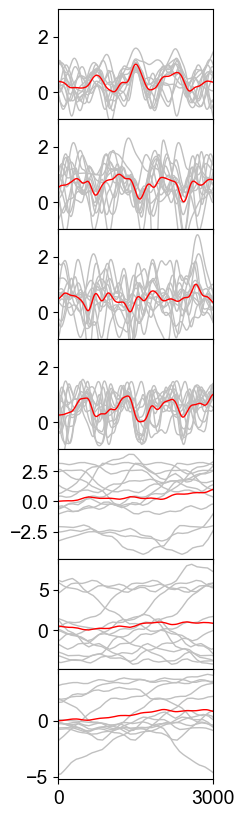

In [6]:
# jumping_jack
# Load
filename = filenames[2]
print(filename)
data_raw = pd.read_csv(os.path.join('..', 'dataset', 'tano', filename), delimiter=',', header=None)
data_raw = data_raw.truncate(after=280)
timestamps, c, b, tl, tr, ch, p, y = (data_raw[i].to_numpy() for i in range(data_raw.shape[1]))
timestamps -= timestamps[0]

# Preprocess
y = detrend(y, method='butter', fc=2)
ch, p, y = despike(ch, 10, 0.2), despike(p, 10, 0.2), despike(y, 10, 0.2)

# Upsample
data_combined = np.column_stack([c, b, tl, tr, ch, p, y])
data = np.zeros((int(np.around((len(timestamps) + 1) * 100 + 1)), 7))
for i in range(data_combined.shape[1]):
    _, data[:, i] = upsample(timestamps, data_combined[:, i], ratio=100)
timestamps, _ = upsample(timestamps, timestamps, ratio=100) # Update timestamps with the upsampled version

# Butterworth
sos = butter(3, [0.1, 5], 'bandpass', output='sos', fs=1000) # for pvs
data[:, :4] = sosfiltfilt(sos, data[:, :4], axis=0)
sos = butter(2, [3, 7], 'bandstop', output='sos', fs=1000) # for angles
data[:, 4:] = sosfiltfilt(sos, data[:, 4:], axis=0)

# Find peaks
peaks, _ = find_peaks(data[:, 0], distance=500)
plt.figure(figsize=(8, 4))
plt.plot(timestamps, data[:, :4])
plt.plot(peaks, data[peaks, 0], 'x')
plt.legend(['c', 'b', 'tl', 'tr'])

plt.figure(figsize=(8, 4))
plt.plot(timestamps, data[:, 4:])
plt.plot(peaks, data[peaks, 0])
plt.legend(['r', 'p', 'y'])

# Construct slices_0
window_width = 3000
expanded_peaks = peak_expand(peaks, window_width, len(timestamps))
slices_2 = []
for idx in range(expanded_peaks.shape[0]):
    slices_2.append(data[expanded_peaks[idx, :]])
slices_2 = np.array(slices_2)

# Create mask to filter outliers
mask = np.all(np.array([filter_windows(channel) for channel in np.transpose(slices_2,
                                                                            (1, 0, 2))]),
              axis=0)
slices_2 = slices_2[mask.astype(bool), :, :]
slices_2 = torch.tensor(np.transpose(slices_2, (0, 2, 1)))
labels_2 = torch.broadcast_to(torch.tensor(Label.JUMPING_JACK.value), (slices_2.shape[0], 1))
print(labels_2.shape)
print(slices_2.shape)

# Normalize after constructing slices using the average window as reference
slices_mean = torch.mean(slices_2, axis=0) # [n_ch, n_points]
slices_normalized = torch.zeros_like(slices_2)
slices_min = torch.zeros(slices_mean.shape[0])
amp_factors = torch.zeros(slices_mean.shape[0])
for ch in range(slices_mean.shape[0]):
    ch_max = torch.max(slices_mean[ch, :])
    ch_min = torch.min(slices_mean[ch, :])
    slices_min[ch] = ch_min
    amp_factors[ch] = 1 / (ch_max - ch_min)
for ch in range(slices_2.shape[1]):
    slices_normalized[:, ch, :] = (slices_2[:, ch, :] - slices_min[ch]) * amp_factors[ch]
slices_2 = slices_normalized

fig, axes = plt.subplots(nrows=7, ncols=1, figsize=(2, 10), sharex=True)
fig.subplots_adjust(hspace=0)
for ch, ax in enumerate(axes):
    for idx in range(slices_2.shape[0]):
        ax.plot(slices_2[idx, ch, :], 'silver')
    ax.plot((slices_mean[ch, :] - slices_min[ch]) * amp_factors[ch], 'r')
    ax.set_xlim(0, window_width)
    ax.set_xticks([0, window_width])
    if ch < 4:
        ax.set_ylim(-1, 3)
plt.show()

swallowing.csv
torch.Size([14, 1])
torch.Size([14, 7, 3000])


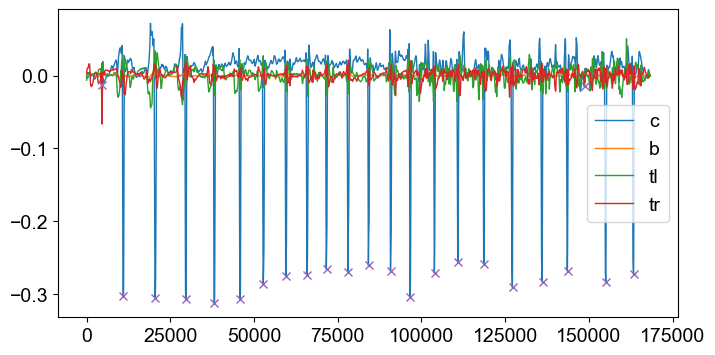

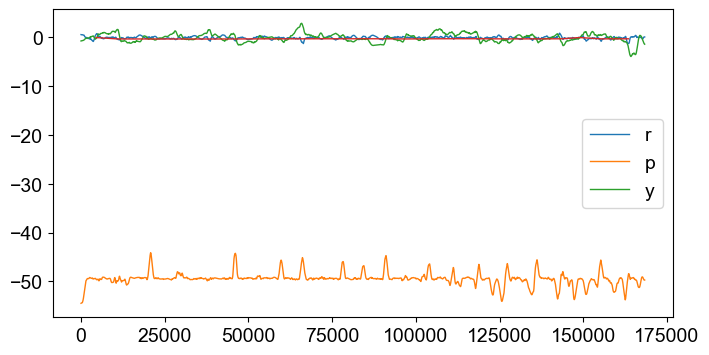

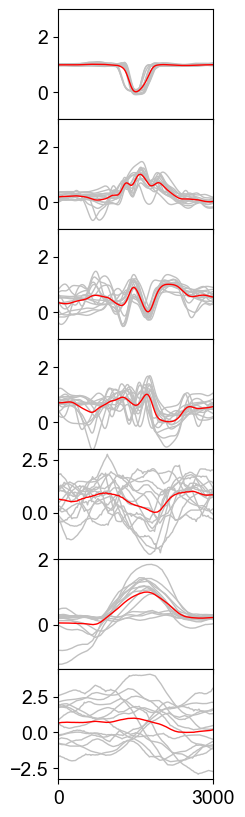

In [7]:
# swallowing
# Load
filename = filenames[5]
print(filename)
data_raw = pd.read_csv(os.path.join('..', 'dataset', 'tano', filename), delimiter=',', header=None)
timestamps, c, b, tl, tr, ch, p, y = (data_raw[i].to_numpy() for i in range(data_raw.shape[1]))
timestamps -= timestamps[0]

# Preprocess
y = detrend(y, method='butter', fc=2)
ch, p, y = despike(ch, 10, 0.2), despike(p, 10, 0.2), despike(y, 10, 0.2)

# Upsample
data_combined = np.column_stack([c, b, tl, tr, ch, p, y])
data = np.zeros((int(np.around((len(timestamps) + 1) * 100 + 1)), 7))
for i in range(data_combined.shape[1]):
    _, data[:, i] = upsample(timestamps, data_combined[:, i], ratio=100)
timestamps, _ = upsample(timestamps, timestamps, ratio=100) # Update timestamps with the upsampled version

# Butterworth
sos = butter(3, [0.1, 5], 'bandpass', output='sos', fs=1000) # for pvs
data[:, :4] = sosfiltfilt(sos, data[:, :4], axis=0)
sos = butter(2, [3, 7], 'bandstop', output='sos', fs=1000) # for angles
data[:, 4:] = sosfiltfilt(sos, data[:, 4:], axis=0)

# Find peaks
peaks, _ = find_peaks(-data[:, 0], distance=5000)
plt.figure(figsize=(8, 4))
plt.plot(timestamps, data[:, :4])
plt.plot(peaks, data[peaks, 0], 'x')
plt.legend(['c', 'b', 'tl', 'tr'])

plt.figure(figsize=(8, 4))
plt.plot(timestamps, data[:, 4:])
plt.plot(peaks, data[peaks, 0])
plt.legend(['r', 'p', 'y'])

# Construct slices_3
window_width = 3000
expanded_peaks = peak_expand(peaks, window_width, len(timestamps))

slices_3 = []
for idx in range(expanded_peaks.shape[0]):
    slices_3.append(data[expanded_peaks[idx, :]])
slices_3 = np.array(slices_3)
mask = np.all(np.array([filter_windows(channel) for channel in np.transpose(slices_3,
                                                                            (1, 0, 2))]),
              axis=0)
slices_3 = slices_3[mask.astype(bool), :, :]
slices_3 = torch.tensor(np.transpose(slices_3, (0, 2, 1)))
labels_3 = torch.broadcast_to(torch.tensor(Label.SWALLOWING.value), (slices_3.shape[0], 1))
print(labels_3.shape)
print(slices_3.shape)

# Normalize after constructing slices using the average window as reference
slices_mean = torch.mean(slices_3, axis=0) # [n_ch, n_points]
slices_normalized = torch.zeros_like(slices_3)
slices_min = torch.zeros(slices_mean.shape[0])
amp_factors = torch.zeros(slices_mean.shape[0])
for ch in range(slices_mean.shape[0]):
    ch_max = torch.max(slices_mean[ch, :])
    ch_min = torch.min(slices_mean[ch, :])
    slices_min[ch] = ch_min
    amp_factors[ch] = 1 / (ch_max - ch_min)
for ch in range(slices_3.shape[1]):
    slices_normalized[:, ch, :] = (slices_3[:, ch, :] - slices_min[ch]) * amp_factors[ch]
slices_3 = slices_normalized

fig, axes = plt.subplots(nrows=7, ncols=1, figsize=(2, 10), sharex=True)
fig.subplots_adjust(hspace=0)
for ch, ax in enumerate(axes):
    for idx in range(slices_3.shape[0]):
        ax.plot(slices_3[idx, ch, :], 'silver')
    ax.plot((slices_mean[ch, :] - slices_min[ch]) * amp_factors[ch], 'r')
    ax.set_xlim(0, window_width)
    ax.set_xticks([0, window_width])
    if ch < 4:
        ax.set_ylim(-1, 3)
plt.show()

push_up.csv
torch.Size([24, 1])
torch.Size([24, 7, 3000])


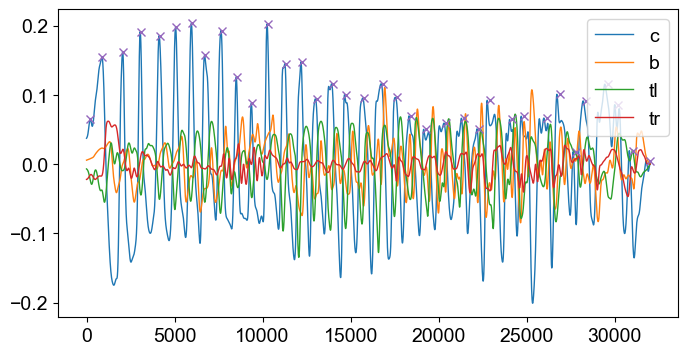

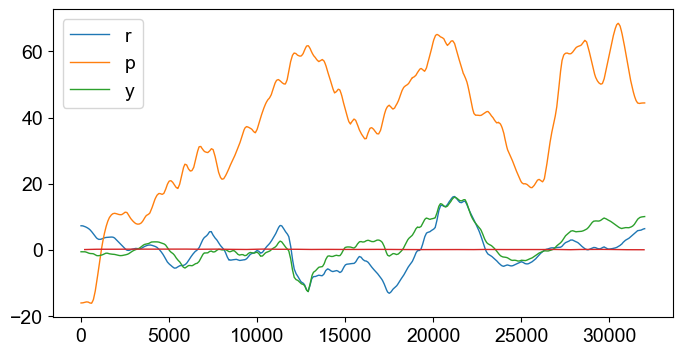

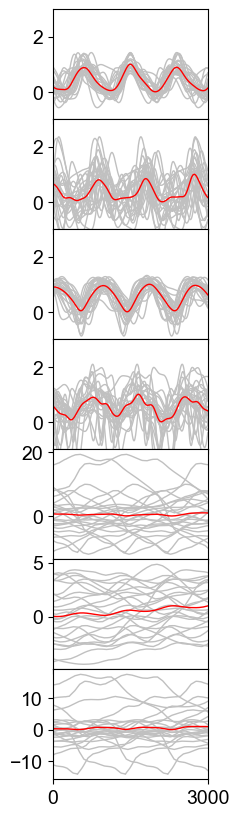

In [8]:
# push up
# Load
filename = filenames[3]
print(filename)
data_raw = pd.read_csv(os.path.join('..', 'dataset', 'tano', filename), delimiter=',', header=None)
data_raw = data_raw.truncate(after=320)
timestamps, c, b, tl, tr, ch, p, y = (data_raw[i].to_numpy() for i in range(data_raw.shape[1]))
timestamps -= timestamps[0]

# Preprocess
y = detrend(y, method='butter', fc=2)
ch, p, y = despike(ch, 10, 0.2), despike(p, 10, 0.2), despike(y, 10, 0.2)

# Upsample
data_combined = np.column_stack([c, b, tl, tr, ch, p, y])
data = np.zeros((int(np.around((len(timestamps) + 1) * 100 + 1)), 7))
for i in range(data_combined.shape[1]):
    _, data[:, i] = upsample(timestamps, data_combined[:, i], ratio=100)
timestamps, _ = upsample(timestamps, timestamps, ratio=100) # Update timestamps with the upsampled version

# Butterworth
sos = butter(3, [0.1, 5], 'bandpass', output='sos', fs=1000) # for pvs
data[:, :4] = sosfiltfilt(sos, data[:, :4], axis=0)
sos = butter(2, [3, 7], 'bandstop', output='sos', fs=1000) # for angles
data[:, 4:] = sosfiltfilt(sos, data[:, 4:], axis=0)

# Find peaks
peaks, _ = find_peaks(data[:, 0], distance=500)
plt.figure(figsize=(8, 4))
plt.plot(timestamps, data[:, :4])
plt.plot(peaks, data[peaks, 0], 'x')
plt.legend(['c', 'b', 'tl', 'tr'])

plt.figure(figsize=(8, 4))
plt.plot(timestamps, data[:, 4:])
plt.plot(peaks, data[peaks, 0])
plt.legend(['r', 'p', 'y'])

# Construct slices_4
window_width = 3000
expanded_peaks = peak_expand(peaks, window_width, len(timestamps))

slices_4 = []
for idx in range(expanded_peaks.shape[0]):
    slices_4.append(data[expanded_peaks[idx, :]])
slices_4 = np.array(slices_4)
mask = np.all(np.array([filter_windows(channel) for channel in np.transpose(slices_4,
                                                                            (1, 0, 2))]),
              axis=0)
slices_4 = slices_4[mask.astype(bool), :, :]
slices_4 = torch.tensor(np.transpose(slices_4, (0, 2, 1)))
labels_4 = torch.broadcast_to(torch.tensor(Label.PUSH_UP.value), (slices_4.shape[0], 1))
print(labels_4.shape)
print(slices_4.shape)

# Normalize after constructing slices using the average window as reference
slices_mean = torch.mean(slices_4, axis=0) # [n_ch, n_points]
slices_normalized = torch.zeros_like(slices_4)
slices_min = torch.zeros(slices_mean.shape[0])
amp_factors = torch.zeros(slices_mean.shape[0])
for ch in range(slices_mean.shape[0]):
    ch_max = torch.max(slices_mean[ch, :])
    ch_min = torch.min(slices_mean[ch, :])
    slices_min[ch] = ch_min
    amp_factors[ch] = 1 / (ch_max - ch_min)
for ch in range(slices_4.shape[1]):
    slices_normalized[:, ch, :] = (slices_4[:, ch, :] - slices_min[ch]) * amp_factors[ch]
slices_4 = slices_normalized

fig, axes = plt.subplots(nrows=7, ncols=1, figsize=(2, 10), sharex=True)
fig.subplots_adjust(hspace=0)
for ch, ax in enumerate(axes):
    for idx in range(slices_4.shape[0]):
        ax.plot(slices_4[idx, ch, :], 'silver')
    ax.plot((slices_mean[ch, :] - slices_min[ch]) * amp_factors[ch], 'r')
    ax.set_xlim(0, window_width)
    ax.set_xticks([0, window_width])
    if ch < 4:
        ax.set_ylim(-1, 3)
plt.show()

throat_clearing.csv
torch.Size([17, 1])
torch.Size([17, 7, 3000])


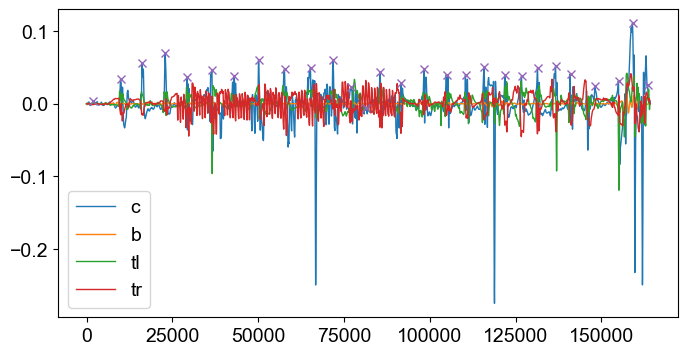

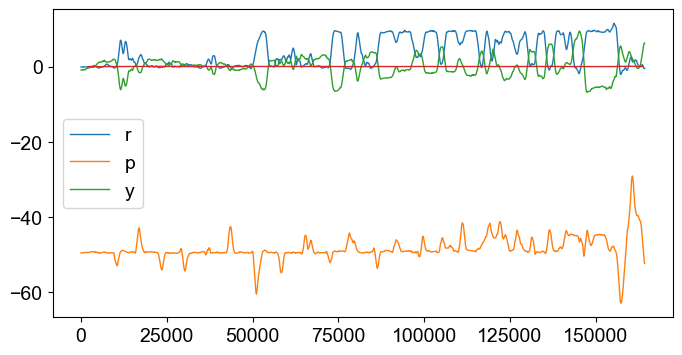

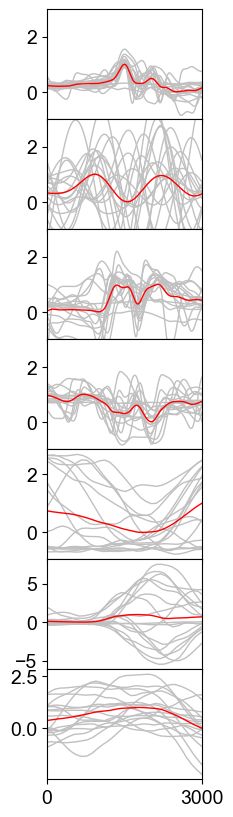

In [9]:
# throat clearing
# Load
filename = filenames[6]
print(filename)
data_raw = pd.read_csv(os.path.join('..', 'dataset', 'tano', filename), delimiter=',', header=None)
timestamps, c, b, tl, tr, ch, p, y = (data_raw[i].to_numpy() for i in range(data_raw.shape[1]))
timestamps -= timestamps[0]

# Preprocess
y = detrend(y, method='butter', fc=2)
ch, p, y = despike(ch, 10, 0.2), despike(p, 10, 0.2), despike(y, 10, 0.2)

# Upsample
data_combined = np.column_stack([c, b, tl, tr, ch, p, y])
data = np.zeros((int(np.around((len(timestamps) + 1) * 100 + 1)), 7))
for i in range(data_combined.shape[1]):
    _, data[:, i] = upsample(timestamps, data_combined[:, i], ratio=100)
timestamps, _ = upsample(timestamps, timestamps, ratio=100) # Update timestamps with the upsampled version

# Butterworth
sos = butter(3, [0.1, 5], 'bandpass', output='sos', fs=1000) # for pvs
data[:, :4] = sosfiltfilt(sos, data[:, :4], axis=0)
sos = butter(3, [0.5, 1], 'bandpass', output='sos', fs=1000)
data[:, 1] = sosfiltfilt(sos, data[:, 1], axis=0)

sos = butter(2, [3, 7], 'bandstop', output='sos', fs=1000) # for angles
data[:, 4:] = sosfiltfilt(sos, data[:, 4:], axis=0)

# Find peaks
peaks, _ = find_peaks(data[:, 0], distance=4000)
plt.figure(figsize=(8, 4))
plt.plot(timestamps, data[:, :4])
plt.plot(peaks, data[peaks, 0], 'x')
plt.legend(['c', 'b', 'tl', 'tr'])

plt.figure(figsize=(8, 4))
plt.plot(timestamps, data[:, 4:])
plt.plot(peaks, data[peaks, 0])
plt.legend(['r', 'p', 'y'])


# Construct slices_5
window_width = 3000
expanded_peaks = peak_expand(peaks, window_width, len(timestamps))

slices_5 = []
for idx in range(expanded_peaks.shape[0]):
    slices_5.append(data[expanded_peaks[idx, :]])
slices_5 = np.array(slices_5)
mask = np.all(np.array([filter_windows(channel) for channel in np.transpose(slices_5,
                                                                            (1, 0, 2))]),
              axis=0)
slices_5 = slices_5[mask.astype(bool), :, :]
slices_5 = torch.tensor(np.transpose(slices_5, (0, 2, 1)))
labels_5 = torch.broadcast_to(torch.tensor(Label.THROAT_CLEARING.value), (slices_5.shape[0], 1))
print(labels_5.shape)
print(slices_5.shape)

# Normalize after constructing slices using the average window as reference
slices_mean = torch.mean(slices_5, axis=0) # [n_ch, n_points]
slices_normalized = torch.zeros_like(slices_5)
slices_min = torch.zeros(slices_mean.shape[0])
amp_factors = torch.zeros(slices_mean.shape[0])
for ch in range(slices_mean.shape[0]):
    ch_max = torch.max(slices_mean[ch, :])
    ch_min = torch.min(slices_mean[ch, :])
    slices_min[ch] = ch_min
    amp_factors[ch] = 1 / (ch_max - ch_min)
for ch in range(slices_5.shape[1]):
    slices_normalized[:, ch, :] = (slices_5[:, ch, :] - slices_min[ch]) * amp_factors[ch]
slices_5 = slices_normalized

fig, axes = plt.subplots(nrows=7, ncols=1, figsize=(2, 10), sharex=True)
fig.subplots_adjust(hspace=0)
for ch, ax in enumerate(axes):
    for idx in range(slices_5.shape[0]):
        ax.plot(slices_5[idx, ch, :], 'silver')
    ax.plot((slices_mean[ch, :] - slices_min[ch]) * amp_factors[ch], 'r')
    ax.set_xlim(0, window_width)
    ax.set_xticks([0, window_width])
    if ch < 4:
        ax.set_ylim(-1, 3)
plt.show()

___
**Data plotting**

In [10]:
all_slices = torch.cat((slices_0, slices_1, slices_2, slices_3, slices_4, slices_5), dim=0)
all_labels = torch.cat((labels_0, labels_1, labels_2, labels_3, labels_4, labels_5), dim=0)
print(all_slices.shape)
print(all_labels.shape)

torch.Size([100, 7, 3000])
torch.Size([100, 1])


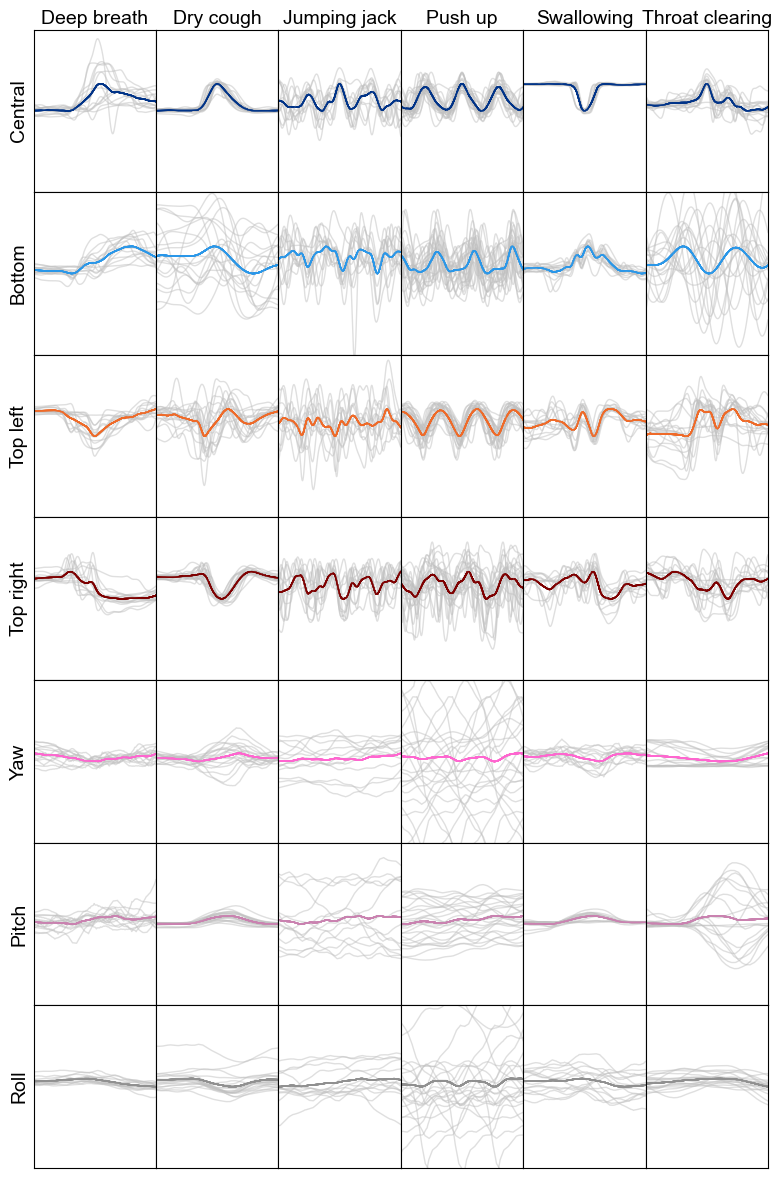

In [11]:
sensors = ['Central',
           'Bottom',
           'Top left',
           'Top right',
           'Yaw',
           'Pitch',
           'Roll']

labels = ['Deep breath',
          'Dry cough',
          'Jumping jack',
          'Push up',
          'Swallowing',
          'Throat clearing']

pv_color = ['#003388', '#2a97e9', '#f06a28', '#7e0000']
or_color = ['#ff66d0', '#ca82b0', '#909090']
colors = pv_color + or_color

fig, axes = plt.subplots(nrows=7, ncols=6, figsize=(8, 12))

# Number of classes
n_channels = all_slices.shape[1]
n_classes = 6

# Iterate over each channel
for channel in range(n_channels):
    for class_code in range(n_classes):
        ax = axes[channel, class_code]
        class_samples = all_slices[all_labels.squeeze() == class_code]
        mean_data = class_samples.mean(dim=0)[channel]
        for sample in class_samples:
            ax.plot(sample[channel], alpha=0.5, color='silver')
            ax.plot(mean_data, color=colors[channel])

        if channel < 4:
            ax.set_ylim(-3, 3)
            ax.set_yticks([])
        else:
            ax.set_ylim(-10, 10)
            ax.set_yticks([])

        if class_code != 0:
            ax.set_yticks([])
        else:
            ax.set_ylabel(sensors[channel])

        if channel == 0:
            ax.set_xlabel(labels[class_code])
            ax.xaxis.set_label_position('top') 

        ax.set_xlim(0, 3000)
        ax.set_xticks([])
        
plt.tight_layout()
fig.subplots_adjust(wspace=0, hspace=0)

plt.savefig('../results/fig2/preprocessed/all.png', bbox_inches='tight', dpi=600)
plt.show()

___
**Dataset forming**

In [26]:
all_slices = torch.cat((slices_0, slices_1, slices_2, slices_3, slices_4, slices_5), dim=0)
all_labels = torch.cat((labels_0, labels_1, labels_2, labels_3, labels_4, labels_5), dim=0)
print(all_slices.shape)
print(all_labels.shape)

torch.Size([99, 7, 3000])
torch.Size([99, 1])


In [27]:
class BaseLHMDataset(torch.utils.data.Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return self.features.shape[0]

class LHMPVBiasedDataset(BaseLHMDataset):
    def __getitem__(self, idx):
        return self.features[idx, :4, :].transpose(0, 1).float(), self.labels[idx]

class LHMIMUBiasedDataset(BaseLHMDataset):
    def __getitem__(self, idx):
        return self.features[idx, 4:, :].transpose(0, 1).float(), self.labels[idx]

class LHMMonoDataset(BaseLHMDataset):
    def __getitem__(self, idx):
        return self.features[idx, ...].transpose(0, 1).float(), self.labels[idx]

class LHMDualDataset(BaseLHMDataset):
    def __getitem__(self, idx):
        photovoltage_data = self.features[idx, :4, :].float().transpose(0, 1)  # First 4 channels
        euler_angle_data = self.features[idx, 4:, :].float().transpose(0, 1)  # Last 3 channels
        return photovoltage_data, euler_angle_data, self.labels[idx]

In [28]:
pv_biased_ds = LHMPVBiasedDataset(all_slices, all_labels)
torch.save(pv_biased_ds, '../dataset/preprocessed/pv_biased.pt')

imu_biased_ds = LHMIMUBiasedDataset(all_slices, all_labels)
torch.save(imu_biased_ds, '../dataset/preprocessed/imu_biased.pt')

mono_ds = LHMMonoDataset(all_slices, all_labels)
torch.save(mono_ds, '../dataset/preprocessed/mono.pt')

dual_ds = LHMDualDataset(all_slices, all_labels)
torch.save(dual_ds, '../dataset/preprocessed/dual.pt')

___
**Training**

In [29]:
pv_biased_ds = torch.load('../dataset/preprocessed/pv_biased.pt')
imu_biased_ds = torch.load('../dataset/preprocessed/imu_biased.pt')
mono_ds = torch.load('../dataset/preprocessed/mono.pt')
dual_ds = torch.load('../dataset/preprocessed/dual.pt')

print(dual_ds.features.shape)
print(dual_ds.labels.shape)

torch.Size([99, 7, 3000])
torch.Size([99, 1])


RNN model definitions

In [121]:
class BaseRNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(BaseRNNModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        self.rnn = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        num_directions = 2 if self.rnn.bidirectional else 1
        # Initialize hidden state and cell state
        h0 = torch.zeros(self.layer_dim * num_directions, x.size(0), self.hidden_dim).requires_grad_().to(device)
        c0 = torch.zeros(self.layer_dim * num_directions, x.size(0), self.hidden_dim).requires_grad_().to(device)
        out, (hn, cn) = self.rnn(x, (h0.detach(), c0.detach())) # hn, cn are here as placeholder
        out = self.fc(out[:, -1, :])
        out = self.softmax(out)
        return out
    
class PVBiasedRNNModel(BaseRNNModel):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(PVBiasedRNNModel, self).__init__(4, hidden_dim, layer_dim, output_dim)

class PVBiasedBiRNNModel(BaseRNNModel):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(PVBiasedBiRNNModel, self).__init__(4, hidden_dim, layer_dim, output_dim)
        self.rnn = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)

class IMUBiasedRNNModel(BaseRNNModel):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(IMUBiasedRNNModel, self).__init__(3, hidden_dim, layer_dim, output_dim)

class IMUBiasedBiRNNModel(BaseRNNModel):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(IMUBiasedBiRNNModel, self).__init__(3, hidden_dim, layer_dim, output_dim)
        self.rnn = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)

class MonoRNNModel(BaseRNNModel):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(MonoRNNModel, self).__init__(7, hidden_dim, layer_dim, output_dim)

class MonoBiRNNModel(BaseRNNModel):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(MonoBiRNNModel, self).__init__(7, hidden_dim, layer_dim, output_dim)
        self.rnn = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)

class DualRNNModel(nn.Module):
    def __init__(self, input_dim1, input_dim2, hidden_dim, layer_dim, output_dim, dropout_prob):
        super(DualRNNModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        # RNN layers
        self.rnn1 = nn.RNN(input_dim1, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob)
        self.rnn2 = nn.RNN(input_dim2, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob)

        # Fully connected layer
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x1, x2):
        # Initialize hidden states for both RNNs
        h01 = torch.zeros(self.layer_dim, x1.size(0), self.hidden_dim).requires_grad_().to(device)
        h02 = torch.zeros(self.layer_dim, x2.size(0), self.hidden_dim).requires_grad_().to(device)

        out1, _ = self.rnn1(x1, h01.detach())
        out2, _ = self.rnn2(x2, h02.detach())

        # Concatenate the outputs from both RNNs
        out = torch.cat((out1[:, -1, :], out2[:, -1, :]), 1)

        out = self.fc(out)
        out = self.softmax(out)
        return out
    
class DualBiRNNModel(nn.Module):
    def __init__(self, input_dim1, input_dim2, hidden_dim, layer_dim, output_dim, dropout_prob):
        super(DualBiRNNModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.dropout_prob = dropout_prob

        self.rnn1 = nn.RNN(input_dim1, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob, bidirectional=True)
        self.rnn2 = nn.RNN(input_dim2, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x1, x2):
        # Initialize hidden states and cell states for both LSTMs
        h01 = torch.zeros(self.layer_dim * 2, x1.size(0), self.hidden_dim).requires_grad_().to(device)
        c01 = torch.zeros(self.layer_dim * 2, x1.size(0), self.hidden_dim).requires_grad_().to(device)

        h02 = torch.zeros(self.layer_dim * 2, x2.size(0), self.hidden_dim).requires_grad_().to(device)
        c02 = torch.zeros(self.layer_dim * 2, x2.size(0), self.hidden_dim).requires_grad_().to(device)

        out1, _ = self.rnn1(x1, (h01.detach(), c01.detach()))
        out2, _ = self.rnn2(x2, (h02.detach(), c02.detach()))

        # Concatenate the outputs from both LSTMs
        out = torch.cat((out1[:, -1, :], out2[:, -1, :]), 1)

        out = self.fc(out)
        out = self.softmax(out)
        return out

LSTM model definitions

In [30]:
class BaseLSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(BaseLSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        num_directions = 2 if self.lstm.bidirectional else 1
        # Initialize hidden state and cell state
        h0 = torch.zeros(self.layer_dim * num_directions, x.size(0), self.hidden_dim).requires_grad_().to(device)
        c0 = torch.zeros(self.layer_dim * num_directions, x.size(0), self.hidden_dim).requires_grad_().to(device)
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach())) # hn, cn are here as placeholder
        out = self.fc(out[:, -1, :])
        out = self.softmax(out)
        return out

class PVBiasedLSTMModel(BaseLSTMModel):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(PVBiasedLSTMModel, self).__init__(4, hidden_dim, layer_dim, output_dim)

class PVBiasedBiLSTMModel(BaseLSTMModel):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(PVBiasedBiLSTMModel, self).__init__(4, hidden_dim, layer_dim, output_dim)
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)

class IMUBiasedLSTMModel(BaseLSTMModel):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(IMUBiasedLSTMModel, self).__init__(3, hidden_dim, layer_dim, output_dim)

class IMUBiasedBiLSTMModel(BaseLSTMModel):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(IMUBiasedBiLSTMModel, self).__init__(3, hidden_dim, layer_dim, output_dim)
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)

class MonoLSTMModel(BaseLSTMModel):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(MonoLSTMModel, self).__init__(7, hidden_dim, layer_dim, output_dim)

class MonoBiLSTMModel(BaseLSTMModel):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(MonoBiLSTMModel, self).__init__(7, hidden_dim, layer_dim, output_dim)
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)

class DualLSTMModel(nn.Module):
    def __init__(self, input_dim1, input_dim2, hidden_dim, layer_dim, output_dim, dropout_prob):
        super(DualLSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.dropout_prob = dropout_prob

        self.lstm1 = nn.LSTM(input_dim1, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob)
        self.lstm2 = nn.LSTM(input_dim2, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x1, x2):
        # Initialize hidden states and cell states for both LSTMs
        h01 = torch.zeros(self.layer_dim, x1.size(0), self.hidden_dim).requires_grad_().to(device)
        c01 = torch.zeros(self.layer_dim, x1.size(0), self.hidden_dim).requires_grad_().to(device)

        h02 = torch.zeros(self.layer_dim, x2.size(0), self.hidden_dim).requires_grad_().to(device)
        c02 = torch.zeros(self.layer_dim, x2.size(0), self.hidden_dim).requires_grad_().to(device)

        out1, _ = self.lstm1(x1, (h01.detach(), c01.detach()))
        out2, _ = self.lstm2(x2, (h02.detach(), c02.detach()))

        # Concatenate the outputs from both LSTMs
        out = torch.cat((out1[:, -1, :], out2[:, -1, :]), 1)

        out = self.fc(out)
        out = self.softmax(out)
        return out

class DualBiLSTMModel(nn.Module):
    def __init__(self, input_dim1, input_dim2, hidden_dim, layer_dim, output_dim, dropout_prob):
        super(DualBiLSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.dropout_prob = dropout_prob

        self.lstm1 = nn.LSTM(input_dim1, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob, bidirectional=True)
        self.lstm2 = nn.LSTM(input_dim2, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x1, x2):
        # Initialize hidden states and cell states for both LSTMs
        h01 = torch.zeros(self.layer_dim * 2, x1.size(0), self.hidden_dim).requires_grad_().to(device)
        c01 = torch.zeros(self.layer_dim * 2, x1.size(0), self.hidden_dim).requires_grad_().to(device)

        h02 = torch.zeros(self.layer_dim * 2, x2.size(0), self.hidden_dim).requires_grad_().to(device)
        c02 = torch.zeros(self.layer_dim * 2, x2.size(0), self.hidden_dim).requires_grad_().to(device)

        out1, _ = self.lstm1(x1, (h01.detach(), c01.detach()))
        out2, _ = self.lstm2(x2, (h02.detach(), c02.detach()))

        # Concatenate the outputs from both LSTMs
        out = torch.cat((out1[:, -1, :], out2[:, -1, :]), 1)

        out = self.fc(out)
        out = self.softmax(out)
        return out

GRU model definitions

In [139]:
class BaseGRUModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(BaseGRUModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        self.gru = nn.GRU(input_dim, hidden_dim, layer_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)W
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        num_directions = 2 if self.gru.bidirectional else 1
        # Initialize hidden state and cell state
        h0 = torch.zeros(self.layer_dim * num_directions, x.size(0), self.hidden_dim).requires_grad_().to(device)
        out, hn = self.gru(x, (h0.detach())) # hn, cn are here as placeholder
        out = self.fc(out[:, -1, :])
        out = self.softmax(out)
        return out

class PVBiasedGRUModel(BaseGRUModel):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(PVBiasedGRUModel, self).__init__(4, hidden_dim, layer_dim, output_dim)

class PVBiasedBiGRUModel(BaseGRUModel):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(PVBiasedBiGRUModel, self).__init__(4, hidden_dim, layer_dim, output_dim)
        self.gru = nn.GRU(input_dim, hidden_dim, layer_dim, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)

class IMUBiasedGRUModel(BaseGRUModel):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(IMUBiasedGRUModel, self).__init__(3, hidden_dim, layer_dim, output_dim)

class IMUBiasedBiGRUModel(BaseGRUModel):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(IMUBiasedBiGRUModel, self).__init__(3, hidden_dim, layer_dim, output_dim)
        self.gru = nn.GRU(input_dim, hidden_dim, layer_dim, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)

class MonoGRUModel(BaseGRUModel):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(MonoGRUModel, self).__init__(7, hidden_dim, layer_dim, output_dim)

class MonoBiGRUModel(BaseGRUModel):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(MonoBiGRUModel, self).__init__(7, hidden_dim, layer_dim, output_dim)
        self.gru = nn.GRU(input_dim, hidden_dim, layer_dim, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)

class DualGRUModel(nn.Module):
    def __init__(self, input_dim1, input_dim2, hidden_dim, layer_dim, output_dim, dropout_prob):
        super(DualGRUModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        # GRU layers
        self.gru1 = nn.GRU(input_dim1, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob)
        self.gru2 = nn.GRU(input_dim2, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob)

        # Fully connected layer
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x1, x2):
        # Initialize hidden states for both GRUs
        h01 = torch.zeros(self.layer_dim, x1.size(0), self.hidden_dim).requires_grad_().to(device)
        h02 = torch.zeros(self.layer_dim, x2.size(0), self.hidden_dim).requires_grad_().to(device)

        out1, _ = self.gru1(x1, h01.detach())
        out2, _ = self.gru2(x2, h02.detach())

        # Concatenate the outputs from both GRUs
        out = torch.cat((out1[:, -1, :], out2[:, -1, :]), 1)

        out = self.fc(out)
        out = self.softmax(out)
        return out
    
class DualBiGRUModel(nn.Module):
    def __init__(self, input_dim1, input_dim2, hidden_dim, layer_dim, output_dim, dropout_prob):
        super(DualBiGRUModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        # GRU layers
        self.gru1 = nn.GRU(input_dim1, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob, bidirectional=True)
        self.gru2 = nn.GRU(input_dim2, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob, bidirectional=True)

        # Fully connected layer
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x1, x2):
        # Initialize hidden states for both GRUs
        h01 = torch.zeros(self.layer_dim, x1.size(0), self.hidden_dim).requires_grad_().to(device)
        h02 = torch.zeros(self.layer_dim, x2.size(0), self.hidden_dim).requires_grad_().to(device)

        out1, _ = self.gru1(x1, h01.detach())
        out2, _ = self.gru2(x2, h02.detach())

        # Concatenate the outputs from both GRUs
        out = torch.cat((out1[:, -1, :], out2[:, -1, :]), 1)

        out = self.fc(out)
        out = self.softmax(out)
        return out

Hyperparameters and dataset definitions

In [123]:
input_dim1 = 4 # For photovoltage data
input_dim2 = 3 # For Euler angle data
hidden_dim = 140
layer_dim = 1
output_dim = 6 # Number of classes
dropout_prob = 0

num_epochs = 400

# Number of folds for cross-validation
k = 5
kfold = KFold(n_splits=k, shuffle=True, random_state=42)
dataset_indices = list(range(len(dual_ds)))

# Preparing data
batch_size = 32

total_samples = len(pv_biased_ds)
test_size = int(0.3 * total_samples)
train_size = total_samples - test_size

train_dataset_pv_biased, test_dataset_pv_biased = random_split(pv_biased_ds, [train_size, test_size])
train_loader_pv_biased = DataLoader(train_dataset_pv_biased, batch_size=batch_size, shuffle=True)
test_loader_pv_biased = DataLoader(test_dataset_pv_biased, batch_size=batch_size, shuffle=False)

train_dataset_pv_biased_bi, test_dataset_pv_biased_bi = random_split(pv_biased_ds, [train_size, test_size])
train_loader_pv_biased_bi = DataLoader(train_dataset_pv_biased_bi, batch_size=batch_size, shuffle=True)
test_loader_pv_biased_bi = DataLoader(test_dataset_pv_biased_bi, batch_size=batch_size, shuffle=False)

train_dataset_imu_biased, test_dataset_imu_biased = random_split(imu_biased_ds, [train_size, test_size])
train_loader_imu_biased = DataLoader(train_dataset_imu_biased, batch_size=batch_size, shuffle=True)
test_loader_imu_biased = DataLoader(test_dataset_imu_biased, batch_size=batch_size, shuffle=False)

train_dataset_imu_biased_bi, test_dataset_imu_biased_bi = random_split(imu_biased_ds, [train_size, test_size])
train_loader_imu_biased_bi = DataLoader(train_dataset_imu_biased_bi, batch_size=batch_size, shuffle=True)
test_loader_imu_biased_bi = DataLoader(test_dataset_imu_biased_bi, batch_size=batch_size, shuffle=False)

train_dataset_mono, test_dataset_mono = random_split(mono_ds, [train_size, test_size])
train_loader_mono = DataLoader(train_dataset_mono, batch_size=batch_size, shuffle=True)
test_loader_mono = DataLoader(test_dataset_mono, batch_size=batch_size, shuffle=False)

train_dataset_mono_bi, test_dataset_mono_bi = random_split(mono_ds, [train_size, test_size])
train_loader_mono_bi = DataLoader(train_dataset_mono_bi, batch_size=batch_size, shuffle=True)
test_loader_mono_bi = DataLoader(test_dataset_mono_bi, batch_size=batch_size, shuffle=False)

train_dataset_dual, test_dataset_dual = random_split(dual_ds, [train_size, test_size])
train_loader_dual = DataLoader(train_dataset_dual, batch_size=batch_size, shuffle=True)
test_loader_dual = DataLoader(test_dataset_dual, batch_size=batch_size, shuffle=False)

train_dataset_dual_bi, test_dataset_dual_bi = random_split(dual_ds, [train_size, test_size])
train_loader_dual_bi = DataLoader(train_dataset_dual_bi, batch_size=batch_size, shuffle=True)
test_loader_dual_bi = DataLoader(test_dataset_dual_bi, batch_size=batch_size, shuffle=False)

**RNN**

RNN PV Biased

In [125]:
# Container for losses and accuracies
train_losses_rnn_pv_biased = [[] for _ in range(k)]
train_accuracies_rnn_pv_biased = [[] for _ in range(k)]
test_losses_rnn_pv_biased = [[] for _ in range(k)]
test_accuracies_rnn_pv_biased = [[] for _ in range(k)]

for fold, (train_idx, test_idx) in enumerate(kfold.split(dataset_indices)):

    print('---------------')
    print(f'In Fold {fold}')
    print('---------------')
    
    train_subsmapler, test_subsampler = SubsetRandomSampler(train_idx), SubsetRandomSampler(test_idx)
    train_loader_pv_biased = DataLoader(pv_biased_ds, batch_size=batch_size, sampler=train_subsmapler)
    test_loader_pv_biased = DataLoader(pv_biased_ds, batch_size=batch_size, sampler=test_subsampler)

    # Model definition
    model_rnn_pv_biased = PVBiasedRNNModel(input_dim1, hidden_dim, layer_dim, output_dim)
    criterion = nn.CrossEntropyLoss()
    optimizer_pv_biased = torch.optim.Adam(model_rnn_pv_biased.parameters(), lr=0.0001, weight_decay=0.022)
    print(model_rnn_pv_biased.to(device))

    for epoch in range(num_epochs):
        model_rnn_pv_biased.train()  # Set the model to training mode
        total_train_loss = 0.0
        total_train_correct = 0
        total_train_samples = 0

        for samples, labels in train_loader_pv_biased:
            # Load data
            samples = samples.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model_rnn_pv_biased(samples)
            loss = criterion(outputs, labels.squeeze())

            # Backward pass and optimization
            optimizer_pv_biased.zero_grad()
            loss.backward()
            optimizer_pv_biased.step()

            total_train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train_samples += labels.size(0)
            total_train_correct += (predicted == labels.squeeze()).sum().item()

        avg_train_loss = total_train_loss / len(train_loader_pv_biased)
        train_accuracy = total_train_correct / total_train_samples
        train_losses_rnn_pv_biased[fold].append(avg_train_loss)
        train_accuracies_rnn_pv_biased[fold].append(train_accuracy)

        model_rnn_pv_biased.eval()  # Set the model to evaluation mode
        total_test_loss = 0.0
        total_test_correct = 0
        total_test_samples = 0

        with torch.no_grad():
            for samples, labels in test_loader_pv_biased:
                # Load data
                samples = samples.to(device)
                labels = labels.to(device)

                # Forward pass
                outputs = model_rnn_pv_biased(samples)
                loss = criterion(outputs, labels.squeeze())

                total_test_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_test_samples += labels.size(0)
                total_test_correct += (predicted == labels.squeeze()).sum().item()

        avg_test_loss = total_test_loss / len(test_loader_pv_biased)
        test_accuracy = total_test_correct / total_test_samples
        test_losses_rnn_pv_biased[fold].append(avg_test_loss)
        test_accuracies_rnn_pv_biased[fold].append(test_accuracy)

        # Print training and testing statistics for each epoch
        if (epoch+1) % 5 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], '
                  f'Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, '
                  f'Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

---------------
In Fold 0
---------------
PVBiasedRNNModel(
  (rnn): LSTM(4, 140, batch_first=True)
  (fc): Linear(in_features=140, out_features=6, bias=True)
  (softmax): LogSoftmax(dim=1)
)
Epoch [5/400], Train Loss: 1.7879, Train Accuracy: 0.2785, Test Loss: 1.7801, Test Accuracy: 0.3000
Epoch [10/400], Train Loss: 1.7823, Train Accuracy: 0.2658, Test Loss: 1.7780, Test Accuracy: 0.2000
Epoch [15/400], Train Loss: 1.7815, Train Accuracy: 0.2658, Test Loss: 1.7760, Test Accuracy: 0.2000
Epoch [20/400], Train Loss: 1.7737, Train Accuracy: 0.2658, Test Loss: 1.7739, Test Accuracy: 0.2000
Epoch [25/400], Train Loss: 1.7746, Train Accuracy: 0.2658, Test Loss: 1.7720, Test Accuracy: 0.2000
Epoch [30/400], Train Loss: 1.7675, Train Accuracy: 0.2658, Test Loss: 1.7698, Test Accuracy: 0.2000
Epoch [35/400], Train Loss: 1.7684, Train Accuracy: 0.2658, Test Loss: 1.7681, Test Accuracy: 0.2000
Epoch [40/400], Train Loss: 1.7622, Train Accuracy: 0.2658, Test Loss: 1.7664, Test Accuracy: 0.2000
E

BiRNN PV Biased

In [126]:
# Container for losses and accuracies
train_losses_rnn_pv_biased_bi = [[] for _ in range(k)]
train_accuracies_rnn_pv_biased_bi = [[] for _ in range(k)]
test_losses_rnn_pv_biased_bi = [[] for _ in range(k)]
test_accuracies_rnn_pv_biased_bi = [[] for _ in range(k)]

for fold, (train_idx, test_idx) in enumerate(kfold.split(dataset_indices)):

    print('---------------')
    print(f'In Fold {fold}')
    print('---------------')

    train_subsmapler, test_subsampler = SubsetRandomSampler(train_idx), SubsetRandomSampler(test_idx)
    train_loader_pv_biased_bi = DataLoader(pv_biased_ds, batch_size=batch_size, sampler=train_subsmapler)
    test_loader_pv_biased_bi = DataLoader(pv_biased_ds, batch_size=batch_size, sampler=train_subsmapler)

    # Model definition
    model_rnn_pv_biased_bi = PVBiasedRNNModel(input_dim1, hidden_dim, layer_dim, output_dim)
    criterion = nn.CrossEntropyLoss()
    optimizer_pv_biased_bi = torch.optim.Adam(model_rnn_pv_biased_bi.parameters(), lr=0.0001, weight_decay=0.022)
    print(model_rnn_pv_biased_bi.to(device))

    for epoch in range(num_epochs):
        model_rnn_pv_biased_bi.train()  # Set the model to training mode
        total_train_loss = 0.0
        total_train_correct = 0
        total_train_samples = 0

        for samples, labels in train_loader_pv_biased_bi:
            # Load data
            samples = samples.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model_rnn_pv_biased_bi(samples)
            loss = criterion(outputs, labels.squeeze())

            # Backward pass and optimization
            optimizer_pv_biased_bi.zero_grad()
            loss.backward()
            optimizer_pv_biased_bi.step()

            total_train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train_samples += labels.size(0)
            total_train_correct += (predicted == labels.squeeze()).sum().item()

        avg_train_loss = total_train_loss / len(train_loader_pv_biased_bi)
        train_accuracy = total_train_correct / total_train_samples
        train_losses_rnn_pv_biased_bi[fold].append(avg_train_loss)
        train_accuracies_rnn_pv_biased_bi[fold].append(train_accuracy)

        model_rnn_pv_biased_bi.eval()  # Set the model to evaluation mode
        total_test_loss = 0.0
        total_test_correct = 0
        total_test_samples = 0

        with torch.no_grad():
            for samples, labels in test_loader_pv_biased_bi:
                # Load data
                samples = samples.to(device)
                labels = labels.to(device)

                # Forward pass
                outputs = model_rnn_pv_biased_bi(samples)
                loss = criterion(outputs, labels.squeeze())

                total_test_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_test_samples += labels.size(0)
                total_test_correct += (predicted == labels.squeeze()).sum().item()

        avg_test_loss = total_test_loss / len(test_loader_pv_biased_bi)
        test_accuracy = total_test_correct / total_test_samples
        test_losses_rnn_pv_biased_bi[fold].append(avg_test_loss)
        test_accuracies_rnn_pv_biased_bi[fold].append(test_accuracy)

        # Print training and testing statistics for each epoch
        if (epoch+1) % 5 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], '
                  f'Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, '
                  f'Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')


---------------
In Fold 0
---------------
PVBiasedRNNModel(
  (rnn): LSTM(4, 140, batch_first=True)
  (fc): Linear(in_features=140, out_features=6, bias=True)
  (softmax): LogSoftmax(dim=1)
)
Epoch [5/400], Train Loss: 1.7929, Train Accuracy: 0.1646, Test Loss: 1.7970, Test Accuracy: 0.1646
Epoch [10/400], Train Loss: 1.7952, Train Accuracy: 0.1646, Test Loss: 1.7865, Test Accuracy: 0.1646
Epoch [15/400], Train Loss: 1.7870, Train Accuracy: 0.1772, Test Loss: 1.7847, Test Accuracy: 0.1899
Epoch [20/400], Train Loss: 1.7826, Train Accuracy: 0.2025, Test Loss: 1.7821, Test Accuracy: 0.2025
Epoch [25/400], Train Loss: 1.7791, Train Accuracy: 0.2025, Test Loss: 1.7771, Test Accuracy: 0.2025
Epoch [30/400], Train Loss: 1.7755, Train Accuracy: 0.2025, Test Loss: 1.7749, Test Accuracy: 0.2025
Epoch [35/400], Train Loss: 1.7720, Train Accuracy: 0.2025, Test Loss: 1.7700, Test Accuracy: 0.2025
Epoch [40/400], Train Loss: 1.7688, Train Accuracy: 0.2152, Test Loss: 1.7678, Test Accuracy: 0.2152
E

RNN IMU Biased

In [127]:
# Container for losses and accuracies
train_losses_rnn_imu_biased = [[] for _ in range(k)]
train_accuracies_rnn_imu_biased = [[] for _ in range(k)]
test_losses_rnn_imu_biased = [[] for _ in range(k)]
test_accuracies_rnn_imu_biased = [[] for _ in range(k)]

for fold, (train_idx, test_idx) in enumerate(kfold.split(dataset_indices)):

    print('---------------')
    print(f'In Fold {fold}')
    print('---------------')

    train_subsmapler, test_subsampler = SubsetRandomSampler(train_idx), SubsetRandomSampler(test_idx)
    train_loader_imu_biased = DataLoader(imu_biased_ds, batch_size=batch_size, sampler=train_subsmapler)
    test_loader_imu_biased = DataLoader(imu_biased_ds, batch_size=batch_size, sampler=test_subsampler)

    # Model definition
    model_rnn_imu_biased = IMUBiasedRNNModel(input_dim2, hidden_dim, layer_dim, output_dim)
    criterion = nn.CrossEntropyLoss()
    optimizer_imu_biased = torch.optim.Adam(model_rnn_imu_biased.parameters(), lr=0.0001, weight_decay=0.022)
    print(model_rnn_imu_biased.to(device))

    for epoch in range(num_epochs):
        model_rnn_imu_biased.train()  # Set the model to training mode
        total_train_loss = 0.0
        total_train_correct = 0
        total_train_samples = 0

        for samples, labels in train_loader_imu_biased:
            # Load data
            samples = samples.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model_rnn_imu_biased(samples)
            loss = criterion(outputs, labels.squeeze())

            # Backward pass and optimization
            optimizer_imu_biased.zero_grad()
            loss.backward()
            optimizer_imu_biased.step()

            total_train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train_samples += labels.size(0)
            total_train_correct += (predicted == labels.squeeze()).sum().item()

        avg_train_loss = total_train_loss / len(train_loader_imu_biased)
        train_accuracy = total_train_correct / total_train_samples
        train_losses_rnn_imu_biased[fold].append(avg_train_loss)
        train_accuracies_rnn_imu_biased[fold].append(train_accuracy)

        model_rnn_imu_biased.eval()  # Set the model to evaluation mode
        total_test_loss = 0.0
        total_test_correct = 0
        total_test_samples = 0

        with torch.no_grad():
            for samples, labels in test_loader_imu_biased:
                # Load data
                samples = samples.to(device)
                labels = labels.to(device)

                # Forward pass
                outputs = model_rnn_imu_biased(samples)
                loss = criterion(outputs, labels.squeeze())

                total_test_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_test_samples += labels.size(0)
                total_test_correct += (predicted == labels.squeeze()).sum().item()

        avg_test_loss = total_test_loss / len(test_loader_imu_biased)
        test_accuracy = total_test_correct / total_test_samples
        test_losses_rnn_imu_biased[fold].append(avg_test_loss)
        test_accuracies_rnn_imu_biased[fold].append(test_accuracy)

        # Print training and testing statistics for each epoch
        if (epoch+1) % 5 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], '
                  f'Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, '
                  f'Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

---------------
In Fold 0
---------------
IMUBiasedRNNModel(
  (rnn): LSTM(3, 140, batch_first=True)
  (fc): Linear(in_features=140, out_features=6, bias=True)
  (softmax): LogSoftmax(dim=1)
)
Epoch [5/400], Train Loss: 1.8135, Train Accuracy: 0.0886, Test Loss: 1.7875, Test Accuracy: 0.1500
Epoch [10/400], Train Loss: 1.7930, Train Accuracy: 0.1139, Test Loss: 1.7814, Test Accuracy: 0.2000
Epoch [15/400], Train Loss: 1.7899, Train Accuracy: 0.1519, Test Loss: 1.7757, Test Accuracy: 0.2000
Epoch [20/400], Train Loss: 1.7845, Train Accuracy: 0.1899, Test Loss: 1.7704, Test Accuracy: 0.2000
Epoch [25/400], Train Loss: 1.7746, Train Accuracy: 0.2025, Test Loss: 1.7648, Test Accuracy: 0.2000
Epoch [30/400], Train Loss: 1.7694, Train Accuracy: 0.2405, Test Loss: 1.7587, Test Accuracy: 0.2000
Epoch [35/400], Train Loss: 1.7589, Train Accuracy: 0.2532, Test Loss: 1.7530, Test Accuracy: 0.2000
Epoch [40/400], Train Loss: 1.7436, Train Accuracy: 0.2658, Test Loss: 1.7476, Test Accuracy: 0.2000


BiRNN IMU Biased

In [128]:
# Container for losses and accuracies
train_losses_rnn_imu_biased_bi = [[] for _ in range(k)]
train_accuracies_rnn_imu_biased_bi = [[] for _ in range(k)]
test_losses_rnn_imu_biased_bi = [[] for _ in range(k)]
test_accuracies_rnn_imu_biased_bi = [[] for _ in range(k)]

for fold, (train_idx, test_idx) in enumerate(kfold.split(dataset_indices)):

    print('---------------')
    print(f'In Fold {fold}')
    print('---------------')

    train_subsmapler, test_subsampler = SubsetRandomSampler(train_idx), SubsetRandomSampler(test_idx)
    train_loader_imu_biased_bi = DataLoader(imu_biased_ds, batch_size=batch_size, sampler=train_subsmapler)
    test_loader_imu_biased_bi = DataLoader(imu_biased_ds, batch_size=batch_size, sampler=test_subsampler)

    # Model definition
    model_rnn_imu_biased_bi = IMUBiasedRNNModel(input_dim2, hidden_dim, layer_dim, output_dim)
    criterion = nn.CrossEntropyLoss()
    optimizer_imu_biased_bi = torch.optim.Adam(model_rnn_imu_biased_bi.parameters(), lr=0.0001, weight_decay=0.022)
    print(model_rnn_imu_biased_bi.to(device))

    for epoch in range(num_epochs):
        model_rnn_imu_biased_bi.train()  # Set the model to training mode
        total_train_loss = 0.0
        total_train_correct = 0
        total_train_samples = 0

        for samples, labels in train_loader_imu_biased_bi:
            # Load data
            samples = samples.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model_rnn_imu_biased_bi(samples)
            loss = criterion(outputs, labels.squeeze())

            # Backward pass and optimization
            optimizer_imu_biased_bi.zero_grad()
            loss.backward()
            optimizer_imu_biased_bi.step()

            total_train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train_samples += labels.size(0)
            total_train_correct += (predicted == labels.squeeze()).sum().item()

        avg_train_loss = total_train_loss / len(train_loader_imu_biased_bi)
        train_accuracy = total_train_correct / total_train_samples
        train_losses_rnn_imu_biased_bi[fold].append(avg_train_loss)
        train_accuracies_rnn_imu_biased_bi[fold].append(train_accuracy)

        model_rnn_imu_biased_bi.eval()  # Set the model to evaluation mode
        total_test_loss = 0.0
        total_test_correct = 0
        total_test_samples = 0

        with torch.no_grad():
            for samples, labels in test_loader_imu_biased_bi:
                # Load data
                samples = samples.to(device)
                labels = labels.to(device)

                # Forward pass
                outputs = model_rnn_imu_biased_bi(samples)
                loss = criterion(outputs, labels.squeeze())

                total_test_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_test_samples += labels.size(0)
                total_test_correct += (predicted == labels.squeeze()).sum().item()

        avg_test_loss = total_test_loss / len(test_loader_imu_biased_bi)
        test_accuracy = total_test_correct / total_test_samples
        test_losses_rnn_imu_biased_bi[fold].append(avg_test_loss)
        test_accuracies_rnn_imu_biased_bi[fold].append(test_accuracy)

        # Print training and testing statistics for each epoch
        if (epoch+1) % 5 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], '
                  f'Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, '
                  f'Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')


---------------
In Fold 0
---------------
IMUBiasedRNNModel(
  (rnn): LSTM(3, 140, batch_first=True)
  (fc): Linear(in_features=140, out_features=6, bias=True)
  (softmax): LogSoftmax(dim=1)
)
Epoch [5/400], Train Loss: 1.7921, Train Accuracy: 0.1646, Test Loss: 1.7822, Test Accuracy: 0.1000
Epoch [10/400], Train Loss: 1.7860, Train Accuracy: 0.1519, Test Loss: 1.7774, Test Accuracy: 0.1000
Epoch [15/400], Train Loss: 1.7797, Train Accuracy: 0.1646, Test Loss: 1.7726, Test Accuracy: 0.1500
Epoch [20/400], Train Loss: 1.7714, Train Accuracy: 0.2405, Test Loss: 1.7680, Test Accuracy: 0.1500
Epoch [25/400], Train Loss: 1.7609, Train Accuracy: 0.2532, Test Loss: 1.7633, Test Accuracy: 0.1500
Epoch [30/400], Train Loss: 1.7560, Train Accuracy: 0.2278, Test Loss: 1.7583, Test Accuracy: 0.2500
Epoch [35/400], Train Loss: 1.7465, Train Accuracy: 0.2278, Test Loss: 1.7533, Test Accuracy: 0.2500
Epoch [40/400], Train Loss: 1.7461, Train Accuracy: 0.2152, Test Loss: 1.7487, Test Accuracy: 0.2000


RNN mono

In [129]:
# Container for losses and accuracies
train_losses_rnn_mono = [[] for _ in range(k)]
train_accuracies_rnn_mono = [[] for _ in range(k)]
test_losses_rnn_mono = [[] for _ in range(k)]
test_accuracies_rnn_mono = [[] for _ in range(k)]

for fold, (train_idx, test_idx) in enumerate(kfold.split(dataset_indices)):

    print('---------------')
    print(f'In Fold {fold}')
    print('---------------')

    train_subsmapler, test_subsampler = SubsetRandomSampler(train_idx), SubsetRandomSampler(test_idx)
    train_loader_mono = DataLoader(mono_ds, batch_size=batch_size, sampler=train_subsmapler)
    test_loader_mono = DataLoader(mono_ds, batch_size=batch_size, sampler=test_subsampler)

    # Model definition
    model_rnn_mono = MonoRNNModel(input_dim1+input_dim2, hidden_dim, layer_dim, output_dim)
    criterion = nn.CrossEntropyLoss()
    optimizer_mono = torch.optim.Adam(model_rnn_mono.parameters(), lr=0.0001, weight_decay=0.022)
    print(model_rnn_mono.to(device))

    for epoch in range(num_epochs):
        model_rnn_mono.train()  # Set the model to training mode
        total_train_loss = 0.0
        total_train_correct = 0
        total_train_samples = 0

        for samples, labels in train_loader_mono:
            # Load data
            samples = samples.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model_rnn_mono(samples)
            loss = criterion(outputs, labels.squeeze())

            # Backward pass and optimization
            optimizer_mono.zero_grad()
            loss.backward()
            optimizer_mono.step()

            total_train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train_samples += labels.size(0)
            total_train_correct += (predicted == labels.squeeze()).sum().item()

        avg_train_loss = total_train_loss / len(train_loader_mono)
        train_accuracy = total_train_correct / total_train_samples
        train_losses_rnn_mono[fold].append(avg_train_loss)
        train_accuracies_rnn_mono[fold].append(train_accuracy)

        model_rnn_mono.eval()  # Set the model to evaluation mode
        total_test_loss = 0.0
        total_test_correct = 0
        total_test_samples = 0

        with torch.no_grad():
            for samples, labels in test_loader_mono:
                # Load data
                samples = samples.to(device)
                labels = labels.to(device)

                # Forward pass
                outputs = model_rnn_mono(samples)
                loss = criterion(outputs, labels.squeeze())

                total_test_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_test_samples += labels.size(0)
                total_test_correct += (predicted == labels.squeeze()).sum().item()

        avg_test_loss = total_test_loss / len(test_loader_mono)
        test_accuracy = total_test_correct / total_test_samples
        test_losses_rnn_mono[fold].append(avg_test_loss)
        test_accuracies_rnn_mono[fold].append(test_accuracy)

        # Print training and testing statistics for each epoch
        print(f'Epoch [{epoch+1}/{num_epochs}], '
            f'Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, '
            f'Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')


---------------
In Fold 0
---------------
MonoRNNModel(
  (rnn): LSTM(7, 140, batch_first=True)
  (fc): Linear(in_features=140, out_features=6, bias=True)
  (softmax): LogSoftmax(dim=1)
)
Epoch [1/400], Train Loss: 1.7995, Train Accuracy: 0.1266, Test Loss: 1.7948, Test Accuracy: 0.2000
Epoch [2/400], Train Loss: 1.7863, Train Accuracy: 0.1266, Test Loss: 1.7931, Test Accuracy: 0.2000
Epoch [3/400], Train Loss: 1.7917, Train Accuracy: 0.1266, Test Loss: 1.7914, Test Accuracy: 0.2000
Epoch [4/400], Train Loss: 1.7860, Train Accuracy: 0.1392, Test Loss: 1.7895, Test Accuracy: 0.2000
Epoch [5/400], Train Loss: 1.7895, Train Accuracy: 0.1392, Test Loss: 1.7877, Test Accuracy: 0.2000
Epoch [6/400], Train Loss: 1.7879, Train Accuracy: 0.1519, Test Loss: 1.7858, Test Accuracy: 0.2000
Epoch [7/400], Train Loss: 1.7839, Train Accuracy: 0.1519, Test Loss: 1.7840, Test Accuracy: 0.2000
Epoch [8/400], Train Loss: 1.7765, Train Accuracy: 0.1519, Test Loss: 1.7822, Test Accuracy: 0.2000
Epoch [9/400

BiRNN mono

In [130]:
# Container for losses and accuracies
train_losses_rnn_mono_bi = [[] for _ in range(k)]
train_accuracies_rnn_mono_bi = [[] for _ in range(k)]
test_losses_rnn_mono_bi = [[] for _ in range(k)]
test_accuracies_rnn_mono_bi = [[] for _ in range(k)]

for fold, (train_idx, test_idx) in enumerate(kfold.split(dataset_indices)):

    print('---------------')
    print(f'In Fold {fold}')
    print('---------------')

    train_subsmapler, test_subsampler = SubsetRandomSampler(train_idx), SubsetRandomSampler(test_idx)
    train_loader_mono_bi = DataLoader(mono_ds, batch_size=batch_size, sampler=train_subsmapler)
    test_loader_mono_bi = DataLoader(mono_ds, batch_size=batch_size, sampler=test_subsampler)

    # Model definition
    model_rnn_mono_bi = MonoRNNModel(input_dim1+input_dim2, hidden_dim, layer_dim, output_dim)
    criterion = nn.CrossEntropyLoss()
    optimizer_mono_bi = torch.optim.Adam(model_rnn_mono_bi.parameters(), lr=0.0001, weight_decay=0.022)
    print(model_rnn_mono_bi.to(device))

    for epoch in range(num_epochs):
        model_rnn_mono_bi.train()  # Set the model to training mode
        total_train_loss = 0.0
        total_train_correct = 0
        total_train_samples = 0

        for samples, labels in train_loader_mono_bi:
            # Load data
            samples = samples.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model_rnn_mono_bi(samples)
            loss = criterion(outputs, labels.squeeze())

            # Backward pass and optimization
            optimizer_mono_bi.zero_grad()
            loss.backward()
            optimizer_mono_bi.step()

            total_train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train_samples += labels.size(0)
            total_train_correct += (predicted == labels.squeeze()).sum().item()

        avg_train_loss = total_train_loss / len(train_loader_mono_bi)
        train_accuracy = total_train_correct / total_train_samples
        train_losses_rnn_mono_bi[fold].append(avg_train_loss)
        train_accuracies_rnn_mono_bi[fold].append(train_accuracy)

        model_rnn_mono_bi.eval()  # Set the model to evaluation mode
        total_test_loss = 0.0
        total_test_correct = 0
        total_test_samples = 0

        with torch.no_grad():
            for samples, labels in test_loader_mono_bi:
                # Load data
                samples = samples.to(device)
                labels = labels.to(device)

                # Forward pass
                outputs = model_rnn_mono_bi(samples)
                loss = criterion(outputs, labels.squeeze())

                total_test_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_test_samples += labels.size(0)
                total_test_correct += (predicted == labels.squeeze()).sum().item()

        avg_test_loss = total_test_loss / len(test_loader_mono_bi)
        test_accuracy = total_test_correct / total_test_samples
        test_losses_rnn_mono_bi[fold].append(avg_test_loss)
        test_accuracies_rnn_mono_bi[fold].append(test_accuracy)

        # Print training and testing statistics for each epoch
        if (epoch+1) % 5 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], '
                  f'Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, '
                  f'Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')


---------------
In Fold 0
---------------
MonoRNNModel(
  (rnn): LSTM(7, 140, batch_first=True)
  (fc): Linear(in_features=140, out_features=6, bias=True)
  (softmax): LogSoftmax(dim=1)
)
Epoch [5/400], Train Loss: 1.8023, Train Accuracy: 0.1772, Test Loss: 1.7936, Test Accuracy: 0.1500
Epoch [10/400], Train Loss: 1.7893, Train Accuracy: 0.2278, Test Loss: 1.7865, Test Accuracy: 0.2000
Epoch [15/400], Train Loss: 1.7839, Train Accuracy: 0.2658, Test Loss: 1.7797, Test Accuracy: 0.1500
Epoch [20/400], Train Loss: 1.7746, Train Accuracy: 0.2911, Test Loss: 1.7732, Test Accuracy: 0.1500
Epoch [25/400], Train Loss: 1.7685, Train Accuracy: 0.2911, Test Loss: 1.7666, Test Accuracy: 0.2000
Epoch [30/400], Train Loss: 1.7477, Train Accuracy: 0.3165, Test Loss: 1.7605, Test Accuracy: 0.2000
Epoch [35/400], Train Loss: 1.7440, Train Accuracy: 0.3418, Test Loss: 1.7542, Test Accuracy: 0.2000
Epoch [40/400], Train Loss: 1.7346, Train Accuracy: 0.3671, Test Loss: 1.7482, Test Accuracy: 0.3000
Epoch

RNN dual

In [131]:
train_losses_rnn_dual = [[] for _ in range(k)]
train_accuracies_rnn_dual = [[] for _ in range(k)]
test_losses_rnn_dual = [[] for _ in range(k)]
test_accuracies_rnn_dual = [[] for _ in range(k)]

# best_accuracy = 0.0
# best_model_dual = None

for fold, (train_idx, test_idx) in enumerate(kfold.split(dataset_indices)):

    print('---------------')
    print(f'In Fold {fold}')
    print('---------------')

    train_subsmapler, test_subsampler = SubsetRandomSampler(train_idx), SubsetRandomSampler(test_idx)
    train_loader_dual = DataLoader(dual_ds, batch_size=batch_size, sampler=train_subsmapler)
    test_loader_dual = DataLoader(dual_ds, batch_size=batch_size, sampler=test_subsampler)

    # Model definition
    model_rnn_dual = DualRNNModel(input_dim1, input_dim2, hidden_dim, layer_dim, output_dim, dropout_prob)
    criterion = nn.CrossEntropyLoss()
    optimizer_dual = torch.optim.Adam(model_rnn_dual.parameters(), lr=0.0001, weight_decay=0.01)
    print(model_rnn_dual.to(device))

    for epoch in range(num_epochs):
        model_rnn_dual.train()  # Set the model to training mode
        total_train_loss = 0.0
        total_train_correct = 0
        total_train_samples = 0

        for photovoltage_data, euler_angle_data, labels in train_loader_dual:
            # Load data
            photovoltage_data = photovoltage_data.to(device)
            euler_angle_data = euler_angle_data.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model_rnn_dual(photovoltage_data, euler_angle_data)
            loss = criterion(outputs, labels.squeeze())

            # Backward pass and optimization
            optimizer_dual.zero_grad()
            loss.backward()
            optimizer_dual.step()

            total_train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train_samples += labels.size(0)
            total_train_correct += (predicted == labels.squeeze()).sum().item()

        avg_train_loss = total_train_loss / len(train_loader_dual)
        train_accuracy = total_train_correct / total_train_samples
        train_losses_rnn_dual[fold].append(avg_train_loss)
        train_accuracies_rnn_dual[fold].append(train_accuracy)

        model_rnn_dual.eval()  # Set the model to evaluation mode
        total_test_loss = 0.0
        total_test_correct = 0
        total_test_samples = 0

        with torch.no_grad():
            for photovoltage_data, euler_angle_data, labels in test_loader_dual:
                # Load data
                photovoltage_data = photovoltage_data.to(device).float()
                euler_angle_data = euler_angle_data.to(device).float()
                labels = labels.to(device)

                # Forward pass
                outputs = model_rnn_dual(photovoltage_data, euler_angle_data)
                loss = criterion(outputs, labels.squeeze())

                total_test_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_test_samples += labels.size(0)
                total_test_correct += (predicted == labels.squeeze()).sum().item()

        avg_test_loss = total_test_loss / len(test_loader_dual)
        test_accuracy = total_test_correct / total_test_samples
        test_losses_rnn_dual[fold].append(avg_test_loss)
        test_accuracies_rnn_dual[fold].append(test_accuracy)

        # Print training and testing statistics for each epoch
        if (epoch+1) % 5 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], '
                  f'Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, '
                  f'Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')
            
    # fold_best_accuracy = max(test_accuracies_dual[fold])
    # if fold_best_accuracy > best_accuracy:
    #     best_accuracy = fold_best_accuracy
    #     best_model_dual = copy.deepcopy(model_dual)

---------------
In Fold 0
---------------
DualRNNModel(
  (rnn1): RNN(4, 140, batch_first=True)
  (rnn2): RNN(3, 140, batch_first=True)
  (fc): Linear(in_features=280, out_features=6, bias=True)
  (softmax): LogSoftmax(dim=1)
)
Epoch [5/400], Train Loss: 1.7630, Train Accuracy: 0.1646, Test Loss: 1.7917, Test Accuracy: 0.1000
Epoch [10/400], Train Loss: 1.7444, Train Accuracy: 0.1772, Test Loss: 1.7795, Test Accuracy: 0.0500
Epoch [15/400], Train Loss: 1.7153, Train Accuracy: 0.2152, Test Loss: 1.7719, Test Accuracy: 0.1500
Epoch [20/400], Train Loss: 1.6997, Train Accuracy: 0.2152, Test Loss: 1.7635, Test Accuracy: 0.1500
Epoch [25/400], Train Loss: 1.6752, Train Accuracy: 0.2785, Test Loss: 1.7516, Test Accuracy: 0.2500
Epoch [30/400], Train Loss: 1.6310, Train Accuracy: 0.3165, Test Loss: 1.7367, Test Accuracy: 0.3000
Epoch [35/400], Train Loss: 1.5519, Train Accuracy: 0.4304, Test Loss: 1.6957, Test Accuracy: 0.3000
Epoch [40/400], Train Loss: 1.4526, Train Accuracy: 0.4430, Test L

BiRNN dual

In [132]:
# Container for losses and accuracies
train_losses_rnn_dual_bi = [[] for _ in range(k)]
train_accuracies_rnn_dual_bi = [[] for _ in range(k)]
test_losses_rnn_dual_bi = [[] for _ in range(k)]
test_accuracies_rnn_dual_bi = [[] for _ in range(k)]

for fold, (train_idx, test_idx) in enumerate(kfold.split(dataset_indices)):

    print('---------------')
    print(f'In Fold {fold}')
    print('---------------')
    
    train_subsmapler, test_subsampler = SubsetRandomSampler(train_idx), SubsetRandomSampler(test_idx)
    train_loader_dual_bi = DataLoader(dual_ds, batch_size=batch_size, sampler=train_subsmapler)
    test_loader_dual_bi = DataLoader(dual_ds, batch_size=batch_size, sampler=test_subsampler)

    # Model definition
    model_rnn_dual_bi = DualRNNModel(input_dim1, input_dim2, hidden_dim, layer_dim, output_dim, dropout_prob)
    print(model_rnn_dual_bi.to(device))

    criterion = nn.CrossEntropyLoss()
    optimizer_dual_bi = torch.optim.Adam(model_rnn_dual_bi.parameters(), lr=0.0001, weight_decay=0.01)

    for epoch in range(num_epochs):
        model_rnn_dual_bi.train()  # Set the model to training mode
        total_train_loss = 0.0
        total_train_correct = 0
        total_train_samples = 0

        for photovoltage_data, euler_angle_data, labels in train_loader_dual_bi:
            # Load data
            photovoltage_data = photovoltage_data.to(device)
            euler_angle_data = euler_angle_data.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model_rnn_dual_bi(photovoltage_data, euler_angle_data)
            loss = criterion(outputs, labels.squeeze())

            # Backward pass and optimization
            optimizer_dual_bi.zero_grad()
            loss.backward()
            optimizer_dual_bi.step()

            total_train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train_samples += labels.size(0)
            total_train_correct += (predicted == labels.squeeze()).sum().item()

        avg_train_loss = total_train_loss / len(train_loader_dual_bi)
        train_accuracy = total_train_correct / total_train_samples
        train_losses_rnn_dual_bi[fold].append(avg_train_loss)
        train_accuracies_rnn_dual_bi[fold].append(train_accuracy)

        model_rnn_dual_bi.eval()  # Set the model to evaluation mode
        total_test_loss = 0.0
        total_test_correct = 0
        total_test_samples = 0

        with torch.no_grad():
            for photovoltage_data, euler_angle_data, labels in test_loader_dual_bi:
                # Load data
                photovoltage_data = photovoltage_data.to(device).float()
                euler_angle_data = euler_angle_data.to(device).float()
                labels = labels.to(device)

                # Forward pass
                outputs = model_rnn_dual_bi(photovoltage_data, euler_angle_data)
                loss = criterion(outputs, labels.squeeze())

                total_test_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_test_samples += labels.size(0)
                total_test_correct += (predicted == labels.squeeze()).sum().item()

        avg_test_loss = total_test_loss / len(test_loader_dual_bi)
        test_accuracy = total_test_correct / total_test_samples
        test_losses_rnn_dual_bi[fold].append(avg_test_loss)
        test_accuracies_rnn_dual_bi[fold].append(test_accuracy)

        # Print training and testing statistics for each epoch
        if (epoch+1) % 5 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], '
                  f'Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, '
                  f'Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')


---------------
In Fold 0
---------------
DualRNNModel(
  (rnn1): RNN(4, 140, batch_first=True)
  (rnn2): RNN(3, 140, batch_first=True)
  (fc): Linear(in_features=280, out_features=6, bias=True)
  (softmax): LogSoftmax(dim=1)
)
Epoch [5/400], Train Loss: 1.7745, Train Accuracy: 0.1772, Test Loss: 1.7750, Test Accuracy: 0.1500
Epoch [10/400], Train Loss: 1.7537, Train Accuracy: 0.2025, Test Loss: 1.7685, Test Accuracy: 0.1500
Epoch [15/400], Train Loss: 1.7364, Train Accuracy: 0.2025, Test Loss: 1.7579, Test Accuracy: 0.1500
Epoch [20/400], Train Loss: 1.7197, Train Accuracy: 0.2405, Test Loss: 1.7468, Test Accuracy: 0.1500
Epoch [25/400], Train Loss: 1.6858, Train Accuracy: 0.2911, Test Loss: 1.7307, Test Accuracy: 0.2000
Epoch [30/400], Train Loss: 1.6353, Train Accuracy: 0.3924, Test Loss: 1.7028, Test Accuracy: 0.2000
Epoch [35/400], Train Loss: 1.5101, Train Accuracy: 0.3797, Test Loss: 1.6880, Test Accuracy: 0.2000
Epoch [40/400], Train Loss: 1.4111, Train Accuracy: 0.4051, Test L

**LSTM**

LSTM PV biased

In [148]:
# Container for losses and accuracies
train_losses_lstm_pv_biased = [[] for _ in range(k)]
train_accuracies_lstm_pv_biased = [[] for _ in range(k)]
test_losses_lstm_pv_biased = [[] for _ in range(k)]
test_accuracies_lstm_pv_biased = [[] for _ in range(k)]

for fold, (train_idx, test_idx) in enumerate(kfold.split(dataset_indices)):

    print('---------------')
    print(f'In Fold {fold}')
    print('---------------')
    
    train_subsmapler, test_subsampler = SubsetRandomSampler(train_idx), SubsetRandomSampler(test_idx)
    train_loader_pv_biased = DataLoader(pv_biased_ds, batch_size=batch_size, sampler=train_subsmapler)
    test_loader_pv_biased = DataLoader(pv_biased_ds, batch_size=batch_size, sampler=test_subsampler)

    # Model definition
    model_lstm_pv_biased = PVBiasedLSTMModel(input_dim1, hidden_dim, layer_dim, output_dim)
    criterion = nn.CrossEntropyLoss()
    optimizer_pv_biased = torch.optim.Adam(model_lstm_pv_biased.parameters(), lr=0.0001, weight_decay=0.022)
    print(model_lstm_pv_biased.to(device))

    for epoch in range(num_epochs):
        model_lstm_pv_biased.train()  # Set the model to training mode
        total_train_loss = 0.0
        total_train_correct = 0
        total_train_samples = 0

        for samples, labels in train_loader_pv_biased:
            # Load data
            samples = samples.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model_lstm_pv_biased(samples)
            loss = criterion(outputs, labels.squeeze())

            # Backward pass and optimization
            optimizer_pv_biased.zero_grad()
            loss.backward()
            optimizer_pv_biased.step()

            total_train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train_samples += labels.size(0)
            total_train_correct += (predicted == labels.squeeze()).sum().item()

        avg_train_loss = total_train_loss / len(train_loader_pv_biased)
        train_accuracy = total_train_correct / total_train_samples
        train_losses_lstm_pv_biased[fold].append(avg_train_loss)
        train_accuracies_lstm_pv_biased[fold].append(train_accuracy)

        model_lstm_pv_biased.eval()  # Set the model to evaluation mode
        total_test_loss = 0.0
        total_test_correct = 0
        total_test_samples = 0

        with torch.no_grad():
            for samples, labels in test_loader_pv_biased:
                # Load data
                samples = samples.to(device)
                labels = labels.to(device)

                # Forward pass
                outputs = model_lstm_pv_biased(samples)
                loss = criterion(outputs, labels.squeeze())

                total_test_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_test_samples += labels.size(0)
                total_test_correct += (predicted == labels.squeeze()).sum().item()

        avg_test_loss = total_test_loss / len(test_loader_pv_biased)
        test_accuracy = total_test_correct / total_test_samples
        test_losses_lstm_pv_biased[fold].append(avg_test_loss)
        test_accuracies_lstm_pv_biased[fold].append(test_accuracy)

        # Print training and testing statistics for each epoch
        if (epoch+1) % 5 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], '
                  f'Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, '
                  f'Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

---------------
In Fold 0
---------------
PVBiasedLSTMModel(
  (lstm): LSTM(4, 140, batch_first=True)
  (fc): Linear(in_features=140, out_features=6, bias=True)
  (softmax): LogSoftmax(dim=1)
)
Epoch [5/400], Train Loss: 1.7900, Train Accuracy: 0.1519, Test Loss: 1.8137, Test Accuracy: 0.1000
Epoch [10/400], Train Loss: 1.7876, Train Accuracy: 0.1646, Test Loss: 1.8127, Test Accuracy: 0.1000
Epoch [15/400], Train Loss: 1.7740, Train Accuracy: 0.2911, Test Loss: 1.8114, Test Accuracy: 0.1500
Epoch [20/400], Train Loss: 1.7835, Train Accuracy: 0.3544, Test Loss: 1.8103, Test Accuracy: 0.1500
Epoch [25/400], Train Loss: 1.7741, Train Accuracy: 0.3418, Test Loss: 1.8089, Test Accuracy: 0.1500
Epoch [30/400], Train Loss: 1.7750, Train Accuracy: 0.3291, Test Loss: 1.8074, Test Accuracy: 0.1500
Epoch [35/400], Train Loss: 1.7656, Train Accuracy: 0.3165, Test Loss: 1.8058, Test Accuracy: 0.1500
Epoch [40/400], Train Loss: 1.7639, Train Accuracy: 0.3165, Test Loss: 1.8045, Test Accuracy: 0.1000

BiLSTM PV biased

In [149]:
# Container for losses and accuracies
train_losses_lstm_pv_biased_bi = [[] for _ in range(k)]
train_accuracies_lstm_pv_biased_bi = [[] for _ in range(k)]
test_losses_lstm_pv_biased_bi = [[] for _ in range(k)]
test_accuracies_lstm_pv_biased_bi = [[] for _ in range(k)]

for fold, (train_idx, test_idx) in enumerate(kfold.split(dataset_indices)):

    print('---------------')
    print(f'In Fold {fold}')
    print('---------------')

    train_subsmapler, test_subsampler = SubsetRandomSampler(train_idx), SubsetRandomSampler(test_idx)
    train_loader_pv_biased_bi = DataLoader(pv_biased_ds, batch_size=batch_size, sampler=train_subsmapler)
    test_loader_pv_biased_bi = DataLoader(pv_biased_ds, batch_size=batch_size, sampler=train_subsmapler)

    # Model definition
    model_lstm_pv_biased_bi = PVBiasedBiLSTMModel(input_dim1, hidden_dim, layer_dim, output_dim)
    criterion = nn.CrossEntropyLoss()
    optimizer_pv_biased_bi = torch.optim.Adam(model_lstm_pv_biased_bi.parameters(), lr=0.0001, weight_decay=0.022)
    print(model_lstm_pv_biased_bi.to(device))

    for epoch in range(num_epochs):
        model_lstm_pv_biased_bi.train()  # Set the model to training mode
        total_train_loss = 0.0
        total_train_correct = 0
        total_train_samples = 0

        for samples, labels in train_loader_pv_biased_bi:
            # Load data
            samples = samples.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model_lstm_pv_biased_bi(samples)
            loss = criterion(outputs, labels.squeeze())

            # Backward pass and optimization
            optimizer_pv_biased_bi.zero_grad()
            loss.backward()
            optimizer_pv_biased_bi.step()

            total_train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train_samples += labels.size(0)
            total_train_correct += (predicted == labels.squeeze()).sum().item()

        avg_train_loss = total_train_loss / len(train_loader_pv_biased_bi)
        train_accuracy = total_train_correct / total_train_samples
        train_losses_lstm_pv_biased_bi[fold].append(avg_train_loss)
        train_accuracies_lstm_pv_biased_bi[fold].append(train_accuracy)

        model_lstm_pv_biased_bi.eval()  # Set the model to evaluation mode
        total_test_loss = 0.0
        total_test_correct = 0
        total_test_samples = 0

        with torch.no_grad():
            for samples, labels in test_loader_pv_biased_bi:
                # Load data
                samples = samples.to(device)
                labels = labels.to(device)

                # Forward pass
                outputs = model_lstm_pv_biased_bi(samples)
                loss = criterion(outputs, labels.squeeze())

                total_test_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_test_samples += labels.size(0)
                total_test_correct += (predicted == labels.squeeze()).sum().item()

        avg_test_loss = total_test_loss / len(test_loader_pv_biased_bi)
        test_accuracy = total_test_correct / total_test_samples
        test_losses_lstm_pv_biased_bi[fold].append(avg_test_loss)
        test_accuracies_lstm_pv_biased_bi[fold].append(test_accuracy)

        # Print training and testing statistics for each epoch
        if (epoch+1) % 5 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], '
                  f'Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, '
                  f'Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

---------------
In Fold 0
---------------
PVBiasedBiLSTMModel(
  (lstm): LSTM(4, 140, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=280, out_features=6, bias=True)
  (softmax): LogSoftmax(dim=1)
)
Epoch [5/400], Train Loss: 1.7860, Train Accuracy: 0.2532, Test Loss: 1.7893, Test Accuracy: 0.2532
Epoch [10/400], Train Loss: 1.7840, Train Accuracy: 0.2532, Test Loss: 1.7829, Test Accuracy: 0.2532
Epoch [15/400], Train Loss: 1.7780, Train Accuracy: 0.2658, Test Loss: 1.7771, Test Accuracy: 0.2658
Epoch [20/400], Train Loss: 1.7743, Train Accuracy: 0.2658, Test Loss: 1.7728, Test Accuracy: 0.2658
Epoch [25/400], Train Loss: 1.7744, Train Accuracy: 0.2658, Test Loss: 1.7739, Test Accuracy: 0.2658
Epoch [30/400], Train Loss: 1.7662, Train Accuracy: 0.2658, Test Loss: 1.7687, Test Accuracy: 0.2658
Epoch [35/400], Train Loss: 1.7639, Train Accuracy: 0.2658, Test Loss: 1.7619, Test Accuracy: 0.2658
Epoch [40/400], Train Loss: 1.7585, Train Accuracy: 0.2658, Test Loss: 1.7575,

LSTM IMU biased

In [150]:
# Container for losses and accuracies
train_losses_lstm_imu_biased = [[] for _ in range(k)]
train_accuracies_lstm_imu_biased = [[] for _ in range(k)]
test_losses_lstm_imu_biased = [[] for _ in range(k)]
test_accuracies_lstm_imu_biased = [[] for _ in range(k)]

for fold, (train_idx, test_idx) in enumerate(kfold.split(dataset_indices)):

    print('---------------')
    print(f'In Fold {fold}')
    print('---------------')

    train_subsmapler, test_subsampler = SubsetRandomSampler(train_idx), SubsetRandomSampler(test_idx)
    train_loader_imu_biased = DataLoader(imu_biased_ds, batch_size=batch_size, sampler=train_subsmapler)
    test_loader_imu_biased = DataLoader(imu_biased_ds, batch_size=batch_size, sampler=test_subsampler)

    # Model definition
    model_lstm_imu_biased = IMUBiasedLSTMModel(input_dim2, hidden_dim, layer_dim, output_dim)
    criterion = nn.CrossEntropyLoss()
    optimizer_imu_biased = torch.optim.Adam(model_lstm_imu_biased.parameters(), lr=0.0001, weight_decay=0.022)
    print(model_lstm_imu_biased.to(device))

    for epoch in range(num_epochs):
        model_lstm_imu_biased.train()  # Set the model to training mode
        total_train_loss = 0.0
        total_train_correct = 0
        total_train_samples = 0

        for samples, labels in train_loader_imu_biased:
            # Load data
            samples = samples.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model_lstm_imu_biased(samples)
            loss = criterion(outputs, labels.squeeze())

            # Backward pass and optimization
            optimizer_imu_biased.zero_grad()
            loss.backward()
            optimizer_imu_biased.step()

            total_train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train_samples += labels.size(0)
            total_train_correct += (predicted == labels.squeeze()).sum().item()

        avg_train_loss = total_train_loss / len(train_loader_imu_biased)
        train_accuracy = total_train_correct / total_train_samples
        train_losses_lstm_imu_biased[fold].append(avg_train_loss)
        train_accuracies_lstm_imu_biased[fold].append(train_accuracy)

        model_lstm_imu_biased.eval()  # Set the model to evaluation mode
        total_test_loss = 0.0
        total_test_correct = 0
        total_test_samples = 0

        with torch.no_grad():
            for samples, labels in test_loader_imu_biased:
                # Load data
                samples = samples.to(device)
                labels = labels.to(device)

                # Forward pass
                outputs = model_lstm_imu_biased(samples)
                loss = criterion(outputs, labels.squeeze())

                total_test_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_test_samples += labels.size(0)
                total_test_correct += (predicted == labels.squeeze()).sum().item()

        avg_test_loss = total_test_loss / len(test_loader_imu_biased)
        test_accuracy = total_test_correct / total_test_samples
        test_losses_lstm_imu_biased[fold].append(avg_test_loss)
        test_accuracies_lstm_imu_biased[fold].append(test_accuracy)

        # Print training and testing statistics for each epoch
        if (epoch+1) % 5 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], '
                  f'Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, '
                  f'Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

---------------
In Fold 0
---------------
IMUBiasedLSTMModel(
  (lstm): LSTM(3, 140, batch_first=True)
  (fc): Linear(in_features=140, out_features=6, bias=True)
  (softmax): LogSoftmax(dim=1)
)
Epoch [5/400], Train Loss: 1.7877, Train Accuracy: 0.2405, Test Loss: 1.7620, Test Accuracy: 0.3000
Epoch [10/400], Train Loss: 1.7864, Train Accuracy: 0.2658, Test Loss: 1.7569, Test Accuracy: 0.3500
Epoch [15/400], Train Loss: 1.7771, Train Accuracy: 0.3038, Test Loss: 1.7531, Test Accuracy: 0.3500
Epoch [20/400], Train Loss: 1.7682, Train Accuracy: 0.3038, Test Loss: 1.7487, Test Accuracy: 0.3500
Epoch [25/400], Train Loss: 1.7572, Train Accuracy: 0.3038, Test Loss: 1.7443, Test Accuracy: 0.3500
Epoch [30/400], Train Loss: 1.7480, Train Accuracy: 0.2785, Test Loss: 1.7393, Test Accuracy: 0.3500
Epoch [35/400], Train Loss: 1.7486, Train Accuracy: 0.2785, Test Loss: 1.7343, Test Accuracy: 0.3500
Epoch [40/400], Train Loss: 1.7325, Train Accuracy: 0.2785, Test Loss: 1.7289, Test Accuracy: 0.350

BiLSTM IMU Biased

In [151]:
# Container for losses and accuracies
train_losses_lstm_imu_biased_bi = [[] for _ in range(k)]
train_accuracies_lstm_imu_biased_bi = [[] for _ in range(k)]
test_losses_lstm_imu_biased_bi = [[] for _ in range(k)]
test_accuracies_lstm_imu_biased_bi = [[] for _ in range(k)]

for fold, (train_idx, test_idx) in enumerate(kfold.split(dataset_indices)):

    print('---------------')
    print(f'In Fold {fold}')
    print('---------------')

    train_subsmapler, test_subsampler = SubsetRandomSampler(train_idx), SubsetRandomSampler(test_idx)
    train_loader_imu_biased_bi = DataLoader(imu_biased_ds, batch_size=batch_size, sampler=train_subsmapler)
    test_loader_imu_biased_bi = DataLoader(imu_biased_ds, batch_size=batch_size, sampler=test_subsampler)

    # Model definition
    model_lstm_imu_biased_bi = IMUBiasedBiLSTMModel(input_dim2, hidden_dim, layer_dim, output_dim)
    criterion = nn.CrossEntropyLoss()
    optimizer_imu_biased_bi = torch.optim.Adam(model_lstm_imu_biased_bi.parameters(), lr=0.0001, weight_decay=0.022)
    print(model_lstm_imu_biased_bi.to(device))

    for epoch in range(num_epochs):
        model_lstm_imu_biased_bi.train()  # Set the model to training mode
        total_train_loss = 0.0
        total_train_correct = 0
        total_train_samples = 0

        for samples, labels in train_loader_imu_biased_bi:
            # Load data
            samples = samples.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model_lstm_imu_biased_bi(samples)
            loss = criterion(outputs, labels.squeeze())

            # Backward pass and optimization
            optimizer_imu_biased_bi.zero_grad()
            loss.backward()
            optimizer_imu_biased_bi.step()

            total_train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train_samples += labels.size(0)
            total_train_correct += (predicted == labels.squeeze()).sum().item()

        avg_train_loss = total_train_loss / len(train_loader_imu_biased)
        train_accuracy = total_train_correct / total_train_samples
        train_losses_lstm_imu_biased_bi[fold].append(avg_train_loss)
        train_accuracies_lstm_imu_biased_bi[fold].append(train_accuracy)

        model_lstm_imu_biased_bi.eval()  # Set the model to evaluation mode
        total_test_loss = 0.0
        total_test_correct = 0
        total_test_samples = 0

        with torch.no_grad():
            for samples, labels in test_loader_imu_biased_bi:
                # Load data
                samples = samples.to(device)
                labels = labels.to(device)

                # Forward pass
                outputs = model_lstm_imu_biased_bi(samples)
                loss = criterion(outputs, labels.squeeze())

                total_test_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_test_samples += labels.size(0)
                total_test_correct += (predicted == labels.squeeze()).sum().item()

        avg_test_loss = total_test_loss / len(test_loader_imu_biased)
        test_accuracy = total_test_correct / total_test_samples
        test_losses_lstm_imu_biased_bi[fold].append(avg_test_loss)
        test_accuracies_lstm_imu_biased_bi[fold].append(test_accuracy)

        # Print training and testing statistics for each epoch
        if (epoch+1) % 5 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], '
                  f'Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, '
                  f'Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

---------------
In Fold 0
---------------
IMUBiasedBiLSTMModel(
  (lstm): LSTM(3, 140, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=280, out_features=6, bias=True)
  (softmax): LogSoftmax(dim=1)
)
Epoch [5/400], Train Loss: 1.7927, Train Accuracy: 0.1519, Test Loss: 1.8206, Test Accuracy: 0.1500
Epoch [10/400], Train Loss: 1.7780, Train Accuracy: 0.2278, Test Loss: 1.8238, Test Accuracy: 0.2000
Epoch [15/400], Train Loss: 1.7813, Train Accuracy: 0.2658, Test Loss: 1.8285, Test Accuracy: 0.2000
Epoch [20/400], Train Loss: 1.7698, Train Accuracy: 0.3038, Test Loss: 1.8298, Test Accuracy: 0.2000
Epoch [25/400], Train Loss: 1.7598, Train Accuracy: 0.2911, Test Loss: 1.8328, Test Accuracy: 0.2000
Epoch [30/400], Train Loss: 1.7573, Train Accuracy: 0.3165, Test Loss: 1.8363, Test Accuracy: 0.1500
Epoch [35/400], Train Loss: 1.7528, Train Accuracy: 0.3038, Test Loss: 1.8389, Test Accuracy: 0.1500
Epoch [40/400], Train Loss: 1.7387, Train Accuracy: 0.3165, Test Loss: 1.8422

LSTM Mono

In [152]:
# Container for losses and accuracies
train_losses_lstm_mono = [[] for _ in range(k)]
train_accuracies_lstm_mono = [[] for _ in range(k)]
test_losses_lstm_mono = [[] for _ in range(k)]
test_accuracies_lstm_mono = [[] for _ in range(k)]

for fold, (train_idx, test_idx) in enumerate(kfold.split(dataset_indices)):

    print('---------------')
    print(f'In Fold {fold}')
    print('---------------')

    train_subsmapler, test_subsampler = SubsetRandomSampler(train_idx), SubsetRandomSampler(test_idx)
    train_loader_mono = DataLoader(mono_ds, batch_size=batch_size, sampler=train_subsmapler)
    test_loader_mono = DataLoader(mono_ds, batch_size=batch_size, sampler=test_subsampler)

    # Model definition
    model_lstm_mono = MonoLSTMModel(input_dim1+input_dim2, hidden_dim, layer_dim, output_dim)
    criterion = nn.CrossEntropyLoss()
    optimizer_mono = torch.optim.Adam(model_lstm_mono.parameters(), lr=0.0001, weight_decay=0.022)
    print(model_lstm_mono.to(device))

    for epoch in range(num_epochs):
        model_lstm_mono.train()  # Set the model to training mode
        total_train_loss = 0.0
        total_train_correct = 0
        total_train_samples = 0

        for samples, labels in train_loader_mono:
            # Load data
            samples = samples.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model_lstm_mono(samples)
            loss = criterion(outputs, labels.squeeze())

            # Backward pass and optimization
            optimizer_mono.zero_grad()
            loss.backward()
            optimizer_mono.step()

            total_train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train_samples += labels.size(0)
            total_train_correct += (predicted == labels.squeeze()).sum().item()

        avg_train_loss = total_train_loss / len(train_loader_mono)
        train_accuracy = total_train_correct / total_train_samples
        train_losses_lstm_mono[fold].append(avg_train_loss)
        train_accuracies_lstm_mono[fold].append(train_accuracy)

        model_lstm_mono.eval()  # Set the model to evaluation mode
        total_test_loss = 0.0
        total_test_correct = 0
        total_test_samples = 0

        with torch.no_grad():
            for samples, labels in test_loader_mono:
                # Load data
                samples = samples.to(device)
                labels = labels.to(device)

                # Forward pass
                outputs = model_lstm_mono(samples)
                loss = criterion(outputs, labels.squeeze())

                total_test_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_test_samples += labels.size(0)
                total_test_correct += (predicted == labels.squeeze()).sum().item()

        avg_test_loss = total_test_loss / len(test_loader_mono)
        test_accuracy = total_test_correct / total_test_samples
        test_losses_lstm_mono[fold].append(avg_test_loss)
        test_accuracies_lstm_mono[fold].append(test_accuracy)

        # Print training and testing statistics for each epoch
        print(f'Epoch [{epoch+1}/{num_epochs}], '
            f'Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, '
            f'Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

---------------
In Fold 0
---------------
MonoLSTMModel(
  (lstm): LSTM(7, 140, batch_first=True)
  (fc): Linear(in_features=140, out_features=6, bias=True)
  (softmax): LogSoftmax(dim=1)
)
Epoch [1/400], Train Loss: 1.7862, Train Accuracy: 0.2405, Test Loss: 1.7899, Test Accuracy: 0.3000
Epoch [2/400], Train Loss: 1.7866, Train Accuracy: 0.2405, Test Loss: 1.7879, Test Accuracy: 0.3000
Epoch [3/400], Train Loss: 1.7815, Train Accuracy: 0.2532, Test Loss: 1.7863, Test Accuracy: 0.3000
Epoch [4/400], Train Loss: 1.7759, Train Accuracy: 0.2532, Test Loss: 1.7847, Test Accuracy: 0.3000
Epoch [5/400], Train Loss: 1.7724, Train Accuracy: 0.2532, Test Loss: 1.7831, Test Accuracy: 0.3000
Epoch [6/400], Train Loss: 1.7713, Train Accuracy: 0.2658, Test Loss: 1.7815, Test Accuracy: 0.3000
Epoch [7/400], Train Loss: 1.7689, Train Accuracy: 0.2532, Test Loss: 1.7799, Test Accuracy: 0.3000
Epoch [8/400], Train Loss: 1.7687, Train Accuracy: 0.2658, Test Loss: 1.7785, Test Accuracy: 0.2000
Epoch [9/4

BiLSTM Mono

In [153]:
# Container for losses and accuracies
train_losses_lstm_mono_bi = [[] for _ in range(k)]
train_accuracies_lstm_mono_bi = [[] for _ in range(k)]
test_losses_lstm_mono_bi = [[] for _ in range(k)]
test_accuracies_lstm_mono_bi = [[] for _ in range(k)]

for fold, (train_idx, test_idx) in enumerate(kfold.split(dataset_indices)):

    print('---------------')
    print(f'In Fold {fold}')
    print('---------------')

    train_subsmapler, test_subsampler = SubsetRandomSampler(train_idx), SubsetRandomSampler(test_idx)
    train_loader_mono_bi = DataLoader(mono_ds, batch_size=batch_size, sampler=train_subsmapler)
    test_loader_mono_bi = DataLoader(mono_ds, batch_size=batch_size, sampler=test_subsampler)

    # Model definition
    model_lstm_mono_bi = MonoBiLSTMModel(input_dim1+input_dim2, hidden_dim, layer_dim, output_dim)
    criterion = nn.CrossEntropyLoss()
    optimizer_mono_bi = torch.optim.Adam(model_lstm_mono_bi.parameters(), lr=0.0001, weight_decay=0.022)
    print(model_lstm_mono_bi.to(device))

    for epoch in range(num_epochs):
        model_lstm_mono_bi.train()  # Set the model to training mode
        total_train_loss = 0.0
        total_train_correct = 0
        total_train_samples = 0

        for samples, labels in train_loader_mono_bi:
            # Load data
            samples = samples.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model_lstm_mono_bi(samples)
            loss = criterion(outputs, labels.squeeze())

            # Backward pass and optimization
            optimizer_mono_bi.zero_grad()
            loss.backward()
            optimizer_mono_bi.step()

            total_train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train_samples += labels.size(0)
            total_train_correct += (predicted == labels.squeeze()).sum().item()

        avg_train_loss = total_train_loss / len(train_loader_mono_bi)
        train_accuracy = total_train_correct / total_train_samples
        train_losses_lstm_mono_bi[fold].append(avg_train_loss)
        train_accuracies_lstm_mono_bi[fold].append(train_accuracy)

        model_lstm_mono_bi.eval()  # Set the model to evaluation mode
        total_test_loss = 0.0
        total_test_correct = 0
        total_test_samples = 0

        with torch.no_grad():
            for samples, labels in test_loader_mono_bi:
                # Load data
                samples = samples.to(device)
                labels = labels.to(device)

                # Forward pass
                outputs = model_lstm_mono_bi(samples)
                loss = criterion(outputs, labels.squeeze())

                total_test_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_test_samples += labels.size(0)
                total_test_correct += (predicted == labels.squeeze()).sum().item()

        avg_test_loss = total_test_loss / len(test_loader_mono_bi)
        test_accuracy = total_test_correct / total_test_samples
        test_losses_lstm_mono_bi[fold].append(avg_test_loss)
        test_accuracies_lstm_mono_bi[fold].append(test_accuracy)

        # Print training and testing statistics for each epoch
        if (epoch+1) % 5 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], '
                  f'Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, '
                  f'Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

---------------
In Fold 0
---------------
MonoBiLSTMModel(
  (lstm): LSTM(7, 140, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=280, out_features=6, bias=True)
  (softmax): LogSoftmax(dim=1)
)
Epoch [5/400], Train Loss: 1.7779, Train Accuracy: 0.2911, Test Loss: 1.7926, Test Accuracy: 0.1500
Epoch [10/400], Train Loss: 1.7700, Train Accuracy: 0.3165, Test Loss: 1.7832, Test Accuracy: 0.1500
Epoch [15/400], Train Loss: 1.7635, Train Accuracy: 0.3165, Test Loss: 1.7744, Test Accuracy: 0.2500
Epoch [20/400], Train Loss: 1.7591, Train Accuracy: 0.3165, Test Loss: 1.7682, Test Accuracy: 0.2500
Epoch [25/400], Train Loss: 1.7471, Train Accuracy: 0.3544, Test Loss: 1.7628, Test Accuracy: 0.2500
Epoch [30/400], Train Loss: 1.7425, Train Accuracy: 0.3544, Test Loss: 1.7570, Test Accuracy: 0.2500
Epoch [35/400], Train Loss: 1.7410, Train Accuracy: 0.3544, Test Loss: 1.7486, Test Accuracy: 0.2500
Epoch [40/400], Train Loss: 1.7312, Train Accuracy: 0.4177, Test Loss: 1.7418, Tes

LSTM Dual

In [154]:
# Container for losses and accuracies
train_losses_lstm_dual = [[] for _ in range(k)]
train_accuracies_lstm_dual = [[] for _ in range(k)]
test_losses_lstm_dual = [[] for _ in range(k)]
test_accuracies_lstm_dual = [[] for _ in range(k)]

best_accuracy = 0.0
best_model_lstm_dual = None

for fold, (train_idx, test_idx) in enumerate(kfold.split(dataset_indices)):

    print('---------------')
    print(f'In Fold {fold}')
    print('---------------')

    train_subsmapler, test_subsampler = SubsetRandomSampler(train_idx), SubsetRandomSampler(test_idx)
    train_loader_dual = DataLoader(dual_ds, batch_size=batch_size, sampler=train_subsmapler)
    test_loader_dual = DataLoader(dual_ds, batch_size=batch_size, sampler=test_subsampler)

    # Model definition
    model_lstm_dual = DualLSTMModel(input_dim1, input_dim2, hidden_dim, layer_dim, output_dim, dropout_prob)
    criterion = nn.CrossEntropyLoss()
    optimizer_dual = torch.optim.Adam(model_lstm_dual.parameters(), lr=0.0001, weight_decay=0.01)
    print(model_lstm_dual.to(device))

    for epoch in range(num_epochs):
        model_lstm_dual.train()  # Set the model to training mode
        total_train_loss = 0.0
        total_train_correct = 0
        total_train_samples = 0

        for photovoltage_data, euler_angle_data, labels in train_loader_dual:
            # Load data
            photovoltage_data = photovoltage_data.to(device)
            euler_angle_data = euler_angle_data.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model_lstm_dual(photovoltage_data, euler_angle_data)
            loss = criterion(outputs, labels.squeeze())

            # Backward pass and optimization
            optimizer_dual.zero_grad()
            loss.backward()
            optimizer_dual.step()

            total_train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train_samples += labels.size(0)
            total_train_correct += (predicted == labels.squeeze()).sum().item()

        avg_train_loss = total_train_loss / len(train_loader_dual)
        train_accuracy = total_train_correct / total_train_samples
        train_losses_lstm_dual[fold].append(avg_train_loss)
        train_accuracies_lstm_dual[fold].append(train_accuracy)

        model_lstm_dual.eval()  # Set the model to evaluation mode
        total_test_loss = 0.0
        total_test_correct = 0
        total_test_samples = 0

        with torch.no_grad():
            for photovoltage_data, euler_angle_data, labels in test_loader_dual:
                # Load data
                photovoltage_data = photovoltage_data.to(device).float()
                euler_angle_data = euler_angle_data.to(device).float()
                labels = labels.to(device)

                # Forward pass
                outputs = model_lstm_dual(photovoltage_data, euler_angle_data)
                loss = criterion(outputs, labels.squeeze())

                total_test_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_test_samples += labels.size(0)
                total_test_correct += (predicted == labels.squeeze()).sum().item()

        avg_test_loss = total_test_loss / len(test_loader_dual)
        test_accuracy = total_test_correct / total_test_samples
        test_losses_lstm_dual[fold].append(avg_test_loss)
        test_accuracies_lstm_dual[fold].append(test_accuracy)

        # Print training and testing statistics for each epoch
        if (epoch+1) % 5 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], '
                  f'Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, '
                  f'Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')
            
    fold_best_accuracy = max(test_accuracies_lstm_dual[fold])
    if fold_best_accuracy > best_accuracy:
        best_accuracy = fold_best_accuracy
        best_model_lstm_dual = copy.deepcopy(model_lstm_dual)  

---------------
In Fold 0
---------------
DualLSTMModel(
  (lstm1): LSTM(4, 140, batch_first=True)
  (lstm2): LSTM(3, 140, batch_first=True)
  (fc): Linear(in_features=280, out_features=6, bias=True)
  (softmax): LogSoftmax(dim=1)
)
Epoch [5/400], Train Loss: 1.7939, Train Accuracy: 0.1772, Test Loss: 1.7814, Test Accuracy: 0.2500
Epoch [10/400], Train Loss: 1.7850, Train Accuracy: 0.2405, Test Loss: 1.7780, Test Accuracy: 0.3000
Epoch [15/400], Train Loss: 1.7761, Train Accuracy: 0.2911, Test Loss: 1.7733, Test Accuracy: 0.3000
Epoch [20/400], Train Loss: 1.7671, Train Accuracy: 0.3038, Test Loss: 1.7698, Test Accuracy: 0.3000
Epoch [25/400], Train Loss: 1.7582, Train Accuracy: 0.3291, Test Loss: 1.7670, Test Accuracy: 0.3000
Epoch [30/400], Train Loss: 1.7459, Train Accuracy: 0.3671, Test Loss: 1.7644, Test Accuracy: 0.3000
Epoch [35/400], Train Loss: 1.7320, Train Accuracy: 0.4304, Test Loss: 1.7611, Test Accuracy: 0.2500
Epoch [40/400], Train Loss: 1.7285, Train Accuracy: 0.4304, T

BiLSTM Dual

In [155]:
# Container for losses and accuracies
train_losses_lstm_dual_bi = [[] for _ in range(k)]
train_accuracies_lstm_dual_bi = [[] for _ in range(k)]
test_losses_lstm_dual_bi = [[] for _ in range(k)]
test_accuracies_lstm_dual_bi = [[] for _ in range(k)]

best_accuracy = 0.0
best_model_lstm_dual_bi = None

for fold, (train_idx, test_idx) in enumerate(kfold.split(dataset_indices)):

    print('---------------')
    print(f'In Fold {fold}')
    print('---------------')
    
    train_subsmapler, test_subsampler = SubsetRandomSampler(train_idx), SubsetRandomSampler(test_idx)
    train_loader_dual_bi = DataLoader(dual_ds, batch_size=batch_size, sampler=train_subsmapler)
    test_loader_dual_bi = DataLoader(dual_ds, batch_size=batch_size, sampler=test_subsampler)

    # Model definition
    model_dual_bi = DualLSTMModel(input_dim1, input_dim2, hidden_dim, layer_dim, output_dim, dropout_prob)
    print(model_dual_bi.to(device))

    criterion = nn.CrossEntropyLoss()
    optimizer_dual_bi = torch.optim.Adam(model_dual_bi.parameters(), lr=0.0001, weight_decay=0.01)

    for epoch in range(num_epochs):
        model_dual_bi.train()  # Set the model to training mode
        total_train_loss = 0.0
        total_train_correct = 0
        total_train_samples = 0

        for photovoltage_data, euler_angle_data, labels in train_loader_dual_bi:
            # Load data
            photovoltage_data = photovoltage_data.to(device)
            euler_angle_data = euler_angle_data.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model_dual_bi(photovoltage_data, euler_angle_data)
            loss = criterion(outputs, labels.squeeze())

            # Backward pass and optimization
            optimizer_dual_bi.zero_grad()
            loss.backward()
            optimizer_dual_bi.step()

            total_train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train_samples += labels.size(0)
            total_train_correct += (predicted == labels.squeeze()).sum().item()

        avg_train_loss = total_train_loss / len(train_loader_dual_bi)
        train_accuracy = total_train_correct / total_train_samples
        train_losses_lstm_dual_bi[fold].append(avg_train_loss)
        train_accuracies_lstm_dual_bi[fold].append(train_accuracy)

        model_dual_bi.eval()  # Set the model to evaluation mode
        total_test_loss = 0.0
        total_test_correct = 0
        total_test_samples = 0

        with torch.no_grad():
            for photovoltage_data, euler_angle_data, labels in test_loader_dual_bi:
                # Load data
                photovoltage_data = photovoltage_data.to(device).float()
                euler_angle_data = euler_angle_data.to(device).float()
                labels = labels.to(device)

                # Forward pass
                outputs = model_dual_bi(photovoltage_data, euler_angle_data)
                loss = criterion(outputs, labels.squeeze())

                total_test_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_test_samples += labels.size(0)
                total_test_correct += (predicted == labels.squeeze()).sum().item()

        avg_test_loss = total_test_loss / len(test_loader_dual_bi)
        test_accuracy = total_test_correct / total_test_samples
        test_losses_lstm_dual_bi[fold].append(avg_test_loss)
        test_accuracies_lstm_dual_bi[fold].append(test_accuracy)

        # Print training and testing statistics for each epoch
        if (epoch+1) % 5 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], '
                  f'Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, '
                  f'Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')
            
    fold_best_accuracy = max(test_accuracies_lstm_dual_bi[fold])
    if fold_best_accuracy > best_accuracy:
        best_accuracy = fold_best_accuracy
        best_model_lstm_dual_bi = copy.deepcopy(model_dual_bi)  

---------------
In Fold 0
---------------
DualLSTMModel(
  (lstm1): LSTM(4, 140, batch_first=True)
  (lstm2): LSTM(3, 140, batch_first=True)
  (fc): Linear(in_features=280, out_features=6, bias=True)
  (softmax): LogSoftmax(dim=1)
)
Epoch [5/400], Train Loss: 1.7920, Train Accuracy: 0.1392, Test Loss: 1.7986, Test Accuracy: 0.0500
Epoch [10/400], Train Loss: 1.7808, Train Accuracy: 0.1899, Test Loss: 1.7888, Test Accuracy: 0.0500
Epoch [15/400], Train Loss: 1.7706, Train Accuracy: 0.2785, Test Loss: 1.7794, Test Accuracy: 0.1500
Epoch [20/400], Train Loss: 1.7684, Train Accuracy: 0.2911, Test Loss: 1.7701, Test Accuracy: 0.2000
Epoch [25/400], Train Loss: 1.7529, Train Accuracy: 0.3544, Test Loss: 1.7612, Test Accuracy: 0.2000
Epoch [30/400], Train Loss: 1.7418, Train Accuracy: 0.3418, Test Loss: 1.7518, Test Accuracy: 0.2000
Epoch [35/400], Train Loss: 1.7365, Train Accuracy: 0.3671, Test Loss: 1.7413, Test Accuracy: 0.2000
Epoch [40/400], Train Loss: 1.7322, Train Accuracy: 0.3671, T

In [ ]:
# Tuned parameter
num_epochs = 200

# Container for losses and accuracies
train_losses_final = []
train_accuracies_final = []
test_losses_final = []
test_accuracies_final = []

train_loader_pv_biased = DataLoader(pv_biased_ds, batch_size=batch_size)
test_loader_pv_biased = DataLoader(pv_biased_ds, batch_size=batch_size)

# Model definition
model_final = DualLSTMModel(input_dim1, input_dim2, hidden_dim, layer_dim, output_dim, dropout_prob)
print(model_final.to(device))

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_final.parameters(), lr=0.0001, weight_decay=0.01)

for epoch in range(num_epochs):
    model_final.train()  # Set the model to training mode
    total_train_loss = 0.0
    total_train_correct = 0
    total_train_samples = 0

    for photovoltage_data, euler_angle_data, labels in train_loader_dual_bi:
        # Load data
        photovoltage_data = photovoltage_data.to(device)
        euler_angle_data = euler_angle_data.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model_final(photovoltage_data, euler_angle_data)
        loss = criterion(outputs, labels.squeeze())

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train_samples += labels.size(0)
        total_train_correct += (predicted == labels.squeeze()).sum().item()

    avg_train_loss = total_train_loss / len(train_loader_dual_bi)
    train_accuracy = total_train_correct / total_train_samples
    train_losses_final.append(avg_train_loss)
    train_accuracies_final.append(train_accuracy)

    model_final.eval()  # Set the model to evaluation mode
    total_test_loss = 0.0
    total_test_correct = 0
    total_test_samples = 0

    with torch.no_grad():
        for photovoltage_data, euler_angle_data, labels in test_loader_dual_bi:
            # Load data
            photovoltage_data = photovoltage_data.to(device).float()
            euler_angle_data = euler_angle_data.to(device).float()
            labels = labels.to(device)

            # Forward pass
            outputs = model_final(photovoltage_data, euler_angle_data)
            loss = criterion(outputs, labels.squeeze())

            total_test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_test_samples += labels.size(0)
            total_test_correct += (predicted == labels.squeeze()).sum().item()

    avg_test_loss = total_test_loss / len(test_loader_dual_bi)
    test_accuracy = total_test_correct / total_test_samples
    test_losses_final.append(avg_test_loss)
    test_accuracies_final.append(test_accuracy)

    # Print training and testing statistics for each epoch
    if (epoch+1) % 5 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], '
                f'Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, '
                f'Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

c:\Users\y1hli\anaconda3\envs\torch-env\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


DualLSTMModel(
  (lstm1): LSTM(4, 140, batch_first=True, dropout=0.1)
  (lstm2): LSTM(3, 140, batch_first=True, dropout=0.1)
  (fc): Linear(in_features=280, out_features=6, bias=True)
  (softmax): LogSoftmax(dim=1)
)
Epoch [5/200], Train Loss: 1.7841, Train Accuracy: 0.1143, Test Loss: 1.7900, Test Accuracy: 0.2414
Epoch [10/200], Train Loss: 1.7775, Train Accuracy: 0.2143, Test Loss: 1.7862, Test Accuracy: 0.2759
Epoch [15/200], Train Loss: 1.7684, Train Accuracy: 0.3000, Test Loss: 1.7825, Test Accuracy: 0.3103
Epoch [20/200], Train Loss: 1.7581, Train Accuracy: 0.3143, Test Loss: 1.7786, Test Accuracy: 0.3448
Epoch [25/200], Train Loss: 1.7355, Train Accuracy: 0.3571, Test Loss: 1.7743, Test Accuracy: 0.3448
Epoch [30/200], Train Loss: 1.7385, Train Accuracy: 0.2857, Test Loss: 1.7696, Test Accuracy: 0.3793
Epoch [35/200], Train Loss: 1.7371, Train Accuracy: 0.3143, Test Loss: 1.7642, Test Accuracy: 0.3448
Epoch [40/200], Train Loss: 1.7310, Train Accuracy: 0.3286, Test Loss: 1.7584

**GRU**

GRU PV Biased

In [140]:
# Container for losses and accuracies
train_losses_gru_pv_biased = [[] for _ in range(k)]
train_accuracies_gru_pv_biased = [[] for _ in range(k)]
test_losses_gru_pv_biased = [[] for _ in range(k)]
test_accuracies_gru_pv_biased = [[] for _ in range(k)]

# KFold cross-validation
kfold = KFold(n_splits=k, shuffle=True)

for fold, (train_idx, test_idx) in enumerate(kfold.split(dataset_indices)):
    print('---------------')
    print(f'In Fold {fold}')
    print('---------------')

    train_subsampler, test_subsampler = SubsetRandomSampler(train_idx), SubsetRandomSampler(test_idx)
    train_loader_pv_biased = DataLoader(pv_biased_ds, batch_size=batch_size, sampler=train_subsampler)
    test_loader_pv_biased = DataLoader(pv_biased_ds, batch_size=batch_size, sampler=test_subsampler)

    # Model instantiation
    model_gru_pv_biased = PVBiasedGRUModel(input_dim1, hidden_dim, layer_dim, output_dim)
    criterion = nn.CrossEntropyLoss()
    optimizer_pv_biased = torch.optim.Adam(model_gru_pv_biased.parameters(), lr=0.0001, weight_decay=0.022)
    print(model_gru_pv_biased.to(device))

    # Training and Evaluation
    for epoch in range(num_epochs):
        model_gru_pv_biased.train()  # Set the model to training mode
        total_train_loss = 0.0
        total_train_correct = 0
        total_train_samples = 0

        for samples, labels in train_loader_pv_biased:
            samples = samples.to(device)
            labels = labels.to(device)

            outputs = model_gru_pv_biased(samples)
            loss = criterion(outputs, labels.squeeze())

            optimizer_pv_biased.zero_grad()
            loss.backward()
            optimizer_pv_biased.step()

            total_train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train_samples += labels.size(0)
            total_train_correct += (predicted == labels.squeeze()).sum().item()

        avg_train_loss = total_train_loss / len(train_loader_pv_biased)
        train_accuracy = total_train_correct / total_train_samples
        train_losses_gru_pv_biased[fold].append(avg_train_loss)
        train_accuracies_gru_pv_biased[fold].append(train_accuracy)

        model_gru_pv_biased.eval()  # Set the model to evaluation mode
        total_test_loss = 0.0
        total_test_correct = 0
        total_test_samples = 0

        with torch.no_grad():
            for samples, labels in test_loader_pv_biased:
                samples = samples.to(device)
                labels = labels.to(device)

                outputs = model_gru_pv_biased(samples)
                loss = criterion(outputs, labels.squeeze())

                total_test_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_test_samples += labels.size(0)
                total_test_correct += (predicted == labels.squeeze()).sum().item()

        avg_test_loss = total_test_loss / len(test_loader_pv_biased)
        test_accuracy = total_test_correct / total_test_samples
        test_losses_gru_pv_biased[fold].append(avg_test_loss)
        test_accuracies_gru_pv_biased[fold].append(test_accuracy)

        if (epoch+1) % 5 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], '
                  f'Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, '
                  f'Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

---------------
In Fold 0
---------------
PVBiasedGRUModel(
  (gru): GRU(4, 140, batch_first=True)
  (fc): Linear(in_features=140, out_features=6, bias=True)
  (softmax): LogSoftmax(dim=1)
)
Epoch [5/400], Train Loss: 1.7764, Train Accuracy: 0.2278, Test Loss: 1.7919, Test Accuracy: 0.2500
Epoch [10/400], Train Loss: 1.7719, Train Accuracy: 0.2405, Test Loss: 1.7899, Test Accuracy: 0.2500
Epoch [15/400], Train Loss: 1.7657, Train Accuracy: 0.2405, Test Loss: 1.7893, Test Accuracy: 0.3000
Epoch [20/400], Train Loss: 1.7581, Train Accuracy: 0.2911, Test Loss: 1.7884, Test Accuracy: 0.3000
Epoch [25/400], Train Loss: 1.7427, Train Accuracy: 0.3165, Test Loss: 1.7864, Test Accuracy: 0.3000
Epoch [30/400], Train Loss: 1.7353, Train Accuracy: 0.4051, Test Loss: 1.7847, Test Accuracy: 0.3500
Epoch [35/400], Train Loss: 1.7306, Train Accuracy: 0.4810, Test Loss: 1.7836, Test Accuracy: 0.3500
Epoch [40/400], Train Loss: 1.7194, Train Accuracy: 0.4937, Test Loss: 1.7826, Test Accuracy: 0.3500
Ep

BiGRU PV Biased

In [141]:
# Container for losses and accuracies
train_losses_gru_pv_biased_bi = [[] for _ in range(k)]
train_accuracies_gru_pv_biased_bi = [[] for _ in range(k)]
test_losses_gru_pv_biased_bi = [[] for _ in range(k)]
test_accuracies_gru_pv_biased_bi = [[] for _ in range(k)]

for fold, (train_idx, test_idx) in enumerate(kfold.split(dataset_indices)):

    print('---------------')
    print(f'In Fold {fold}')
    print('---------------')

    train_subsampler, test_subsampler = SubsetRandomSampler(train_idx), SubsetRandomSampler(test_idx)
    train_loader_pv_biased_bi = DataLoader(pv_biased_ds, batch_size=batch_size, sampler=train_subsampler)
    test_loader_pv_biased_bi = DataLoader(pv_biased_ds, batch_size=batch_size, sampler=train_subsampler)

    # Model definition
    model_gru_pv_biased_bi = PVBiasedBiGRUModel(input_dim1, hidden_dim, layer_dim, output_dim)
    criterion = nn.CrossEntropyLoss()
    optimizer_pv_biased_bi = torch.optim.Adam(model_gru_pv_biased_bi.parameters(), lr=0.0001, weight_decay=0.022)
    print(model_gru_pv_biased_bi.to(device))

    for epoch in range(num_epochs):
        model_gru_pv_biased_bi.train()  # Set the model to training mode
        total_train_loss = 0.0
        total_train_correct = 0
        total_train_samples = 0

        for samples, labels in train_loader_pv_biased_bi:
            # Load data
            samples = samples.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model_gru_pv_biased_bi(samples)
            loss = criterion(outputs, labels.squeeze())

            # Backward pass and optimization
            optimizer_pv_biased_bi.zero_grad()
            loss.backward()
            optimizer_pv_biased_bi.step()

            total_train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train_samples += labels.size(0)
            total_train_correct += (predicted == labels.squeeze()).sum().item()

        avg_train_loss = total_train_loss / len(train_loader_pv_biased_bi)
        train_accuracy = total_train_correct / total_train_samples
        train_losses_gru_pv_biased_bi[fold].append(avg_train_loss)
        train_accuracies_gru_pv_biased_bi[fold].append(train_accuracy)

        model_gru_pv_biased_bi.eval()  # Set the model to evaluation mode
        total_test_loss = 0.0
        total_test_correct = 0
        total_test_samples = 0

        with torch.no_grad():
            for samples, labels in test_loader_pv_biased_bi:
                # Load data
                samples = samples.to(device)
                labels = labels.to(device)

                # Forward pass
                outputs = model_gru_pv_biased_bi(samples)
                loss = criterion(outputs, labels.squeeze())

                total_test_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_test_samples += labels.size(0)
                total_test_correct += (predicted == labels.squeeze()).sum().item()

        avg_test_loss = total_test_loss / len(test_loader_pv_biased_bi)
        test_accuracy = total_test_correct / total_test_samples
        test_losses_gru_pv_biased_bi[fold].append(avg_test_loss)
        test_accuracies_gru_pv_biased_bi[fold].append(test_accuracy)

        # Print training and testing statistics for each epoch
        if (epoch+1) % 5 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], '
                  f'Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, '
                  f'Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')


---------------
In Fold 0
---------------
PVBiasedBiGRUModel(
  (gru): GRU(4, 140, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=280, out_features=6, bias=True)
  (softmax): LogSoftmax(dim=1)
)
Epoch [5/400], Train Loss: 1.7892, Train Accuracy: 0.1392, Test Loss: 1.7895, Test Accuracy: 0.1646
Epoch [10/400], Train Loss: 1.7793, Train Accuracy: 0.1646, Test Loss: 1.7789, Test Accuracy: 0.1519
Epoch [15/400], Train Loss: 1.7705, Train Accuracy: 0.1899, Test Loss: 1.7693, Test Accuracy: 0.1772
Epoch [20/400], Train Loss: 1.7657, Train Accuracy: 0.2152, Test Loss: 1.7618, Test Accuracy: 0.2152
Epoch [25/400], Train Loss: 1.7568, Train Accuracy: 0.2278, Test Loss: 1.7585, Test Accuracy: 0.2278
Epoch [30/400], Train Loss: 1.7449, Train Accuracy: 0.2658, Test Loss: 1.7492, Test Accuracy: 0.2532
Epoch [35/400], Train Loss: 1.7466, Train Accuracy: 0.3418, Test Loss: 1.7430, Test Accuracy: 0.3544
Epoch [40/400], Train Loss: 1.7374, Train Accuracy: 0.3671, Test Loss: 1.7353, Te

GRU IMU Biased

In [142]:
# Container for losses and accuracies
train_losses_gru_imu_biased = [[] for _ in range(k)]
train_accuracies_gru_imu_biased = [[] for _ in range(k)]
test_losses_gru_imu_biased = [[] for _ in range(k)]
test_accuracies_gru_imu_biased = [[] for _ in range(k)]

for fold, (train_idx, test_idx) in enumerate(kfold.split(dataset_indices)):

    print('---------------')
    print(f'In Fold {fold}')
    print('---------------')

    train_subsampler, test_subsampler = SubsetRandomSampler(train_idx), SubsetRandomSampler(test_idx)
    train_loader_imu_biased = DataLoader(imu_biased_ds, batch_size=batch_size, sampler=train_subsampler)
    test_loader_imu_biased = DataLoader(imu_biased_ds, batch_size=batch_size, sampler=test_subsampler)

    # Model definition
    model_gru_imu_biased = IMUBiasedGRUModel(input_dim2, hidden_dim, layer_dim, output_dim)
    criterion = nn.CrossEntropyLoss()
    optimizer_imu_biased = torch.optim.Adam(model_gru_imu_biased.parameters(), lr=0.0001, weight_decay=0.022)
    print(model_gru_imu_biased.to(device))

    for epoch in range(num_epochs):
        model_gru_imu_biased.train()  # Set the model to training mode
        total_train_loss = 0.0
        total_train_correct = 0
        total_train_samples = 0

        for samples, labels in train_loader_imu_biased:
            # Load data
            samples = samples.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model_gru_imu_biased(samples)
            loss = criterion(outputs, labels.squeeze())

            # Backward pass and optimization
            optimizer_imu_biased.zero_grad()
            loss.backward()
            optimizer_imu_biased.step()

            total_train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train_samples += labels.size(0)
            total_train_correct += (predicted == labels.squeeze()).sum().item()

        avg_train_loss = total_train_loss / len(train_loader_imu_biased)
        train_accuracy = total_train_correct / total_train_samples
        train_losses_gru_imu_biased[fold].append(avg_train_loss)
        train_accuracies_gru_imu_biased[fold].append(train_accuracy)

        model_gru_imu_biased.eval()  # Set the model to evaluation mode
        total_test_loss = 0.0
        total_test_correct = 0
        total_test_samples = 0

        with torch.no_grad():
            for samples, labels in test_loader_imu_biased:
                # Load data
                samples = samples.to(device)
                labels = labels.to(device)

                # Forward pass
                outputs = model_gru_imu_biased(samples)
                loss = criterion(outputs, labels.squeeze())

                total_test_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_test_samples += labels.size(0)
                total_test_correct += (predicted == labels.squeeze()).sum().item()

        avg_test_loss = total_test_loss / len(test_loader_imu_biased)
        test_accuracy = total_test_correct / total_test_samples
        test_losses_gru_imu_biased[fold].append(avg_test_loss)
        test_accuracies_gru_imu_biased[fold].append(test_accuracy)

        # Print training and testing statistics for each epoch
        if (epoch+1) % 5 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], '
                  f'Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, '
                  f'Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')


---------------
In Fold 0
---------------
IMUBiasedGRUModel(
  (gru): GRU(3, 140, batch_first=True)
  (fc): Linear(in_features=140, out_features=6, bias=True)
  (softmax): LogSoftmax(dim=1)
)
Epoch [5/400], Train Loss: 1.7730, Train Accuracy: 0.1266, Test Loss: 1.7793, Test Accuracy: 0.1000
Epoch [10/400], Train Loss: 1.7677, Train Accuracy: 0.1646, Test Loss: 1.7850, Test Accuracy: 0.1500
Epoch [15/400], Train Loss: 1.7665, Train Accuracy: 0.1899, Test Loss: 1.7900, Test Accuracy: 0.1000
Epoch [20/400], Train Loss: 1.7456, Train Accuracy: 0.2025, Test Loss: 1.7952, Test Accuracy: 0.1500
Epoch [25/400], Train Loss: 1.7401, Train Accuracy: 0.2152, Test Loss: 1.8002, Test Accuracy: 0.1500
Epoch [30/400], Train Loss: 1.7384, Train Accuracy: 0.2278, Test Loss: 1.8052, Test Accuracy: 0.1500
Epoch [35/400], Train Loss: 1.7375, Train Accuracy: 0.2025, Test Loss: 1.8101, Test Accuracy: 0.1500
Epoch [40/400], Train Loss: 1.7309, Train Accuracy: 0.2152, Test Loss: 1.8148, Test Accuracy: 0.1500
E

BiGRU IMU Biased

In [143]:
# Container for losses and accuracies
train_losses_gru_imu_biased_bi = [[] for _ in range(k)]
train_accuracies_gru_imu_biased_bi = [[] for _ in range(k)]
test_losses_gru_imu_biased_bi = [[] for _ in range(k)]
test_accuracies_gru_imu_biased_bi = [[] for _ in range(k)]

for fold, (train_idx, test_idx) in enumerate(kfold.split(dataset_indices)):

    print('---------------')
    print(f'In Fold {fold}')
    print('---------------')

    train_subsampler, test_subsampler = SubsetRandomSampler(train_idx), SubsetRandomSampler(test_idx)
    train_loader_imu_biased_bi = DataLoader(imu_biased_ds, batch_size=batch_size, sampler=train_subsampler)
    test_loader_imu_biased_bi = DataLoader(imu_biased_ds, batch_size=batch_size, sampler=test_subsampler)

    # Model definition
    model_gru_imu_biased_bi = IMUBiasedBiGRUModel(input_dim2, hidden_dim, layer_dim, output_dim)
    criterion = nn.CrossEntropyLoss()
    optimizer_imu_biased_bi = torch.optim.Adam(model_gru_imu_biased_bi.parameters(), lr=0.0001, weight_decay=0.022)
    print(model_gru_imu_biased_bi.to(device))

    for epoch in range(num_epochs):
        model_gru_imu_biased_bi.train()  # Set the model to training mode
        total_train_loss = 0.0
        total_train_correct = 0
        total_train_samples = 0

        for samples, labels in train_loader_imu_biased_bi:
            # Load data
            samples = samples.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model_gru_imu_biased_bi(samples)
            loss = criterion(outputs, labels.squeeze())

            # Backward pass and optimization
            optimizer_imu_biased_bi.zero_grad()
            loss.backward()
            optimizer_imu_biased_bi.step()

            total_train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train_samples += labels.size(0)
            total_train_correct += (predicted == labels.squeeze()).sum().item()

        avg_train_loss = total_train_loss / len(train_loader_imu_biased_bi)
        train_accuracy = total_train_correct / total_train_samples
        train_losses_gru_imu_biased_bi[fold].append(avg_train_loss)
        train_accuracies_gru_imu_biased_bi[fold].append(train_accuracy)

        model_gru_imu_biased_bi.eval()  # Set the model to evaluation mode
        total_test_loss = 0.0
        total_test_correct = 0
        total_test_samples = 0

        with torch.no_grad():
            for samples, labels in test_loader_imu_biased_bi:
                # Load data
                samples = samples.to(device)
                labels = labels.to(device)

                # Forward pass
                outputs = model_gru_imu_biased_bi(samples)
                loss = criterion(outputs, labels.squeeze())

                total_test_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_test_samples += labels.size(0)
                total_test_correct += (predicted == labels.squeeze()).sum().item()

        avg_test_loss = total_test_loss / len(test_loader_imu_biased_bi)
        test_accuracy = total_test_correct / total_test_samples
        test_losses_gru_imu_biased_bi[fold].append(avg_test_loss)
        test_accuracies_gru_imu_biased_bi[fold].append(test_accuracy)

        # Print training and testing statistics for each epoch
        if (epoch+1) % 5 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], '
                  f'Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, '
                  f'Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')


---------------
In Fold 0
---------------
IMUBiasedBiGRUModel(
  (gru): GRU(3, 140, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=280, out_features=6, bias=True)
  (softmax): LogSoftmax(dim=1)
)
Epoch [5/400], Train Loss: 1.7743, Train Accuracy: 0.1139, Test Loss: 1.7933, Test Accuracy: 0.1000
Epoch [10/400], Train Loss: 1.7718, Train Accuracy: 0.1519, Test Loss: 1.7910, Test Accuracy: 0.1000
Epoch [15/400], Train Loss: 1.7624, Train Accuracy: 0.1519, Test Loss: 1.7888, Test Accuracy: 0.1000
Epoch [20/400], Train Loss: 1.7657, Train Accuracy: 0.1519, Test Loss: 1.7863, Test Accuracy: 0.1500
Epoch [25/400], Train Loss: 1.7587, Train Accuracy: 0.1646, Test Loss: 1.7841, Test Accuracy: 0.0500
Epoch [30/400], Train Loss: 1.7457, Train Accuracy: 0.1392, Test Loss: 1.7822, Test Accuracy: 0.0500
Epoch [35/400], Train Loss: 1.7537, Train Accuracy: 0.1392, Test Loss: 1.7794, Test Accuracy: 0.1000
Epoch [40/400], Train Loss: 1.7233, Train Accuracy: 0.1646, Test Loss: 1.7769, T

GRU Mono

In [144]:
# Container for losses and accuracies
train_losses_gru_mono = [[] for _ in range(k)]
train_accuracies_gru_mono = [[] for _ in range(k)]
test_losses_gru_mono = [[] for _ in range(k)]
test_accuracies_gru_mono = [[] for _ in range(k)]

for fold, (train_idx, test_idx) in enumerate(kfold.split(dataset_indices)):

    print('---------------')
    print(f'In Fold {fold}')
    print('---------------')

    train_subsampler, test_subsampler = SubsetRandomSampler(train_idx), SubsetRandomSampler(test_idx)
    train_loader_mono = DataLoader(mono_ds, batch_size=batch_size, sampler=train_subsampler)
    test_loader_mono = DataLoader(mono_ds, batch_size=batch_size, sampler=test_subsampler)

    # Model definition
    model_gru_mono = MonoGRUModel(input_dim1+input_dim2, hidden_dim, layer_dim, output_dim)
    criterion = nn.CrossEntropyLoss()
    optimizer_mono = torch.optim.Adam(model_gru_mono.parameters(), lr=0.0001, weight_decay=0.022)
    print(model_gru_mono.to(device))

    for epoch in range(num_epochs):
        model_gru_mono.train()  # Set the model to training mode
        total_train_loss = 0.0
        total_train_correct = 0
        total_train_samples = 0

        for samples, labels in train_loader_mono:
            # Load data
            samples = samples.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model_gru_mono(samples)
            loss = criterion(outputs, labels.squeeze())

            # Backward pass and optimization
            optimizer_mono.zero_grad()
            loss.backward()
            optimizer_mono.step()

            total_train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train_samples += labels.size(0)
            total_train_correct += (predicted == labels.squeeze()).sum().item()

        avg_train_loss = total_train_loss / len(train_loader_mono)
        train_accuracy = total_train_correct / total_train_samples
        train_losses_gru_mono[fold].append(avg_train_loss)
        train_accuracies_gru_mono[fold].append(train_accuracy)

        model_gru_mono.eval()  # Set the model to evaluation mode
        total_test_loss = 0.0
        total_test_correct = 0
        total_test_samples = 0

        with torch.no_grad():
            for samples, labels in test_loader_mono:
                # Load data
                samples = samples.to(device)
                labels = labels.to(device)

                # Forward pass
                outputs = model_gru_mono(samples)
                loss = criterion(outputs, labels.squeeze())

                total_test_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_test_samples += labels.size(0)
                total_test_correct += (predicted == labels.squeeze()).sum().item()

        avg_test_loss = total_test_loss / len(test_loader_mono)
        test_accuracy = total_test_correct / total_test_samples
        test_losses_gru_mono[fold].append(avg_test_loss)
        test_accuracies_gru_mono[fold].append(test_accuracy)

        # Print training and testing statistics for each epoch
        print(f'Epoch [{epoch+1}/{num_epochs}], '
            f'Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, '
            f'Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')


---------------
In Fold 0
---------------
MonoGRUModel(
  (gru): GRU(7, 140, batch_first=True)
  (fc): Linear(in_features=140, out_features=6, bias=True)
  (softmax): LogSoftmax(dim=1)
)
Epoch [1/400], Train Loss: 1.8107, Train Accuracy: 0.1899, Test Loss: 1.8244, Test Accuracy: 0.1000
Epoch [2/400], Train Loss: 1.8100, Train Accuracy: 0.1899, Test Loss: 1.8234, Test Accuracy: 0.1000
Epoch [3/400], Train Loss: 1.8074, Train Accuracy: 0.1772, Test Loss: 1.8223, Test Accuracy: 0.1000
Epoch [4/400], Train Loss: 1.8050, Train Accuracy: 0.1772, Test Loss: 1.8214, Test Accuracy: 0.1000
Epoch [5/400], Train Loss: 1.7966, Train Accuracy: 0.1899, Test Loss: 1.8202, Test Accuracy: 0.1000
Epoch [6/400], Train Loss: 1.7867, Train Accuracy: 0.1772, Test Loss: 1.8194, Test Accuracy: 0.1000
Epoch [7/400], Train Loss: 1.7983, Train Accuracy: 0.1899, Test Loss: 1.8186, Test Accuracy: 0.1000
Epoch [8/400], Train Loss: 1.7904, Train Accuracy: 0.2025, Test Loss: 1.8181, Test Accuracy: 0.1000
Epoch [9/400]

BiGRU Mono

In [146]:
# Container for losses and accuracies
train_losses_gru_mono_bi = [[] for _ in range(k)]
train_accuracies_gru_mono_bi = [[] for _ in range(k)]
test_losses_gru_mono_bi = [[] for _ in range(k)]
test_accuracies_gru_mono_bi = [[] for _ in range(k)]

for fold, (train_idx, test_idx) in enumerate(kfold.split(dataset_indices)):

    print('---------------')
    print(f'In Fold {fold}')
    print('---------------')

    train_subsampler, test_subsampler = SubsetRandomSampler(train_idx), SubsetRandomSampler(test_idx)
    train_loader_mono_bi = DataLoader(mono_ds, batch_size=batch_size, sampler=train_subsampler)
    test_loader_mono_bi = DataLoader(mono_ds, batch_size=batch_size, sampler=test_subsampler)

    # Model definition
    model_gru_mono_bi = MonoBiGRUModel(input_dim1+input_dim2, hidden_dim, layer_dim, output_dim)
    criterion = nn.CrossEntropyLoss()
    optimizer_mono_bi = torch.optim.Adam(model_gru_mono_bi.parameters(), lr=0.0001, weight_decay=0.022)
    print(model_gru_mono_bi.to(device))

    for epoch in range(num_epochs):
        model_gru_mono_bi.train()  # Set the model to training mode
        total_train_loss = 0.0
        total_train_correct = 0
        total_train_samples = 0

        for samples, labels in train_loader_mono_bi:
            # Load data
            samples = samples.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model_gru_mono_bi(samples)
            loss = criterion(outputs, labels.squeeze())

            # Backward pass and optimization
            optimizer_mono_bi.zero_grad()
            loss.backward()
            optimizer_mono_bi.step()

            total_train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train_samples += labels.size(0)
            total_train_correct += (predicted == labels.squeeze()).sum().item()

        avg_train_loss = total_train_loss / len(train_loader_mono_bi)
        train_accuracy = total_train_correct / total_train_samples
        train_losses_gru_mono_bi[fold].append(avg_train_loss)
        train_accuracies_gru_mono_bi[fold].append(train_accuracy)

        model_gru_mono_bi.eval()  # Set the model to evaluation mode
        total_test_loss = 0.0
        total_test_correct = 0
        total_test_samples = 0

        with torch.no_grad():
            for samples, labels in test_loader_mono_bi:
                # Load data
                samples = samples.to(device)
                labels = labels.to(device)

                # Forward pass
                outputs = model_gru_mono_bi(samples)
                loss = criterion(outputs, labels.squeeze())

                total_test_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_test_samples += labels.size(0)
                total_test_correct += (predicted == labels.squeeze()).sum().item()

        avg_test_loss = total_test_loss / len(test_loader_mono_bi)
        test_accuracy = total_test_correct / total_test_samples
        test_losses_gru_mono_bi[fold].append(avg_test_loss)
        test_accuracies_gru_mono_bi[fold].append(test_accuracy)

        # Print training and testing statistics for each epoch
        if (epoch+1) % 5 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], '
                  f'Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, '
                  f'Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')


---------------
In Fold 0
---------------
MonoBiGRUModel(
  (gru): GRU(7, 140, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=280, out_features=6, bias=True)
  (softmax): LogSoftmax(dim=1)
)
Epoch [5/400], Train Loss: 1.7863, Train Accuracy: 0.2532, Test Loss: 1.7834, Test Accuracy: 0.2000
Epoch [10/400], Train Loss: 1.7716, Train Accuracy: 0.2658, Test Loss: 1.7801, Test Accuracy: 0.1500
Epoch [15/400], Train Loss: 1.7566, Train Accuracy: 0.3291, Test Loss: 1.7777, Test Accuracy: 0.1500
Epoch [20/400], Train Loss: 1.7384, Train Accuracy: 0.3165, Test Loss: 1.7736, Test Accuracy: 0.1500
Epoch [25/400], Train Loss: 1.7281, Train Accuracy: 0.3418, Test Loss: 1.7703, Test Accuracy: 0.2000
Epoch [30/400], Train Loss: 1.7205, Train Accuracy: 0.3418, Test Loss: 1.7659, Test Accuracy: 0.2000
Epoch [35/400], Train Loss: 1.7027, Train Accuracy: 0.3544, Test Loss: 1.7629, Test Accuracy: 0.2000
Epoch [40/400], Train Loss: 1.6970, Train Accuracy: 0.3544, Test Loss: 1.7604, Test A

GRU Dual

In [ ]:
# Container for losses and accuracies
train_losses_gru_dual = [[] for _ in range(k)]
train_accuracies_gru_dual = [[] for _ in range(k)]
test_losses_gru_dual = [[] for _ in range(k)]
test_accuracies_gru_dual = [[] for _ in range(k)]

# best_accuracy = 0.0
# best_model_dual = None

for fold, (train_idx, test_idx) in enumerate(kfold.split(dataset_indices)):

    print('---------------')
    print(f'In Fold {fold}')
    print('---------------')

    train_subsmapler, test_subsampler = SubsetRandomSampler(train_idx), SubsetRandomSampler(test_idx)
    train_loader_dual = DataLoader(dual_ds, batch_size=batch_size, sampler=train_subsmapler)
    test_loader_dual = DataLoader(dual_ds, batch_size=batch_size, sampler=test_subsampler)

    # Model definition
    model_gru_dual = DualGRUModel(input_dim1, input_dim2, hidden_dim, layer_dim, output_dim, dropout_prob)
    criterion = nn.CrossEntropyLoss()
    optimizer_dual = torch.optim.Adam(model_gru_dual.parameters(), lr=0.0001, weight_decay=0.01)
    print(model_gru_dual.to(device))

    for epoch in range(num_epochs):
        model_gru_dual.train()  # Set the model to training mode
        total_train_loss = 0.0
        total_train_correct = 0
        total_train_samples = 0

        for photovoltage_data, euler_angle_data, labels in train_loader_dual:
            # Load data
            photovoltage_data = photovoltage_data.to(device)
            euler_angle_data = euler_angle_data.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model_gru_dual(photovoltage_data, euler_angle_data)
            loss = criterion(outputs, labels.squeeze())

            # Backward pass and optimization
            optimizer_dual.zero_grad()
            loss.backward()
            optimizer_dual.step()

            total_train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train_samples += labels.size(0)
            total_train_correct += (predicted == labels.squeeze()).sum().item()

        avg_train_loss = total_train_loss / len(train_loader_dual)
        train_accuracy = total_train_correct / total_train_samples
        train_losses_gru_dual[fold].append(avg_train_loss)
        train_accuracies_gru_dual[fold].append(train_accuracy)

        model_gru_dual.eval()  # Set the model to evaluation mode
        total_test_loss = 0.0
        total_test_correct = 0
        total_test_samples = 0

        with torch.no_grad():
            for photovoltage_data, euler_angle_data, labels in test_loader_dual:
                # Load data
                photovoltage_data = photovoltage_data.to(device).float()
                euler_angle_data = euler_angle_data.to(device).float()
                labels = labels.to(device)

                # Forward pass
                outputs = model_gru_dual(photovoltage_data, euler_angle_data)
                loss = criterion(outputs, labels.squeeze())

                total_test_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_test_samples += labels.size(0)
                total_test_correct += (predicted == labels.squeeze()).sum().item()

        avg_test_loss = total_test_loss / len(test_loader_dual)
        test_accuracy = total_test_correct / total_test_samples
        test_losses_gru_dual[fold].append(avg_test_loss)
        test_accuracies_gru_dual[fold].append(test_accuracy)

        # Print training and testing statistics for each epoch
        if (epoch+1) % 5 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], '
                  f'Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, '
                  f'Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')
            
    # fold_best_accuracy = max(test_accuracies_dual[fold])
    # if fold_best_accuracy > best_accuracy:
    #     best_accuracy = fold_best_accuracy
    #     best_model_dual = copy.deepcopy(model_dual)

---------------
In Fold 0
---------------
DualGRUModel(
  (gru1): GRU(4, 140, batch_first=True, dropout=0.1)
  (gru2): GRU(3, 140, batch_first=True, dropout=0.1)
  (fc): Linear(in_features=280, out_features=6, bias=True)
  (softmax): LogSoftmax(dim=1)
)
Epoch [5/400], Train Loss: 1.7893, Train Accuracy: 0.2025, Test Loss: 1.8091, Test Accuracy: 0.0500
Epoch [10/400], Train Loss: 1.7796, Train Accuracy: 0.2405, Test Loss: 1.8027, Test Accuracy: 0.2000
Epoch [15/400], Train Loss: 1.7622, Train Accuracy: 0.3165, Test Loss: 1.7962, Test Accuracy: 0.2000
Epoch [20/400], Train Loss: 1.7434, Train Accuracy: 0.3418, Test Loss: 1.7883, Test Accuracy: 0.2500
Epoch [25/400], Train Loss: 1.7275, Train Accuracy: 0.3671, Test Loss: 1.7799, Test Accuracy: 0.2500
Epoch [30/400], Train Loss: 1.7231, Train Accuracy: 0.3797, Test Loss: 1.7738, Test Accuracy: 0.2500
Epoch [35/400], Train Loss: 1.7155, Train Accuracy: 0.4304, Test Loss: 1.7675, Test Accuracy: 0.2500
Epoch [40/400], Train Loss: 1.6983, Trai

BiGRU Dual

In [147]:
# Container for losses and accuracies
train_losses_gru_dual_bi = [[] for _ in range(k)]
train_accuracies_gru_dual_bi = [[] for _ in range(k)]
test_losses_gru_dual_bi = [[] for _ in range(k)]
test_accuracies_gru_dual_bi = [[] for _ in range(k)]

best_accuracy = 0.0
best_model_gru_dual_bi = None

for fold, (train_idx, test_idx) in enumerate(kfold.split(dataset_indices)):

    print('---------------')
    print(f'In Fold {fold}')
    print('---------------')
    
    train_subsampler, test_subsampler = SubsetRandomSampler(train_idx), SubsetRandomSampler(test_idx)
    train_loader_dual_bi = DataLoader(dual_ds, batch_size=batch_size, sampler=train_subsampler)
    test_loader_dual_bi = DataLoader(dual_ds, batch_size=batch_size, sampler=test_subsampler)

    # Model definition
    model_dual_bi = DualGRUModel(input_dim1, input_dim2, hidden_dim, layer_dim, output_dim, dropout_prob)
    print(model_dual_bi.to(device))

    criterion = nn.CrossEntropyLoss()
    optimizer_dual_bi = torch.optim.Adam(model_dual_bi.parameters(), lr=0.0001, weight_decay=0.01)

    for epoch in range(num_epochs):
        model_dual_bi.train()  # Set the model to training mode
        total_train_loss = 0.0
        total_train_correct = 0
        total_train_samples = 0

        for photovoltage_data, euler_angle_data, labels in train_loader_dual_bi:
            # Load data
            photovoltage_data = photovoltage_data.to(device)
            euler_angle_data = euler_angle_data.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model_dual_bi(photovoltage_data, euler_angle_data)
            loss = criterion(outputs, labels.squeeze())

            # Backward pass and optimization
            optimizer_dual_bi.zero_grad()
            loss.backward()
            optimizer_dual_bi.step()

            total_train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train_samples += labels.size(0)
            total_train_correct += (predicted == labels.squeeze()).sum().item()

        avg_train_loss = total_train_loss / len(train_loader_dual_bi)
        train_accuracy = total_train_correct / total_train_samples
        train_losses_gru_dual_bi[fold].append(avg_train_loss)
        train_accuracies_gru_dual_bi[fold].append(train_accuracy)

        model_dual_bi.eval()  # Set the model to evaluation mode
        total_test_loss = 0.0
        total_test_correct = 0
        total_test_samples = 0

        with torch.no_grad():
            for photovoltage_data, euler_angle_data, labels in test_loader_dual_bi:
                # Load data
                photovoltage_data = photovoltage_data.to(device).float()
                euler_angle_data = euler_angle_data.to(device).float()
                labels = labels.to(device)

                # Forward pass
                outputs = model_dual_bi(photovoltage_data, euler_angle_data)
                loss = criterion(outputs, labels.squeeze())

                total_test_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_test_samples += labels.size(0)
                total_test_correct += (predicted == labels.squeeze()).sum().item()

        avg_test_loss = total_test_loss / len(test_loader_dual_bi)
        test_accuracy = total_test_correct / total_test_samples
        test_losses_gru_dual_bi[fold].append(avg_test_loss)
        test_accuracies_gru_dual_bi[fold].append(test_accuracy)

        # Print training and testing statistics for each epoch
        if (epoch+1) % 5 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], '
                  f'Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, '
                  f'Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')
            
    fold_best_accuracy = max(test_accuracies_gru_dual_bi[fold])
    if fold_best_accuracy > best_accuracy:
        best_accuracy = fold_best_accuracy
        best_model_gru_dual_bi = copy.deepcopy(model_dual_bi)


---------------
In Fold 0
---------------
DualGRUModel(
  (gru1): GRU(4, 140, batch_first=True)
  (gru2): GRU(3, 140, batch_first=True)
  (fc): Linear(in_features=280, out_features=6, bias=True)
  (softmax): LogSoftmax(dim=1)
)
Epoch [5/400], Train Loss: 1.7968, Train Accuracy: 0.1392, Test Loss: 1.7889, Test Accuracy: 0.1500
Epoch [10/400], Train Loss: 1.7712, Train Accuracy: 0.2025, Test Loss: 1.7938, Test Accuracy: 0.1500
Epoch [15/400], Train Loss: 1.7488, Train Accuracy: 0.3544, Test Loss: 1.8010, Test Accuracy: 0.2000
Epoch [20/400], Train Loss: 1.7381, Train Accuracy: 0.3797, Test Loss: 1.8057, Test Accuracy: 0.2000
Epoch [25/400], Train Loss: 1.7145, Train Accuracy: 0.4051, Test Loss: 1.8089, Test Accuracy: 0.2000
Epoch [30/400], Train Loss: 1.6975, Train Accuracy: 0.4177, Test Loss: 1.8121, Test Accuracy: 0.1500
Epoch [35/400], Train Loss: 1.7042, Train Accuracy: 0.4304, Test Loss: 1.8128, Test Accuracy: 0.1500
Epoch [40/400], Train Loss: 1.6888, Train Accuracy: 0.4177, Test L

___
**Wrap up**

In [186]:
torch.save(model_rnn_pv_biased, '../models/rnn_pv_biased_lr0_0001_wd_0_022.pth')
torch.save(model_rnn_pv_biased_bi, '../models/rnn_pv_biased_bi_lr0_0001_wd_0_022.pth')
torch.save(model_rnn_imu_biased, '../models/rnn_imu_biased_lr0_0001_wd_0_022.pth')
torch.save(model_rnn_imu_biased_bi, '../models/rnn_imu_biased_bi_lr0_0001_wd_0_022.pth')
torch.save(model_rnn_mono, '../models/rnn_mono_lr0_0001_wd_0_022.pth')
torch.save(model_rnn_mono_bi, '../models/rnn_mono_bi_lr0_0001_wd_0_022.pth')
torch.save(model_rnn_dual, '../models/rnn_dual_lr0_0001_wd_0_01.pth')
torch.save(model_rnn_dual_bi, '../models/rnn_dual_bi_lr0_0001_wd_0_01.pth')

torch.save(model_lstm_pv_biased, '../models/lstm_pv_biased_lr0_0001_wd_0_022.pth')
torch.save(model_lstm_pv_biased_bi, '../models/lstm_pv_biased_bi_lr0_0001_wd_0_022.pth')
torch.save(model_lstm_imu_biased, '../models/lstm_imu_biased_lr0_0001_wd_0_022.pth')
torch.save(model_lstm_imu_biased_bi, '../models/lstm_imu_biased_bi_lr0_0001_wd_0_022.pth')
torch.save(model_lstm_mono, '../models/lstm_mono_lr0_0001_wd_0_022.pth')
torch.save(model_lstm_mono_bi, '../models/lstm_mono_bi_lr0_0001_wd_0_022.pth')
torch.save(model_lstm_dual, '../models/lstm_dual_lr0_0001_wd_0_01.pth')
# torch.save(model_lstm_dual_bi, '../models/lstm_dual_bi_lr0_0001_wd_0_01.pth')

torch.save(model_gru_pv_biased, '../models/gru_pv_biased_lr0_0001_wd_0_022.pth')
torch.save(model_gru_pv_biased_bi, '../models/gru_pv_biased_bi_lr0_0001_wd_0_022.pth')
torch.save(model_gru_imu_biased, '../models/gru_imu_biased_lr0_0001_wd_0_022.pth')
torch.save(model_gru_imu_biased_bi, '../models/gru_imu_biased_bi_lr0_0001_wd_0_022.pth')
torch.save(model_gru_mono, '../models/gru_mono_lr0_0001_wd_0_022.pth')
torch.save(model_gru_mono_bi, '../models/gru_mono_bi_lr0_0001_wd_0_022.pth')
torch.save(model_gru_dual, '../models/gru_dual_lr0_0001_wd_0_01.pth')
# torch.save(model_gru_dual_bi, '../models/gru_dual_bi_lr0_0001_wd_0_01.pth')


PicklingError: Can't pickle <class '__main__.DualGRUModel'>: it's not the same object as __main__.DualGRUModel

In [156]:
train_losses_rnn_pv_biased = torch.tensor(train_losses_rnn_pv_biased)
train_losses_rnn_pv_biased_bi = torch.tensor(train_losses_rnn_pv_biased_bi)
test_losses_rnn_pv_biased = torch.tensor(test_losses_rnn_pv_biased)
test_losses_rnn_pv_biased_bi = torch.tensor(test_losses_rnn_pv_biased_bi)

train_accuracies_rnn_pv_biased = torch.tensor(train_accuracies_rnn_pv_biased)
train_accuracies_rnn_pv_biased_bi = torch.tensor(train_accuracies_rnn_pv_biased_bi)
test_accuracies_rnn_pv_biased = torch.tensor(test_accuracies_rnn_pv_biased)
test_accuracies_rnn_pv_biased_bi = torch.tensor(test_accuracies_rnn_pv_biased_bi)

train_losses_rnn_imu_biased = torch.tensor(train_losses_rnn_imu_biased)
train_losses_rnn_imu_biased_bi = torch.tensor(train_losses_rnn_imu_biased_bi)
test_losses_rnn_imu_biased = torch.tensor(test_losses_rnn_imu_biased)
test_losses_rnn_imu_biased_bi = torch.tensor(test_losses_rnn_imu_biased_bi)

train_accuracies_rnn_imu_biased = torch.tensor(train_accuracies_rnn_imu_biased)
train_accuracies_rnn_imu_biased_bi = torch.tensor(train_accuracies_rnn_imu_biased_bi)
test_accuracies_rnn_imu_biased = torch.tensor(test_accuracies_rnn_imu_biased)
test_accuracies_rnn_imu_biased_bi = torch.tensor(test_accuracies_rnn_imu_biased_bi)

train_losses_rnn_mono = torch.tensor(train_losses_rnn_mono)
train_losses_rnn_mono_bi = torch.tensor(train_losses_rnn_mono_bi)
test_losses_rnn_mono = torch.tensor(test_losses_rnn_mono)
test_losses_rnn_mono_bi = torch.tensor(test_losses_rnn_mono_bi)

train_accuracies_rnn_mono = torch.tensor(train_accuracies_rnn_mono)
train_accuracies_rnn_mono_bi = torch.tensor(train_accuracies_rnn_mono_bi)
test_accuracies_rnn_mono = torch.tensor(test_accuracies_rnn_mono)
test_accuracies_rnn_mono_bi = torch.tensor(test_accuracies_rnn_mono_bi)

train_losses_rnn_dual = torch.tensor(train_losses_rnn_dual)
train_losses_rnn_dual_bi = torch.tensor(train_losses_rnn_dual_bi)
test_losses_rnn_dual = torch.tensor(test_losses_rnn_dual)
test_losses_rnn_dual_bi = torch.tensor(test_losses_rnn_dual_bi)

train_accuracies_rnn_dual = torch.tensor(train_accuracies_rnn_dual)
train_accuracies_rnn_dual_bi = torch.tensor(train_accuracies_rnn_dual_bi)
test_accuracies_rnn_dual = torch.tensor(test_accuracies_rnn_dual)
test_accuracies_rnn_dual_bi = torch.tensor(test_accuracies_rnn_dual_bi)

In [157]:
train_losses_lstm_pv_biased = torch.tensor(train_losses_lstm_pv_biased)
train_losses_lstm_pv_biased_bi = torch.tensor(train_losses_lstm_pv_biased_bi)
test_losses_lstm_pv_biased = torch.tensor(test_losses_lstm_pv_biased)
test_losses_lstm_pv_biased_bi = torch.tensor(test_losses_lstm_pv_biased_bi)

train_accuracies_lstm_pv_biased = torch.tensor(train_accuracies_lstm_pv_biased)
train_accuracies_lstm_pv_biased_bi = torch.tensor(train_accuracies_lstm_pv_biased_bi)
test_accuracies_lstm_pv_biased = torch.tensor(test_accuracies_lstm_pv_biased)
test_accuracies_lstm_pv_biased_bi = torch.tensor(test_accuracies_lstm_pv_biased_bi)

train_losses_lstm_imu_biased = torch.tensor(train_losses_lstm_imu_biased)
train_losses_lstm_imu_biased_bi = torch.tensor(train_losses_lstm_imu_biased_bi)
test_losses_lstm_imu_biased = torch.tensor(test_losses_lstm_imu_biased)
test_losses_lstm_imu_biased_bi = torch.tensor(test_losses_lstm_imu_biased_bi)

train_accuracies_lstm_imu_biased = torch.tensor(train_accuracies_lstm_imu_biased)
train_accuracies_lstm_imu_biased_bi = torch.tensor(train_accuracies_lstm_imu_biased_bi)
test_accuracies_lstm_imu_biased = torch.tensor(test_accuracies_lstm_imu_biased)
test_accuracies_lstm_imu_biased_bi = torch.tensor(test_accuracies_lstm_imu_biased_bi)

train_losses_lstm_mono = torch.tensor(train_losses_lstm_mono)
train_losses_lstm_mono_bi = torch.tensor(train_losses_lstm_mono_bi)
test_losses_lstm_mono = torch.tensor(test_losses_lstm_mono)
test_losses_lstm_mono_bi = torch.tensor(test_losses_lstm_mono_bi)

train_accuracies_lstm_mono = torch.tensor(train_accuracies_lstm_mono)
train_accuracies_lstm_mono_bi = torch.tensor(train_accuracies_lstm_mono_bi)
test_accuracies_lstm_mono = torch.tensor(test_accuracies_lstm_mono)
test_accuracies_lstm_mono_bi = torch.tensor(test_accuracies_lstm_mono_bi)

train_losses_lstm_dual = torch.tensor(train_losses_lstm_dual)
train_losses_lstm_dual_bi = torch.tensor(train_losses_lstm_dual_bi)
test_losses_lstm_dual = torch.tensor(test_losses_lstm_dual)
test_losses_lstm_dual_bi = torch.tensor(test_losses_lstm_dual_bi)

train_accuracies_lstm_dual = torch.tensor(train_accuracies_lstm_dual)
train_accuracies_lstm_dual_bi = torch.tensor(train_accuracies_lstm_dual_bi)
test_accuracies_lstm_dual = torch.tensor(test_accuracies_lstm_dual)
test_accuracies_lstm_dual_bi = torch.tensor(test_accuracies_lstm_dual_bi)

In [158]:
train_losses_gru_pv_biased = torch.tensor(train_losses_gru_pv_biased)
train_losses_gru_pv_biased_bi = torch.tensor(train_losses_gru_pv_biased_bi)
test_losses_gru_pv_biased = torch.tensor(test_losses_gru_pv_biased)
test_losses_gru_pv_biased_bi = torch.tensor(test_losses_gru_pv_biased_bi)

train_accuracies_gru_pv_biased = torch.tensor(train_accuracies_gru_pv_biased)
train_accuracies_gru_pv_biased_bi = torch.tensor(train_accuracies_gru_pv_biased_bi)
test_accuracies_gru_pv_biased = torch.tensor(test_accuracies_gru_pv_biased)
test_accuracies_gru_pv_biased_bi = torch.tensor(test_accuracies_gru_pv_biased_bi)

train_losses_gru_imu_biased = torch.tensor(train_losses_gru_imu_biased)
train_losses_gru_imu_biased_bi = torch.tensor(train_losses_gru_imu_biased_bi)
test_losses_gru_imu_biased = torch.tensor(test_losses_gru_imu_biased)
test_losses_gru_imu_biased_bi = torch.tensor(test_losses_gru_imu_biased_bi)

train_accuracies_gru_imu_biased = torch.tensor(train_accuracies_gru_imu_biased)
train_accuracies_gru_imu_biased_bi = torch.tensor(train_accuracies_gru_imu_biased_bi)
test_accuracies_gru_imu_biased = torch.tensor(test_accuracies_gru_imu_biased)
test_accuracies_gru_imu_biased_bi = torch.tensor(test_accuracies_gru_imu_biased_bi)

train_losses_gru_mono = torch.tensor(train_losses_gru_mono)
train_losses_gru_mono_bi = torch.tensor(train_losses_gru_mono_bi)
test_losses_gru_mono = torch.tensor(test_losses_gru_mono)
test_losses_gru_mono_bi = torch.tensor(test_losses_gru_mono_bi)

train_accuracies_gru_mono = torch.tensor(train_accuracies_gru_mono)
train_accuracies_gru_mono_bi = torch.tensor(train_accuracies_gru_mono_bi)
test_accuracies_gru_mono = torch.tensor(test_accuracies_gru_mono)
test_accuracies_gru_mono_bi = torch.tensor(test_accuracies_gru_mono_bi)

train_losses_gru_dual = torch.tensor(train_losses_gru_dual)
train_losses_gru_dual_bi = torch.tensor(train_losses_gru_dual_bi)
test_losses_gru_dual = torch.tensor(test_losses_gru_dual)
test_losses_gru_dual_bi = torch.tensor(test_losses_gru_dual_bi)

train_accuracies_gru_dual = torch.tensor(train_accuracies_gru_dual)
train_accuracies_gru_dual_bi = torch.tensor(train_accuracies_gru_dual_bi)
test_accuracies_gru_dual = torch.tensor(test_accuracies_gru_dual)
test_accuracies_gru_dual_bi = torch.tensor(test_accuracies_gru_dual_bi)

C:\Users\y1hli\AppData\Local\Temp\ipykernel_47736\1725982758.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_losses_gru_dual = torch.tensor(train_losses_gru_dual)
C:\Users\y1hli\AppData\Local\Temp\ipykernel_47736\1725982758.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_losses_gru_dual = torch.tensor(test_losses_gru_dual)
C:\Users\y1hli\AppData\Local\Temp\ipykernel_47736\1725982758.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_accuracies_gru_dual = torch.tensor(train_accuracies_gru_dual)
C:\Users\y1hli\A

In [159]:
train_losses_rnn_pv_biased_std, train_losses_rnn_pv_biased_mean = torch.std_mean(train_losses_rnn_pv_biased, axis=0)
train_losses_rnn_pv_biased_bi_std, train_losses_rnn_pv_biased_bi_mean = torch.std_mean(train_losses_rnn_pv_biased_bi, axis=0)
test_losses_rnn_pv_biased_std, test_losses_rnn_pv_biased_mean = torch.std_mean(test_losses_rnn_pv_biased, axis=0)
test_losses_rnn_pv_biased_bi_std, test_losses_rnn_pv_biased_bi_mean = torch.std_mean(test_losses_rnn_pv_biased_bi, axis=0)

train_accuracies_rnn_pv_biased_std, train_accuracies_rnn_pv_biased_mean = torch.std_mean(train_accuracies_rnn_pv_biased, axis=0)
train_accuracies_rnn_pv_biased_bi_std, train_accuracies_rnn_pv_biased_bi_mean = torch.std_mean(train_accuracies_rnn_pv_biased_bi, axis=0)
test_accuracies_rnn_pv_biased_std, test_accuracies_rnn_pv_biased_mean = torch.std_mean(test_accuracies_rnn_pv_biased, axis=0)
test_accuracies_rnn_pv_biased_bi_std, test_accuracies_rnn_pv_biased_bi_mean = torch.std_mean(test_accuracies_rnn_pv_biased_bi, axis=0)

train_losses_rnn_imu_biased_std, train_losses_rnn_imu_biased_mean = torch.std_mean(train_losses_rnn_imu_biased, axis=0)
train_losses_rnn_imu_biased_bi_std, train_losses_rnn_imu_biased_bi_mean = torch.std_mean(train_losses_rnn_imu_biased_bi, axis=0)
test_losses_rnn_imu_biased_std, test_losses_rnn_imu_biased_mean = torch.std_mean(test_losses_rnn_imu_biased, axis=0)
test_losses_rnn_imu_biased_bi_std, test_losses_rnn_imu_biased_bi_mean = torch.std_mean(test_losses_rnn_imu_biased_bi, axis=0)

train_accuracies_rnn_imu_biased_std, train_accuracies_rnn_imu_biased_mean = torch.std_mean(train_accuracies_rnn_imu_biased, axis=0)
train_accuracies_rnn_imu_biased_bi_std, train_accuracies_rnn_imu_biased_bi_mean = torch.std_mean(train_accuracies_rnn_imu_biased_bi, axis=0)
test_accuracies_rnn_imu_biased_std, test_accuracies_rnn_imu_biased_mean = torch.std_mean(test_accuracies_rnn_imu_biased, axis=0)
test_accuracies_rnn_imu_biased_bi_std, test_accuracies_rnn_imu_biased_bi_mean = torch.std_mean(test_accuracies_rnn_imu_biased_bi, axis=0)

train_losses_rnn_mono_std, train_losses_rnn_mono_mean = torch.std_mean(train_losses_rnn_mono, axis=0)
train_losses_rnn_mono_bi_std, train_losses_rnn_mono_bi_mean = torch.std_mean(train_losses_rnn_mono_bi, axis=0)
test_losses_rnn_mono_std, test_losses_rnn_mono_mean = torch.std_mean(test_losses_rnn_mono, axis=0)
test_losses_rnn_mono_bi_std, test_losses_rnn_mono_bi_mean = torch.std_mean(test_losses_rnn_mono_bi, axis=0)

train_accuracies_rnn_mono_std, train_accuracies_rnn_mono_mean = torch.std_mean(train_accuracies_rnn_mono, axis=0)
train_accuracies_rnn_mono_bi_std, train_accuracies_rnn_mono_bi_mean = torch.std_mean(train_accuracies_rnn_mono_bi, axis=0)
test_accuracies_rnn_mono_std, test_accuracies_rnn_mono_mean = torch.std_mean(test_accuracies_rnn_mono, axis=0)
test_accuracies_rnn_mono_bi_std, test_accuracies_rnn_mono_bi_mean = torch.std_mean(test_accuracies_rnn_mono_bi, axis=0)

train_losses_rnn_dual_std, train_losses_rnn_dual_mean = torch.std_mean(train_losses_rnn_dual, axis=0)
train_losses_rnn_dual_bi_std, train_losses_rnn_dual_bi_mean = torch.std_mean(train_losses_rnn_dual_bi, axis=0)
test_losses_rnn_dual_std, test_losses_rnn_dual_mean = torch.std_mean(test_losses_rnn_dual, axis=0)
test_losses_rnn_dual_bi_std, test_losses_rnn_dual_bi_mean = torch.std_mean(test_losses_rnn_dual_bi, axis=0)

train_accuracies_rnn_dual_std, train_accuracies_rnn_dual_mean = torch.std_mean(train_accuracies_rnn_dual, axis=0)
train_accuracies_rnn_dual_bi_std, train_accuracies_rnn_dual_bi_mean = torch.std_mean(train_accuracies_rnn_dual_bi, axis=0)
test_accuracies_rnn_dual_std, test_accuracies_rnn_dual_mean = torch.std_mean(test_accuracies_rnn_dual, axis=0)
test_accuracies_rnn_dual_bi_std, test_accuracies_rnn_dual_bi_mean = torch.std_mean(test_accuracies_rnn_dual_bi, axis=0)

In [165]:
train_losses_lstm_pv_biased_std, train_losses_lstm_pv_biased_mean = torch.std_mean(train_losses_lstm_pv_biased, axis=0)
train_losses_lstm_pv_biased_bi_std, train_losses_lstm_pv_biased_bi_mean = torch.std_mean(train_losses_lstm_pv_biased_bi, axis=0)
test_losses_lstm_pv_biased_std, test_losses_lstm_pv_biased_mean = torch.std_mean(test_losses_lstm_pv_biased, axis=0)
test_losses_lstm_pv_biased_bi_std, test_losses_lstm_pv_biased_bi_mean = torch.std_mean(test_losses_lstm_pv_biased_bi, axis=0)

train_accuracies_lstm_pv_biased_std, train_accuracies_lstm_pv_biased_mean = torch.std_mean(train_accuracies_lstm_pv_biased, axis=0)
train_accuracies_lstm_pv_biased_bi_std, train_accuracies_lstm_pv_biased_bi_mean = torch.std_mean(train_accuracies_lstm_pv_biased_bi, axis=0)
test_accuracies_lstm_pv_biased_std, test_accuracies_lstm_pv_biased_mean = torch.std_mean(test_accuracies_lstm_pv_biased, axis=0)
test_accuracies_lstm_pv_biased_bi_std, test_accuracies_lstm_pv_biased_bi_mean = torch.std_mean(test_accuracies_lstm_pv_biased_bi, axis=0)

train_losses_lstm_imu_biased_std, train_losses_lstm_imu_biased_mean = torch.std_mean(train_losses_lstm_imu_biased, axis=0)
train_losses_lstm_imu_biased_bi_std, train_losses_lstm_imu_biased_bi_mean = torch.std_mean(train_losses_lstm_imu_biased_bi, axis=0)
test_losses_lstm_imu_biased_std, test_losses_lstm_imu_biased_mean = torch.std_mean(test_losses_lstm_imu_biased, axis=0)
test_losses_lstm_imu_biased_bi_std, test_losses_lstm_imu_biased_bi_mean = torch.std_mean(test_losses_lstm_imu_biased_bi, axis=0)

train_accuracies_lstm_imu_biased_std, train_accuracies_lstm_imu_biased_mean = torch.std_mean(train_accuracies_lstm_imu_biased, axis=0)
train_accuracies_lstm_imu_biased_bi_std, train_accuracies_lstm_imu_biased_bi_mean = torch.std_mean(train_accuracies_lstm_imu_biased_bi, axis=0)
test_accuracies_lstm_imu_biased_std, test_accuracies_lstm_imu_biased_mean = torch.std_mean(test_accuracies_lstm_imu_biased, axis=0)
test_accuracies_lstm_imu_biased_bi_std, test_accuracies_lstm_imu_biased_bi_mean = torch.std_mean(test_accuracies_lstm_imu_biased_bi, axis=0)

train_losses_lstm_mono_std, train_losses_lstm_mono_mean = torch.std_mean(train_losses_lstm_mono, axis=0)
train_losses_lstm_mono_bi_std, train_losses_lstm_mono_bi_mean = torch.std_mean(train_losses_lstm_mono_bi, axis=0)
test_losses_lstm_mono_std, test_losses_lstm_mono_mean = torch.std_mean(test_losses_lstm_mono, axis=0)
test_losses_lstm_mono_bi_std, test_losses_lstm_mono_bi_mean = torch.std_mean(test_losses_lstm_mono_bi, axis=0)

train_accuracies_lstm_mono_std, train_accuracies_lstm_mono_mean = torch.std_mean(train_accuracies_lstm_mono, axis=0)
train_accuracies_lstm_mono_bi_std, train_accuracies_lstm_mono_bi_mean = torch.std_mean(train_accuracies_lstm_mono_bi, axis=0)
test_accuracies_lstm_mono_std, test_accuracies_lstm_mono_mean = torch.std_mean(test_accuracies_lstm_mono, axis=0)
test_accuracies_lstm_mono_bi_std, test_accuracies_lstm_mono_bi_mean = torch.std_mean(test_accuracies_lstm_mono_bi, axis=0)

train_losses_lstm_dual_std, train_losses_lstm_dual_mean = torch.std_mean(train_losses_lstm_dual, axis=0)
train_losses_lstm_dual_bi_std, train_losses_lstm_dual_bi_mean = torch.std_mean(train_losses_lstm_dual_bi, axis=0)
test_losses_lstm_dual_std, test_losses_lstm_dual_mean = torch.std_mean(test_losses_lstm_dual, axis=0)
test_losses_lstm_dual_bi_std, test_losses_lstm_dual_bi_mean = torch.std_mean(test_losses_lstm_dual_bi, axis=0)

train_accuracies_lstm_dual_std, train_accuracies_lstm_dual_mean = torch.std_mean(train_accuracies_lstm_dual, axis=0)
train_accuracies_lstm_dual_bi_std, train_accuracies_lstm_dual_bi_mean = torch.std_mean(train_accuracies_lstm_dual_bi, axis=0)
test_accuracies_lstm_dual_std, test_accuracies_lstm_dual_mean = torch.std_mean(test_accuracies_lstm_dual, axis=0)
test_accuracies_lstm_dual_bi_std, test_accuracies_lstm_dual_bi_mean = torch.std_mean(test_accuracies_lstm_dual_bi, axis=0)


In [160]:
train_losses_gru_pv_biased_std, train_losses_gru_pv_biased_mean = torch.std_mean(train_losses_gru_pv_biased, axis=0)
train_losses_gru_pv_biased_bi_std, train_losses_gru_pv_biased_bi_mean = torch.std_mean(train_losses_gru_pv_biased_bi, axis=0)
test_losses_gru_pv_biased_std, test_losses_gru_pv_biased_mean = torch.std_mean(test_losses_gru_pv_biased, axis=0)
test_losses_gru_pv_biased_bi_std, test_losses_gru_pv_biased_bi_mean = torch.std_mean(test_losses_gru_pv_biased_bi, axis=0)

train_accuracies_gru_pv_biased_std, train_accuracies_gru_pv_biased_mean = torch.std_mean(train_accuracies_gru_pv_biased, axis=0)
train_accuracies_gru_pv_biased_bi_std, train_accuracies_gru_pv_biased_bi_mean = torch.std_mean(train_accuracies_gru_pv_biased_bi, axis=0)
test_accuracies_gru_pv_biased_std, test_accuracies_gru_pv_biased_mean = torch.std_mean(test_accuracies_gru_pv_biased, axis=0)
test_accuracies_gru_pv_biased_bi_std, test_accuracies_gru_pv_biased_bi_mean = torch.std_mean(test_accuracies_gru_pv_biased_bi, axis=0)

train_losses_gru_imu_biased_std, train_losses_gru_imu_biased_mean = torch.std_mean(train_losses_gru_imu_biased, axis=0)
train_losses_gru_imu_biased_bi_std, train_losses_gru_imu_biased_bi_mean = torch.std_mean(train_losses_gru_imu_biased_bi, axis=0)
test_losses_gru_imu_biased_std, test_losses_gru_imu_biased_mean = torch.std_mean(test_losses_gru_imu_biased, axis=0)
test_losses_gru_imu_biased_bi_std, test_losses_gru_imu_biased_bi_mean = torch.std_mean(test_losses_gru_imu_biased_bi, axis=0)

train_accuracies_gru_imu_biased_std, train_accuracies_gru_imu_biased_mean = torch.std_mean(train_accuracies_gru_imu_biased, axis=0)
train_accuracies_gru_imu_biased_bi_std, train_accuracies_gru_imu_biased_bi_mean = torch.std_mean(train_accuracies_gru_imu_biased_bi, axis=0)
test_accuracies_gru_imu_biased_std, test_accuracies_gru_imu_biased_mean = torch.std_mean(test_accuracies_gru_imu_biased, axis=0)
test_accuracies_gru_imu_biased_bi_std, test_accuracies_gru_imu_biased_bi_mean = torch.std_mean(test_accuracies_gru_imu_biased_bi, axis=0)

train_losses_gru_mono_std, train_losses_gru_mono_mean = torch.std_mean(train_losses_gru_mono, axis=0)
train_losses_gru_mono_bi_std, train_losses_gru_mono_bi_mean = torch.std_mean(train_losses_gru_mono_bi, axis=0)
test_losses_gru_mono_std, test_losses_gru_mono_mean = torch.std_mean(test_losses_gru_mono, axis=0)
test_losses_gru_mono_bi_std, test_losses_gru_mono_bi_mean = torch.std_mean(test_losses_gru_mono_bi, axis=0)

train_accuracies_gru_mono_std, train_accuracies_gru_mono_mean = torch.std_mean(train_accuracies_gru_mono, axis=0)
train_accuracies_gru_mono_bi_std, train_accuracies_gru_mono_bi_mean = torch.std_mean(train_accuracies_gru_mono_bi, axis=0)
test_accuracies_gru_mono_std, test_accuracies_gru_mono_mean = torch.std_mean(test_accuracies_gru_mono, axis=0)
test_accuracies_gru_mono_bi_std, test_accuracies_gru_mono_bi_mean = torch.std_mean(test_accuracies_gru_mono_bi, axis=0)

train_losses_gru_dual_std, train_losses_gru_dual_mean = torch.std_mean(train_losses_gru_dual, axis=0)
train_losses_gru_dual_bi_std, train_losses_gru_dual_bi_mean = torch.std_mean(train_losses_gru_dual_bi, axis=0)
test_losses_gru_dual_std, test_losses_gru_dual_mean = torch.std_mean(test_losses_gru_dual, axis=0)
test_losses_gru_dual_bi_std, test_losses_gru_dual_bi_mean = torch.std_mean(test_losses_gru_dual_bi, axis=0)

train_accuracies_gru_dual_std, train_accuracies_gru_dual_mean = torch.std_mean(train_accuracies_gru_dual, axis=0)
train_accuracies_gru_dual_bi_std, train_accuracies_gru_dual_bi_mean = torch.std_mean(train_accuracies_gru_dual_bi, axis=0)
test_accuracies_gru_dual_std, test_accuracies_gru_dual_mean = torch.std_mean(test_accuracies_gru_dual, axis=0)
test_accuracies_gru_dual_bi_std, test_accuracies_gru_dual_bi_mean = torch.std_mean(test_accuracies_gru_dual_bi, axis=0)


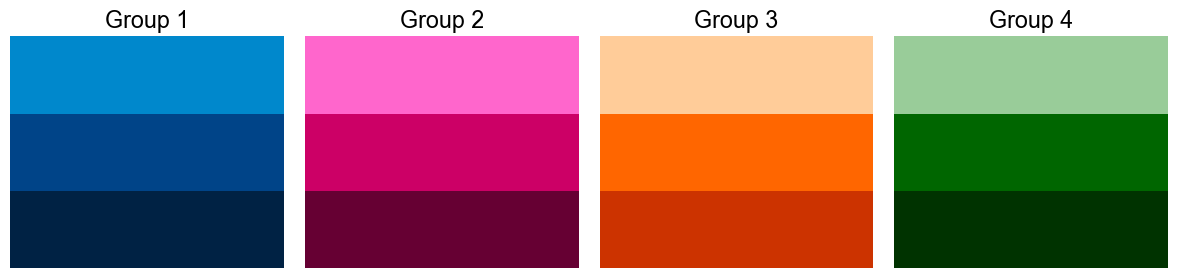

In [162]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

colors = {
    'Group 1': ['#002244', '#004488', '#0088CC'],  # Even Deeper Blues
    'Group 2': ['#660033', '#CC0066', '#FF66CC'],  # Even Deeper Purples to Light Pinks
    'Group 3': ['#CC3300', '#FF6600', '#FFCC99'],  # Even Deeper Oranges to Pale Oranges
    'Group 4': ['#003300', '#006600', '#99CC99']   # Even Deeper Greens
}

# Create figure
fig, axs = plt.subplots(1, 4, figsize=(12, 3))

# Plot each color group
for i, (group, shades) in enumerate(colors.items()):
    for j, color in enumerate(shades):
        rect = patches.Rectangle((0, j), 1, 1, facecolor=color)
        axs[i].add_patch(rect)
    axs[i].set_xlim(0, 1)
    axs[i].set_ylim(0, 3)
    axs[i].set_title(group)
    axs[i].axis('off')

plt.tight_layout()
plt.show()

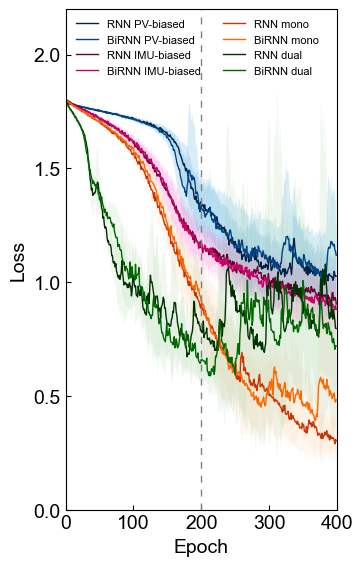

In [181]:
fig = plt.figure(figsize=[3.5, 6.5])
ax = fig.add_subplot()

ax.plot(train_losses_rnn_pv_biased_mean, linewidth=1, c=colors['Group 1'][0], label='RNN PV-biased')
ax.fill_between(np.arange(0, num_epochs),
                train_losses_rnn_pv_biased_mean - train_losses_rnn_pv_biased_std,
                train_losses_rnn_pv_biased_mean + train_losses_rnn_pv_biased_std,
                color=colors['Group 1'][2], alpha=0.15, ec='None')

ax.plot(train_losses_rnn_pv_biased_bi_mean, linewidth=1, c=colors['Group 1'][1], label='BiRNN PV-biased')
ax.fill_between(np.arange(0, num_epochs),
                train_losses_rnn_pv_biased_bi_mean - train_losses_rnn_pv_biased_bi_std,
                train_losses_rnn_pv_biased_bi_mean + train_losses_rnn_pv_biased_bi_std,
                color=colors['Group 1'][2], alpha=0.15, ec='None')

ax.plot(train_losses_rnn_imu_biased_mean, linewidth=1, c=colors['Group 2'][0], label='RNN IMU-biased')
ax.fill_between(np.arange(0, num_epochs),
                train_losses_rnn_imu_biased_mean - train_losses_rnn_imu_biased_std,
                train_losses_rnn_imu_biased_mean + train_losses_rnn_imu_biased_std,
                color=colors['Group 2'][2], alpha=0.15, ec='None')

ax.plot(train_losses_rnn_imu_biased_bi_mean, linewidth=1, c=colors['Group 2'][1], label='BiRNN IMU-biased')
ax.fill_between(np.arange(0, num_epochs),
                train_losses_rnn_imu_biased_bi_mean - train_losses_rnn_imu_biased_bi_std,
                train_losses_rnn_imu_biased_bi_mean + train_losses_rnn_imu_biased_bi_std,
                color=colors['Group 2'][2], alpha=0.15, ec='None')

ax.plot(train_losses_rnn_mono_mean, linewidth=1, c=colors['Group 3'][0], label='RNN mono')
ax.fill_between(np.arange(0, num_epochs),
                train_losses_rnn_mono_mean - train_losses_rnn_mono_std,
                train_losses_rnn_mono_mean + train_losses_rnn_mono_std,
                color=colors['Group 3'][2], alpha=0.15, ec='None')

ax.plot(train_losses_rnn_mono_bi_mean, linewidth=1, c=colors['Group 3'][1], label='BiRNN mono')
ax.fill_between(np.arange(0, num_epochs),
                train_losses_rnn_mono_bi_mean - train_losses_rnn_mono_bi_std,
                train_losses_rnn_mono_bi_mean + train_losses_rnn_mono_bi_std,
                color=colors['Group 3'][2], alpha=0.15, ec='None')

ax.plot(train_losses_rnn_dual_mean, linewidth=1, c=colors['Group 4'][0], label='RNN dual')
ax.fill_between(np.arange(0, num_epochs),
                train_losses_rnn_dual_mean - train_losses_rnn_dual_std,
                train_losses_rnn_dual_mean + train_losses_rnn_dual_std,
                color=colors['Group 4'][2], alpha=0.15, ec='None')

ax.plot(train_losses_rnn_dual_bi_mean, linewidth=1, c=colors['Group 4'][1], label='BiRNN dual')
ax.fill_between(np.arange(0, num_epochs),
                train_losses_rnn_dual_bi_mean - train_losses_rnn_dual_bi_std,
                train_losses_rnn_dual_bi_mean + train_losses_rnn_dual_bi_std,
                color=colors['Group 4'][2], alpha=0.15, ec='None')

ax.vlines(200, 0, 2.5,
          linewidth=1,
          linestyles=(0, (5, 5)),
          colors='gray')

ax.set_xlim(0, num_epochs)
ax.set_ylim(0, 2.2)
ax.set_yticks(np.arange(0, 2.5, 0.5))
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.tick_params(which='both', direction='in')
ax.legend(bbox_to_anchor=(0, 1), loc='upper left',
          fontsize=8, frameon=False, ncols=2)

# plt.savefig('../results/fig3/loss_all.png', dpi=600, bbox_inches='tight')
plt.show()

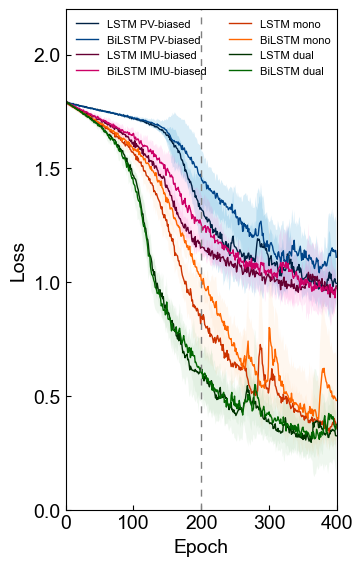

In [183]:
fig = plt.figure(figsize=[3.5, 6.5])
ax = fig.add_subplot()

# Plot for LSTM pv_biased
ax.plot(train_losses_lstm_pv_biased_mean, linewidth=1, c=colors['Group 1'][0], label='LSTM PV-biased')
ax.fill_between(np.arange(0, num_epochs),
                train_losses_lstm_pv_biased_mean - train_losses_lstm_pv_biased_std,
                train_losses_lstm_pv_biased_mean + train_losses_lstm_pv_biased_std,
                color=colors['Group 1'][2], alpha=0.15, ec='None')

# Plot for LSTM pv_biased_bi
ax.plot(train_losses_lstm_pv_biased_bi_mean, linewidth=1, c=colors['Group 1'][1], label='BiLSTM PV-biased')
ax.fill_between(np.arange(0, num_epochs),
                train_losses_lstm_pv_biased_bi_mean - train_losses_lstm_pv_biased_bi_std,
                train_losses_lstm_pv_biased_bi_mean + train_losses_lstm_pv_biased_bi_std,
                color=colors['Group 1'][2], alpha=0.15, ec='None')

# Plot for LSTM imu_biased
ax.plot(train_losses_lstm_imu_biased_mean, linewidth=1, c=colors['Group 2'][0], label='LSTM IMU-biased')
ax.fill_between(np.arange(0, num_epochs),
                train_losses_lstm_imu_biased_mean - train_losses_lstm_imu_biased_std,
                train_losses_lstm_imu_biased_mean + train_losses_lstm_imu_biased_std,
                color=colors['Group 2'][2], alpha=0.15, ec='None')

# Plot for LSTM imu_biased_bi
ax.plot(train_losses_lstm_imu_biased_bi_mean, linewidth=1, c=colors['Group 2'][1], label='BiLSTM IMU-biased')
ax.fill_between(np.arange(0, num_epochs),
                train_losses_lstm_imu_biased_bi_mean - train_losses_lstm_imu_biased_bi_std,
                train_losses_lstm_imu_biased_bi_mean + train_losses_lstm_imu_biased_bi_std,
                color=colors['Group 2'][2], alpha=0.15, ec='None')

# Plot for LSTM mono
ax.plot(train_losses_lstm_mono_mean, linewidth=1, c=colors['Group 3'][0], label='LSTM mono')
ax.fill_between(np.arange(0, num_epochs),
                train_losses_lstm_mono_mean - train_losses_lstm_mono_std,
                train_losses_lstm_mono_mean + train_losses_lstm_mono_std,
                color=colors['Group 3'][2], alpha=0.15, ec='None')

# Plot for LSTM mono_bi
ax.plot(train_losses_lstm_mono_bi_mean, linewidth=1, c=colors['Group 3'][1], label='BiLSTM mono')
ax.fill_between(np.arange(0, num_epochs),
                train_losses_lstm_mono_bi_mean - train_losses_lstm_mono_bi_std,
                train_losses_lstm_mono_bi_mean + train_losses_lstm_mono_bi_std,
                color=colors['Group 3'][2], alpha=0.15, ec='None')

# Plot for LSTM dual
ax.plot(train_losses_lstm_dual_mean, linewidth=1, c=colors['Group 4'][0], label='LSTM dual')
ax.fill_between(np.arange(0, num_epochs),
                train_losses_lstm_dual_mean - train_losses_lstm_dual_std,
                train_losses_lstm_dual_mean + train_losses_lstm_dual_std,
                color=colors['Group 4'][2], alpha=0.15, ec='None')

# Plot for LSTM dual_bi
ax.plot(train_losses_lstm_dual_bi_mean, linewidth=1, c=colors['Group 4'][1], label='BiLSTM dual')
ax.fill_between(np.arange(0, num_epochs),
                train_losses_lstm_dual_bi_mean - train_losses_lstm_dual_bi_std,
                train_losses_lstm_dual_bi_mean + train_losses_lstm_dual_bi_std,
                color=colors['Group 4'][2], alpha=0.15, ec='None')

ax.vlines(200, 0, 2.5, linewidth=1, linestyles=(0, (5, 5)), colors='gray')

ax.set_xlim(0, num_epochs)
ax.set_ylim(0, 2.2)
ax.set_yticks(np.arange(0, 2.5, 0.5))
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.tick_params(which='both', direction='in')
ax.legend(bbox_to_anchor=(0, 1), loc='upper left',
          fontsize=8, frameon=False, ncols=2)

# plt.savefig('../results/fig3/loss_all.png', dpi=600, bbox_inches='tight')
plt.show()

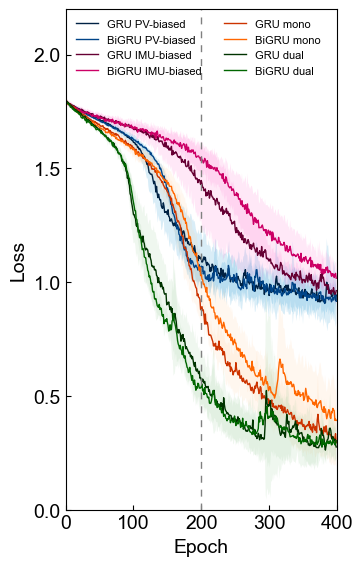

In [184]:
fig = plt.figure(figsize=[3.5, 6.5])
ax = fig.add_subplot()

# Plot for GRU pv_biased
ax.plot(train_losses_gru_pv_biased_mean, linewidth=1, c=colors['Group 1'][0], label='GRU PV-biased')
ax.fill_between(np.arange(0, num_epochs),
                train_losses_gru_pv_biased_mean - train_losses_gru_pv_biased_std,
                train_losses_gru_pv_biased_mean + train_losses_gru_pv_biased_std,
                color=colors['Group 1'][2], alpha=0.15, ec='None')

# Plot for GRU pv_biased_bi
ax.plot(train_losses_gru_pv_biased_bi_mean, linewidth=1, c=colors['Group 1'][1], label='BiGRU PV-biased')
ax.fill_between(np.arange(0, num_epochs),
                train_losses_gru_pv_biased_bi_mean - train_losses_gru_pv_biased_bi_std,
                train_losses_gru_pv_biased_bi_mean + train_losses_gru_pv_biased_bi_std,
                color=colors['Group 1'][2], alpha=0.15, ec='None')

# Plot for GRU imu_biased
ax.plot(train_losses_gru_imu_biased_mean, linewidth=1, c=colors['Group 2'][0], label='GRU IMU-biased')
ax.fill_between(np.arange(0, num_epochs),
                train_losses_gru_imu_biased_mean - train_losses_gru_imu_biased_std,
                train_losses_gru_imu_biased_mean + train_losses_gru_imu_biased_std,
                color=colors['Group 2'][2], alpha=0.15, ec='None')

# Plot for GRU imu_biased_bi
ax.plot(train_losses_gru_imu_biased_bi_mean, linewidth=1, c=colors['Group 2'][1], label='BiGRU IMU-biased')
ax.fill_between(np.arange(0, num_epochs),
                train_losses_gru_imu_biased_bi_mean - train_losses_gru_imu_biased_bi_std,
                train_losses_gru_imu_biased_bi_mean + train_losses_gru_imu_biased_bi_std,
                color=colors['Group 2'][2], alpha=0.15, ec='None')

# Plot for GRU mono
ax.plot(train_losses_gru_mono_mean, linewidth=1, c=colors['Group 3'][0], label='GRU mono')
ax.fill_between(np.arange(0, num_epochs),
                train_losses_gru_mono_mean - train_losses_gru_mono_std,
                train_losses_gru_mono_mean + train_losses_gru_mono_std,
                color=colors['Group 3'][2], alpha=0.15, ec='None')

# Plot for GRU mono_bi
ax.plot(train_losses_gru_mono_bi_mean, linewidth=1, c=colors['Group 3'][1], label='BiGRU mono')
ax.fill_between(np.arange(0, num_epochs),
                train_losses_gru_mono_bi_mean - train_losses_gru_mono_bi_std,
                train_losses_gru_mono_bi_mean + train_losses_gru_mono_bi_std,
                color=colors['Group 3'][2], alpha=0.15, ec='None')

# Plot for GRU dual
ax.plot(train_losses_gru_dual_mean, linewidth=1, c=colors['Group 4'][0], label='GRU dual')
ax.fill_between(np.arange(0, num_epochs),
                train_losses_gru_dual_mean - train_losses_gru_dual_std,
                train_losses_gru_dual_mean + train_losses_gru_dual_std,
                color=colors['Group 4'][2], alpha=0.15, ec='None')

# Plot for GRU dual_bi
ax.plot(train_losses_gru_dual_bi_mean, linewidth=1, c=colors['Group 4'][1], label='BiGRU dual')
ax.fill_between(np.arange(0, num_epochs),
                train_losses_gru_dual_bi_mean - train_losses_gru_dual_bi_std,
                train_losses_gru_dual_bi_mean + train_losses_gru_dual_bi_std,
                color=colors['Group 4'][2], alpha=0.15, ec='None')

ax.vlines(200, 0, 2.5, linewidth=1, linestyles=(0, (5, 5)), colors='gray')

ax.set_xlim(0, num_epochs)
ax.set_ylim(0, 2.2)
ax.set_yticks(np.arange(0, 2.5, 0.5))
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.tick_params(which='both', direction='in')
ax.legend(bbox_to_anchor=(0, 1), loc='upper left',
          fontsize=8, frameon=False, ncols=2)

# plt.savefig('../results/fig3/loss_all.png', dpi=600, bbox_inches='tight')
plt.show()

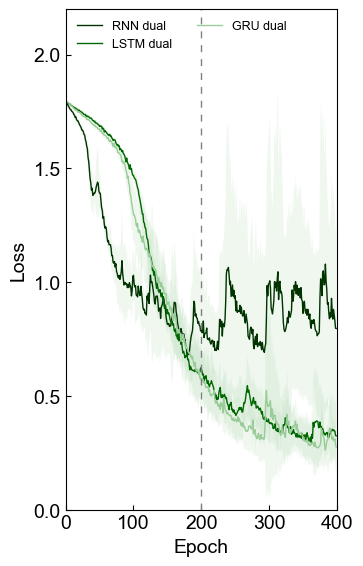

In [185]:
fig = plt.figure(figsize=[3.5, 6.5])
ax = fig.add_subplot()

ax.plot(train_losses_rnn_dual_mean, linewidth=1, c=colors['Group 4'][0], label='RNN dual')
ax.fill_between(np.arange(0, num_epochs),
                train_losses_rnn_dual_mean - train_losses_rnn_dual_std,
                train_losses_rnn_dual_mean + train_losses_rnn_dual_std,
                color=colors['Group 4'][2], alpha=0.15, ec='None')

ax.plot(train_losses_lstm_dual_mean, linewidth=1, c=colors['Group 4'][1], label='LSTM dual')
ax.fill_between(np.arange(0, num_epochs),
                train_losses_lstm_dual_mean - train_losses_lstm_dual_std,
                train_losses_lstm_dual_mean + train_losses_lstm_dual_std,
                color=colors['Group 4'][2], alpha=0.15, ec='None')

ax.plot(train_losses_gru_dual_mean, linewidth=1, c=colors['Group 4'][2], label='GRU dual')
ax.fill_between(np.arange(0, num_epochs),
                train_losses_gru_dual_mean - train_losses_gru_dual_std,
                train_losses_gru_dual_mean + train_losses_gru_dual_std,
                color=colors['Group 4'][2], alpha=0.15, ec='None')

ax.vlines(200, 0, 2.5,
          linewidth=1,
          linestyles=(0, (5, 5)),
          colors='gray')

ax.set_xlim(0, num_epochs)
ax.set_ylim(0, 2.2)
ax.set_yticks(np.arange(0, 2.5, 0.5))
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.tick_params(which='both', direction='in')
ax.legend(bbox_to_anchor=(0, 1), loc='upper left',
          fontsize=9, frameon=False, ncols=2)

# plt.savefig('../results/fig3/loss_all.png', dpi=600, bbox_inches='tight')
plt.show()

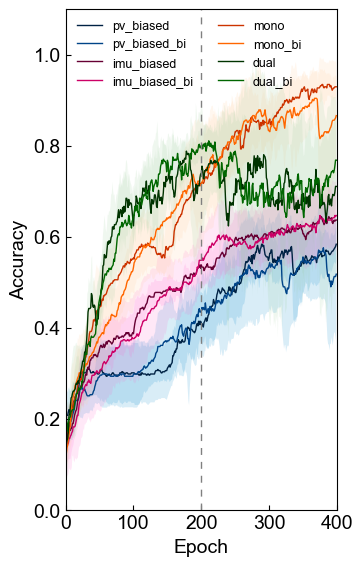

In [169]:
fig = plt.figure(figsize=[3.5, 6.5])
ax = fig.add_subplot()

# Adding 'rnn' to variable names for accuracies plots
ax.plot(train_accuracies_rnn_pv_biased_mean, linewidth=1, c=colors['Group 1'][0], label='pv_biased')
ax.fill_between(np.arange(0, num_epochs),
                train_accuracies_rnn_pv_biased_mean - train_accuracies_rnn_pv_biased_std,
                train_accuracies_rnn_pv_biased_mean + train_accuracies_rnn_pv_biased_std,
                color=colors['Group 1'][2], alpha=0.15, ec='None')

ax.plot(train_accuracies_rnn_pv_biased_bi_mean, linewidth=1, c=colors['Group 1'][1], label='pv_biased_bi')
ax.fill_between(np.arange(0, num_epochs),
                train_accuracies_rnn_pv_biased_bi_mean - train_accuracies_rnn_pv_biased_bi_std,
                train_accuracies_rnn_pv_biased_bi_mean + train_accuracies_rnn_pv_biased_bi_std,
                color=colors['Group 1'][2], alpha=0.15, ec='None')

ax.plot(train_accuracies_rnn_imu_biased_mean, linewidth=1, c=colors['Group 2'][0], label='imu_biased')
ax.fill_between(np.arange(0, num_epochs),
                train_accuracies_rnn_imu_biased_mean - train_accuracies_rnn_imu_biased_std,
                train_accuracies_rnn_imu_biased_mean + train_accuracies_rnn_imu_biased_std,
                color=colors['Group 2'][2], alpha=0.15, ec='None')

ax.plot(train_accuracies_rnn_imu_biased_bi_mean, linewidth=1, c=colors['Group 2'][1], label='imu_biased_bi')
ax.fill_between(np.arange(0, num_epochs),
                train_accuracies_rnn_imu_biased_bi_mean - train_accuracies_rnn_imu_biased_bi_std,
                train_accuracies_rnn_imu_biased_bi_mean + train_accuracies_rnn_imu_biased_bi_std,
                color=colors['Group 2'][2], alpha=0.15, ec='None')

ax.plot(train_accuracies_rnn_mono_mean, linewidth=1, c=colors['Group 3'][0], label='mono')
ax.fill_between(np.arange(0, num_epochs),
                train_accuracies_rnn_mono_mean - train_accuracies_rnn_mono_std,
                train_accuracies_rnn_mono_mean + train_accuracies_rnn_mono_std,
                color=colors['Group 3'][2], alpha=0.15, ec='None')

ax.plot(train_accuracies_rnn_mono_bi_mean, linewidth=1, c=colors['Group 3'][1], label='mono_bi')
ax.fill_between(np.arange(0, num_epochs),
                train_accuracies_rnn_mono_bi_mean - train_accuracies_rnn_mono_bi_std,
                train_accuracies_rnn_mono_bi_mean + train_accuracies_rnn_mono_bi_std,
                color=colors['Group 3'][2], alpha=0.15, ec='None')

ax.plot(train_accuracies_rnn_dual_mean, linewidth=1, c=colors['Group 4'][0], label='dual')
ax.fill_between(np.arange(0, num_epochs),
                train_accuracies_rnn_dual_mean - train_accuracies_rnn_dual_std,
                train_accuracies_rnn_dual_mean + train_accuracies_rnn_dual_std,
                color=colors['Group 4'][2], alpha=0.15, ec='None')

ax.plot(train_accuracies_rnn_dual_bi_mean, linewidth=1, c=colors['Group 4'][1], label='dual_bi')
ax.fill_between(np.arange(0, num_epochs),
                train_accuracies_rnn_dual_bi_mean - train_accuracies_rnn_dual_bi_std,
                train_accuracies_rnn_dual_bi_mean + train_accuracies_rnn_dual_bi_std,
                color=colors['Group 4'][2], alpha=0.15, ec='None')

ax.vlines(200, 0, 1.1, linewidth=1, linestyles=(0, (5, 5)), colors='gray')

ax.set_xlim(0, num_epochs)
ax.set_ylim(0, 1.1)
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.tick_params(which='both', direction='in')
ax.legend(bbox_to_anchor=(0, 1), loc='upper left', fontsize=9, frameon=False, ncols=2)

plt.show()


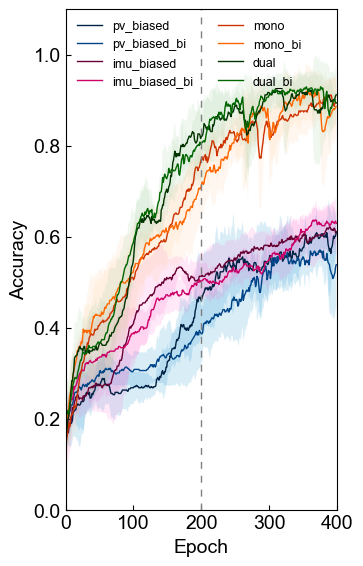

In [170]:
fig = plt.figure(figsize=[3.5, 6.5])
ax = fig.add_subplot()

# Adding 'lstm' to variable names for accuracies plots
ax.plot(train_accuracies_lstm_pv_biased_mean, linewidth=1, c=colors['Group 1'][0], label='pv_biased')
ax.fill_between(np.arange(0, num_epochs),
                train_accuracies_lstm_pv_biased_mean - train_accuracies_lstm_pv_biased_std,
                train_accuracies_lstm_pv_biased_mean + train_accuracies_lstm_pv_biased_std,
                color=colors['Group 1'][2], alpha=0.15, ec='None')

ax.plot(train_accuracies_lstm_pv_biased_bi_mean, linewidth=1, c=colors['Group 1'][1], label='pv_biased_bi')
ax.fill_between(np.arange(0, num_epochs),
                train_accuracies_lstm_pv_biased_bi_mean - train_accuracies_lstm_pv_biased_bi_std,
                train_accuracies_lstm_pv_biased_bi_mean + train_accuracies_lstm_pv_biased_bi_std,
                color=colors['Group 1'][2], alpha=0.15, ec='None')

ax.plot(train_accuracies_lstm_imu_biased_mean, linewidth=1, c=colors['Group 2'][0], label='imu_biased')
ax.fill_between(np.arange(0, num_epochs),
                train_accuracies_lstm_imu_biased_mean - train_accuracies_lstm_imu_biased_std,
                train_accuracies_lstm_imu_biased_mean + train_accuracies_lstm_imu_biased_std,
                color=colors['Group 2'][2], alpha=0.15, ec='None')

ax.plot(train_accuracies_lstm_imu_biased_bi_mean, linewidth=1, c=colors['Group 2'][1], label='imu_biased_bi')
ax.fill_between(np.arange(0, num_epochs),
                train_accuracies_lstm_imu_biased_bi_mean - train_accuracies_lstm_imu_biased_bi_std,
                train_accuracies_lstm_imu_biased_bi_mean + train_accuracies_lstm_imu_biased_bi_std,
                color=colors['Group 2'][2], alpha=0.15, ec='None')

ax.plot(train_accuracies_lstm_mono_mean, linewidth=1, c=colors['Group 3'][0], label='mono')
ax.fill_between(np.arange(0, num_epochs),
                train_accuracies_lstm_mono_mean - train_accuracies_lstm_mono_std,
                train_accuracies_lstm_mono_mean + train_accuracies_lstm_mono_std,
                color=colors['Group 3'][2], alpha=0.15, ec='None')

ax.plot(train_accuracies_lstm_mono_bi_mean, linewidth=1, c=colors['Group 3'][1], label='mono_bi')
ax.fill_between(np.arange(0, num_epochs),
                train_accuracies_lstm_mono_bi_mean - train_accuracies_lstm_mono_bi_std,
                train_accuracies_lstm_mono_bi_mean + train_accuracies_lstm_mono_bi_std,
                color=colors['Group 3'][2], alpha=0.15, ec='None')

ax.plot(train_accuracies_lstm_dual_mean, linewidth=1, c=colors['Group 4'][0], label='dual')
ax.fill_between(np.arange(0, num_epochs),
                train_accuracies_lstm_dual_mean - train_accuracies_lstm_dual_std,
                train_accuracies_lstm_dual_mean + train_accuracies_lstm_dual_std,
                color=colors['Group 4'][2], alpha=0.15, ec='None')

ax.plot(train_accuracies_lstm_dual_bi_mean, linewidth=1, c=colors['Group 4'][1], label='dual_bi')
ax.fill_between(np.arange(0, num_epochs),
                train_accuracies_lstm_dual_bi_mean - train_accuracies_lstm_dual_bi_std,
                train_accuracies_lstm_dual_bi_mean + train_accuracies_lstm_dual_bi_std,
                color=colors['Group 4'][2], alpha=0.15, ec='None')

ax.vlines(200, 0, 1.1, linewidth=1, linestyles=(0, (5, 5)), colors='gray')

ax.set_xlim(0, num_epochs)
ax.set_ylim(0, 1.1)
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.tick_params(which='both', direction='in')
ax.legend(bbox_to_anchor=(0, 1), loc='upper left', fontsize=9, frameon=False, ncols=2)

# plt.savefig('../results/fig3/accuracy_all.png', dpi=600, bbox_inches='tight')
plt.show()

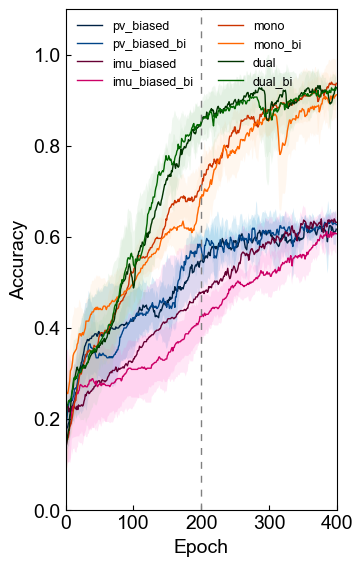

In [171]:
fig = plt.figure(figsize=[3.5, 6.5])
ax = fig.add_subplot()

# Adding 'gru' to variable names for accuracies plots
ax.plot(train_accuracies_gru_pv_biased_mean, linewidth=1, c=colors['Group 1'][0], label='pv_biased')
ax.fill_between(np.arange(0, num_epochs),
                train_accuracies_gru_pv_biased_mean - train_accuracies_gru_pv_biased_std,
                train_accuracies_gru_pv_biased_mean + train_accuracies_gru_pv_biased_std,
                color=colors['Group 1'][2], alpha=0.15, ec='None')

ax.plot(train_accuracies_gru_pv_biased_bi_mean, linewidth=1, c=colors['Group 1'][1], label='pv_biased_bi')
ax.fill_between(np.arange(0, num_epochs),
                train_accuracies_gru_pv_biased_bi_mean - train_accuracies_gru_pv_biased_bi_std,
                train_accuracies_gru_pv_biased_bi_mean + train_accuracies_gru_pv_biased_bi_std,
                color=colors['Group 1'][2], alpha=0.15, ec='None')

ax.plot(train_accuracies_gru_imu_biased_mean, linewidth=1, c=colors['Group 2'][0], label='imu_biased')
ax.fill_between(np.arange(0, num_epochs),
                train_accuracies_gru_imu_biased_mean - train_accuracies_gru_imu_biased_std,
                train_accuracies_gru_imu_biased_mean + train_accuracies_gru_imu_biased_std,
                color=colors['Group 2'][2], alpha=0.15, ec='None')

ax.plot(train_accuracies_gru_imu_biased_bi_mean, linewidth=1, c=colors['Group 2'][1], label='imu_biased_bi')
ax.fill_between(np.arange(0, num_epochs),
                train_accuracies_gru_imu_biased_bi_mean - train_accuracies_gru_imu_biased_bi_std,
                train_accuracies_gru_imu_biased_bi_mean + train_accuracies_gru_imu_biased_bi_std,
                color=colors['Group 2'][2], alpha=0.15, ec='None')

ax.plot(train_accuracies_gru_mono_mean, linewidth=1, c=colors['Group 3'][0], label='mono')
ax.fill_between(np.arange(0, num_epochs),
                train_accuracies_gru_mono_mean - train_accuracies_gru_mono_std,
                train_accuracies_gru_mono_mean + train_accuracies_gru_mono_std,
                color=colors['Group 3'][2], alpha=0.15, ec='None')

ax.plot(train_accuracies_gru_mono_bi_mean, linewidth=1, c=colors['Group 3'][1], label='mono_bi')
ax.fill_between(np.arange(0, num_epochs),
                train_accuracies_gru_mono_bi_mean - train_accuracies_gru_mono_bi_std,
                train_accuracies_gru_mono_bi_mean + train_accuracies_gru_mono_bi_std,
                color=colors['Group 3'][2], alpha=0.15, ec='None')

ax.plot(train_accuracies_gru_dual_mean, linewidth=1, c=colors['Group 4'][0], label='dual')
ax.fill_between(np.arange(0, num_epochs),
                train_accuracies_gru_dual_mean - train_accuracies_gru_dual_std,
                train_accuracies_gru_dual_mean + train_accuracies_gru_dual_std,
                color=colors['Group 4'][2], alpha=0.15, ec='None')

ax.plot(train_accuracies_gru_dual_bi_mean, linewidth=1, c=colors['Group 4'][1], label='dual_bi')
ax.fill_between(np.arange(0, num_epochs),
                train_accuracies_gru_dual_bi_mean - train_accuracies_gru_dual_bi_std,
                train_accuracies_gru_dual_bi_mean + train_accuracies_gru_dual_bi_std,
                color=colors['Group 4'][2], alpha=0.15, ec='None')

ax.vlines(200, 0, 1.1, linewidth=1, linestyles=(0, (5, 5)), colors='gray')

ax.set_xlim(0, num_epochs)
ax.set_ylim(0, 1.1)
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.tick_params(which='both', direction='in')
ax.legend(bbox_to_anchor=(0, 1), loc='upper left', fontsize=9, frameon=False, ncols=2)

plt.show()

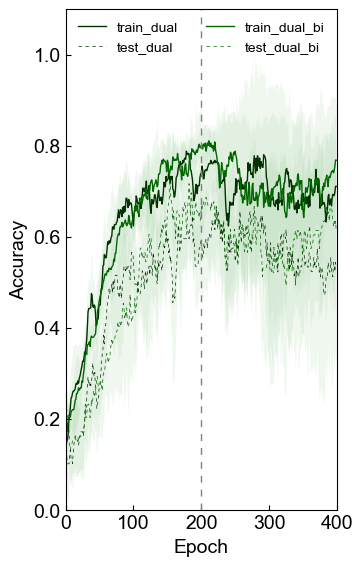

In [175]:
fig = plt.figure(figsize=[3.5, 6.5])
ax = fig.add_subplot()

ax.plot(train_accuracies_rnn_dual_mean, linewidth=1, c=colors['Group 4'][0], label='train_dual')
ax.fill_between(np.arange(0, num_epochs),
                train_accuracies_rnn_dual_mean - train_accuracies_rnn_dual_std,
                train_accuracies_rnn_dual_mean + train_accuracies_rnn_dual_std,
                color=colors['Group 4'][2], alpha=0.15, ec='None')
ax.plot(test_accuracies_rnn_dual_mean, linewidth=0.5, c=colors['Group 4'][0], ls=(0, (5, 5)), label='test_dual')
ax.fill_between(np.arange(0, num_epochs),
                test_accuracies_rnn_dual_mean - test_accuracies_rnn_dual_std,
                test_accuracies_rnn_dual_mean + test_accuracies_rnn_dual_std,
                color=colors['Group 4'][2], alpha=0.15, ec='None')
ax.plot(train_accuracies_rnn_dual_bi_mean, linewidth=1, c=colors['Group 4'][1], label='train_dual_bi')
ax.fill_between(np.arange(0, num_epochs),
                train_accuracies_rnn_dual_bi_mean - train_accuracies_rnn_dual_bi_std,
                train_accuracies_rnn_dual_bi_mean + train_accuracies_rnn_dual_bi_std,
                color=colors['Group 4'][2], alpha=0.15, ec='None')
ax.plot(test_accuracies_rnn_dual_bi_mean, linewidth=0.5, c=colors['Group 4'][1], ls=(0, (5, 5)), label='test_dual_bi')
ax.fill_between(np.arange(0, num_epochs),
                test_accuracies_rnn_dual_bi_mean - test_accuracies_rnn_dual_bi_std,
                test_accuracies_rnn_dual_bi_mean + test_accuracies_rnn_dual_bi_std,
                color=colors['Group 4'][2], alpha=0.15, ec='None')

ax.vlines(200, 0, 1.1, linewidth=1, linestyles=(0, (5, 5)), colors='gray')

ax.set_xlim(0, num_epochs)
ax.set_ylim(0, 1.1)
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.tick_params(which='both', direction='in')
ax.legend(bbox_to_anchor=(0, 1), loc='upper left', fontsize=10, frameon=False, ncols=2)

plt.show()


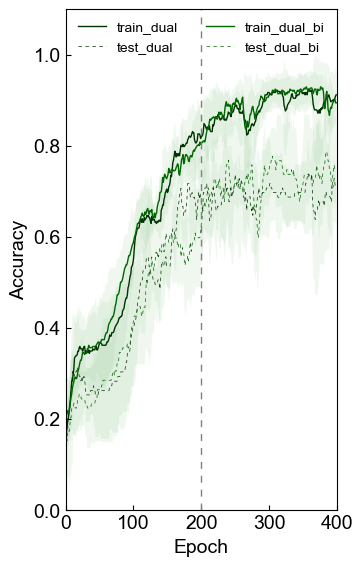

In [176]:
fig = plt.figure(figsize=[3.5, 6.5])
ax = fig.add_subplot()

ax.plot(train_accuracies_lstm_dual_mean, linewidth=1, c=colors['Group 4'][0], label='train_dual')
ax.fill_between(np.arange(0, num_epochs),
                train_accuracies_lstm_dual_mean - train_accuracies_lstm_dual_std,
                train_accuracies_lstm_dual_mean + train_accuracies_lstm_dual_std,
                color=colors['Group 4'][2], alpha=0.15, ec='None')
ax.plot(test_accuracies_lstm_dual_mean, linewidth=0.5, c=colors['Group 4'][0], ls=(0, (5, 5)), label='test_dual')
ax.fill_between(np.arange(0, num_epochs),
                test_accuracies_lstm_dual_mean - test_accuracies_lstm_dual_std,
                test_accuracies_lstm_dual_mean + test_accuracies_lstm_dual_std,
                color=colors['Group 4'][2], alpha=0.15, ec='None')
ax.plot(train_accuracies_lstm_dual_bi_mean, linewidth=1, c=colors['Group 4'][1], label='train_dual_bi')
ax.fill_between(np.arange(0, num_epochs),
                train_accuracies_lstm_dual_bi_mean - train_accuracies_lstm_dual_bi_std,
                train_accuracies_lstm_dual_bi_mean + train_accuracies_lstm_dual_bi_std,
                color=colors['Group 4'][2], alpha=0.15, ec='None')
ax.plot(test_accuracies_lstm_dual_bi_mean, linewidth=0.5, c=colors['Group 4'][1], ls=(0, (5, 5)), label='test_dual_bi')
ax.fill_between(np.arange(0, num_epochs),
                test_accuracies_lstm_dual_bi_mean - test_accuracies_lstm_dual_bi_std,
                test_accuracies_lstm_dual_bi_mean + test_accuracies_lstm_dual_bi_std,
                color=colors['Group 4'][2], alpha=0.15, ec='None')

ax.vlines(200, 0, 1.1, linewidth=1, linestyles=(0, (5, 5)), colors='gray')

ax.set_xlim(0, num_epochs)
ax.set_ylim(0, 1.1)
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.tick_params(which='both', direction='in')
ax.legend(bbox_to_anchor=(0, 1), loc='upper left', fontsize=10, frameon=False, ncols=2)

# plt.savefig('../results/fig3/accuracy_dual.png', dpi=600, bbox_inches='tight')
plt.show()

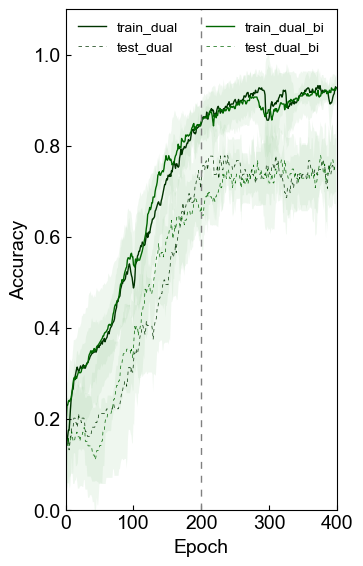

In [177]:
fig = plt.figure(figsize=[3.5, 6.5])
ax = fig.add_subplot()

ax.plot(train_accuracies_gru_dual_mean, linewidth=1, c=colors['Group 4'][0], label='train_dual')
ax.fill_between(np.arange(0, num_epochs),
                train_accuracies_gru_dual_mean - train_accuracies_gru_dual_std,
                train_accuracies_gru_dual_mean + train_accuracies_gru_dual_std,
                color=colors['Group 4'][2], alpha=0.15, ec='None')
ax.plot(test_accuracies_gru_dual_mean, linewidth=0.5, c=colors['Group 4'][0], ls=(0, (5, 5)), label='test_dual')
ax.fill_between(np.arange(0, num_epochs),
                test_accuracies_gru_dual_mean - test_accuracies_gru_dual_std,
                test_accuracies_gru_dual_mean + test_accuracies_gru_dual_std,
                color=colors['Group 4'][2], alpha=0.15, ec='None')
ax.plot(train_accuracies_gru_dual_bi_mean, linewidth=1, c=colors['Group 4'][1], label='train_dual_bi')
ax.fill_between(np.arange(0, num_epochs),
                train_accuracies_gru_dual_bi_mean - train_accuracies_gru_dual_bi_std,
                train_accuracies_gru_dual_bi_mean + train_accuracies_gru_dual_bi_std,
                color=colors['Group 4'][2], alpha=0.15, ec='None')
ax.plot(test_accuracies_gru_dual_bi_mean, linewidth=0.5, c=colors['Group 4'][1], ls=(0, (5, 5)), label='test_dual_bi')
ax.fill_between(np.arange(0, num_epochs),
                test_accuracies_gru_dual_bi_mean - test_accuracies_gru_dual_bi_std,
                test_accuracies_gru_dual_bi_mean + test_accuracies_gru_dual_bi_std,
                color=colors['Group 4'][2], alpha=0.15, ec='None')

ax.vlines(200, 0, 1.1, linewidth=1, linestyles=(0, (5, 5)), colors='gray')

ax.set_xlim(0, num_epochs)
ax.set_ylim(0, 1.1)
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.tick_params(which='both', direction='in')
ax.legend(bbox_to_anchor=(0, 1), loc='upper left', fontsize=10, frameon=False, ncols=2)

plt.show()


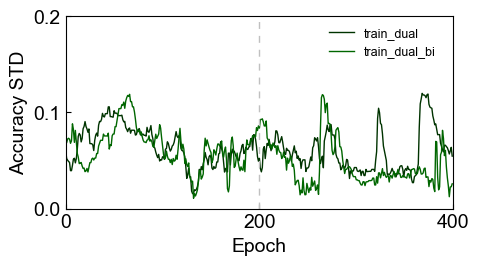

In [179]:
fig = plt.figure(figsize=[5, 2.5])
ax = fig.add_subplot()

ax.plot(train_accuracies_lstm_dual_std, linewidth=1, c=colors['Group 4'][0], label='train_dual')
ax.plot(train_accuracies_lstm_dual_bi_std, linewidth=1, c=colors['Group 4'][1], label='train_dual_bi')

ax.vlines(200, 0, 2,
          linewidth=1,
          linestyles=(0, (5, 5)),
          colors='silver')

ax.set_xlim(0, num_epochs)
ax.set_ylim(0, 0.2)
ax.set_xticks([0, 200, 400])
ax.set_yticks(np.linspace(0, 0.2, 3))
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy STD')
ax.tick_params(which='both', direction='in')
ax.legend(bbox_to_anchor=(0.65, 1), loc='upper left',
          fontsize=9, frameon=False, ncols=1)

# plt.savefig('../results/fig3/accuracy_dual_std_comparison.png', dpi=600, bbox_inches='tight')
plt.show()

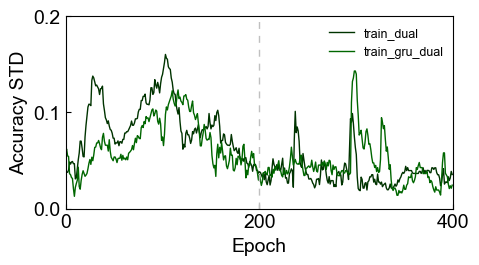

In [116]:
fig = plt.figure(figsize=[5, 2.5])
ax = fig.add_subplot()

ax.plot(train_accuracies_dual_std, linewidth=1, c=colors['Group 4'][0], label='train_dual')
ax.plot(train_accuracies_gru_dual_std, linewidth=1, c=colors['Group 4'][1], label='train_gru_dual')

ax.vlines(200, 0, 2,
          linewidth=1,
          linestyles=(0, (5, 5)),
          colors='silver')

ax.set_xlim(0, num_epochs)
ax.set_ylim(0, 0.2)
ax.set_xticks([0, 200, 400])
ax.set_yticks(np.linspace(0, 0.2, 3))
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy STD')
ax.tick_params(which='both', direction='in')
ax.legend(bbox_to_anchor=(0.65, 1), loc='upper left',
          fontsize=9, frameon=False, ncols=1)

# plt.savefig('../results/fig3/accuracy_dual_std_comparison.png', dpi=600, bbox_inches='tight')
plt.show()

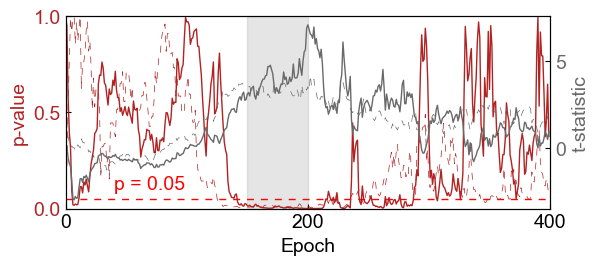

In [47]:
from scipy import stats

t_stat_train = []
p_val_train = []
t_stat_test = []
p_val_test = []

for idx in range(num_epochs):
    t, p = stats.ttest_ind(train_accuracies_lstm_dual[:, idx], train_accuracies_lstm_dual_bi[:, idx])
    t_stat_train.append(t)
    p_val_train.append(p)

    t, p = stats.ttest_ind(test_accuracies_lstm_dual[:, idx], test_accuracies_lstm_dual_bi[:, idx])
    t_stat_test.append(t)
    p_val_test.append(p)

fig, ax1 = plt.subplots(figsize=(6.25, 2.5))

# ax1.vlines(200, 0, 1,
#           linewidth=1,
#           linestyles=(0, (5, 5)),
#           colors='silver')
ax1.axvspan(150, 200, alpha=0.2, color='gray')

ax1.hlines(0.05, 0, num_epochs,
           linewidth=1,
           linestyles=(0, (5, 5)),
           colors='r')
ax1.text(40, 0.08, 'p = 0.05',
         ha='left', va='bottom',
         c='r')

ax1.set_xlim(0, num_epochs)
ax1.set_ylim(0, 1)
ax1.set_xticks([0, 200, 400])
ax1.set_yticks(np.linspace(0, 1, 3))
ax1.plot(p_val_train, lw=1, color='firebrick')
ax1.plot(p_val_test, lw=0.5, ls=(0, (10, 10)), color='firebrick')
ax1.tick_params(axis='x', direction='in')
ax1.tick_params(axis='y', direction='in', labelcolor='firebrick')
ax1.set_ylabel('p-value', color='firebrick')

ax2 = ax1.twinx()
ax2.plot(t_stat_train, lw=1, color='dimgray')
ax2.plot(t_stat_test, lw=0.5, ls=(0, (10, 10)), color='dimgray')
ax2.tick_params(axis='both', direction='in', labelcolor='dimgray')
ax2.set_ylabel('t-statistic', color='dimgray')

ax1.set_xlabel('Epoch')

# plt.savefig('../results/fig3/accuracy_dual_ttest.png', dpi=600, bbox_inches='tight')
plt.show()

In [65]:
model_lstm_dual.eval()

incorrect_train_samples = []
incorrect_test_samples = []

with torch.no_grad():
    for photovoltage_data, euler_angle_data, labels in train_loader_dual:
        photovoltage_data = photovoltage_data.to(device).float()
        euler_angle_data = euler_angle_data.to(device).float()
        labels = labels.to(device)
        
        # Forward pass
        outputs = model_lstm_dual(photovoltage_data, euler_angle_data)
        _, predicted = torch.max(outputs.data, 1)

        mismatches = predicted != labels.squeeze()
        if mismatches.any():
            incorrect_predictions = (photovoltage_data[mismatches],
                                     euler_angle_data[mismatches],
                                     labels[mismatches],
                                     predicted[mismatches])
            incorrect_train_samples.extend(zip(*incorrect_predictions))

with torch.no_grad():
    for photovoltage_data, euler_angle_data, labels in test_loader_dual:
        photovoltage_data = photovoltage_data.to(device).float()
        euler_angle_data = euler_angle_data.to(device).float()
        labels = labels.to(device)
        # Forward pass
        outputs = model_lstm_dual(photovoltage_data, euler_angle_data)
        _, predicted = torch.max(outputs.data, 1)

        mismatches = predicted != labels.squeeze()
        if mismatches.any():
            incorrect_predictions = (photovoltage_data[mismatches],
                                     euler_angle_data[mismatches],
                                     labels[mismatches],
                                     predicted[mismatches])
            incorrect_test_samples.extend(zip(*incorrect_predictions))

incorrect_train_samples = incorrect_train_samples[:5]
incorrect_test_samples = incorrect_test_samples[:5]

In [66]:
def plot_incorrect_samples(samples, title):
    if device != 'cpu':
        samples_cpu = []
        for sample in samples:
            samples_cpu.append([feature.to('cpu') for feature in sample])
        samples = samples_cpu
        
    plt.figure(figsize=(15, 15))
    for i, (photovoltage, euler_angle, true_label, pred_label) in enumerate(samples):
        # Creating a subplot for each sample
        plt.subplot(len(samples), 2, 2*i + 1)  # Photovoltage plot
        plt.plot(photovoltage.numpy())  # Assuming photovoltage is a waveform
        plt.title(f'Sample {i}: True Label = {Label(true_label.item()).name}, Predicted = {Label(pred_label.item()).name}')
        plt.ylabel('Photovoltage')

        plt.subplot(len(samples), 2, 2*i + 2)  # Euler angle plot
        plt.plot(euler_angle.numpy())  # Assuming euler_angle is a waveform
        plt.ylabel('Euler Angles')

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

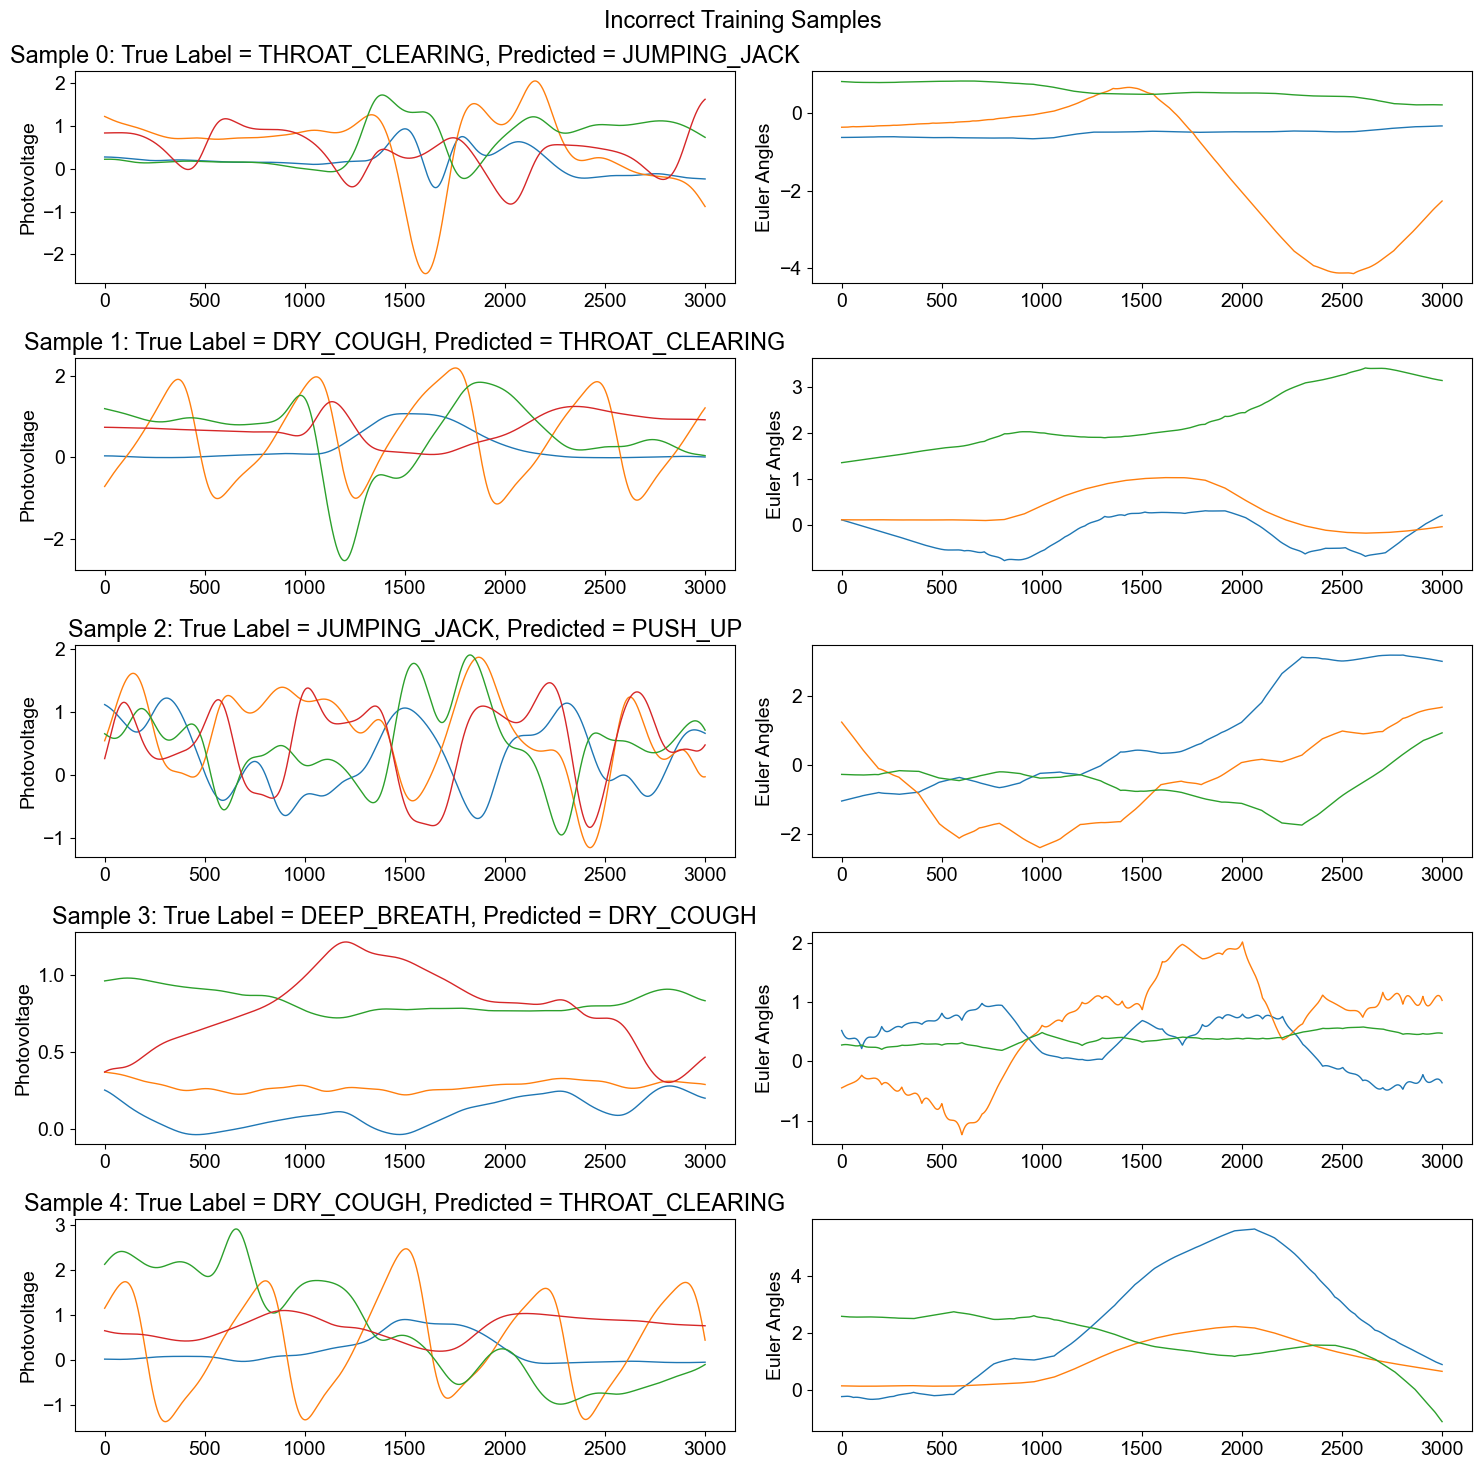

In [67]:
plot_incorrect_samples(incorrect_train_samples, "Incorrect Training Samples")

In [48]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def get_predictions_and_labels(model, loader):
    all_predictions = []
    all_labels = []
    
    model.eval()
    with torch.no_grad():
        for samples, labels in loader:
            samples = samples.to(device)
            labels = labels.to(device)
            outputs = model(samples)
            _, predicted = torch.max(outputs, 1)

            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    return all_predictions, all_labels

def get_predictions_and_labels_dual(model, loader):
    all_predictions = []
    all_labels = []
    
    model.eval()
    with torch.no_grad():
        for pvs, imus, labels in loader:
            pvs = pvs.to(device)
            imus = imus.to(device)
            labels = labels.to(device)
            outputs = model(pvs, imus)
            _, predicted = torch.max(outputs, 1)

            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    return all_predictions, all_labels

c:\Users\y1hli\anaconda3\envs\torch-env\lib\site-packages\torch\nn\modules\rnn.py:812: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,
c:\Users\y1hli\anaconda3\envs\torch-env\lib\site-packages\torch\nn\modules\rnn.py:812: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


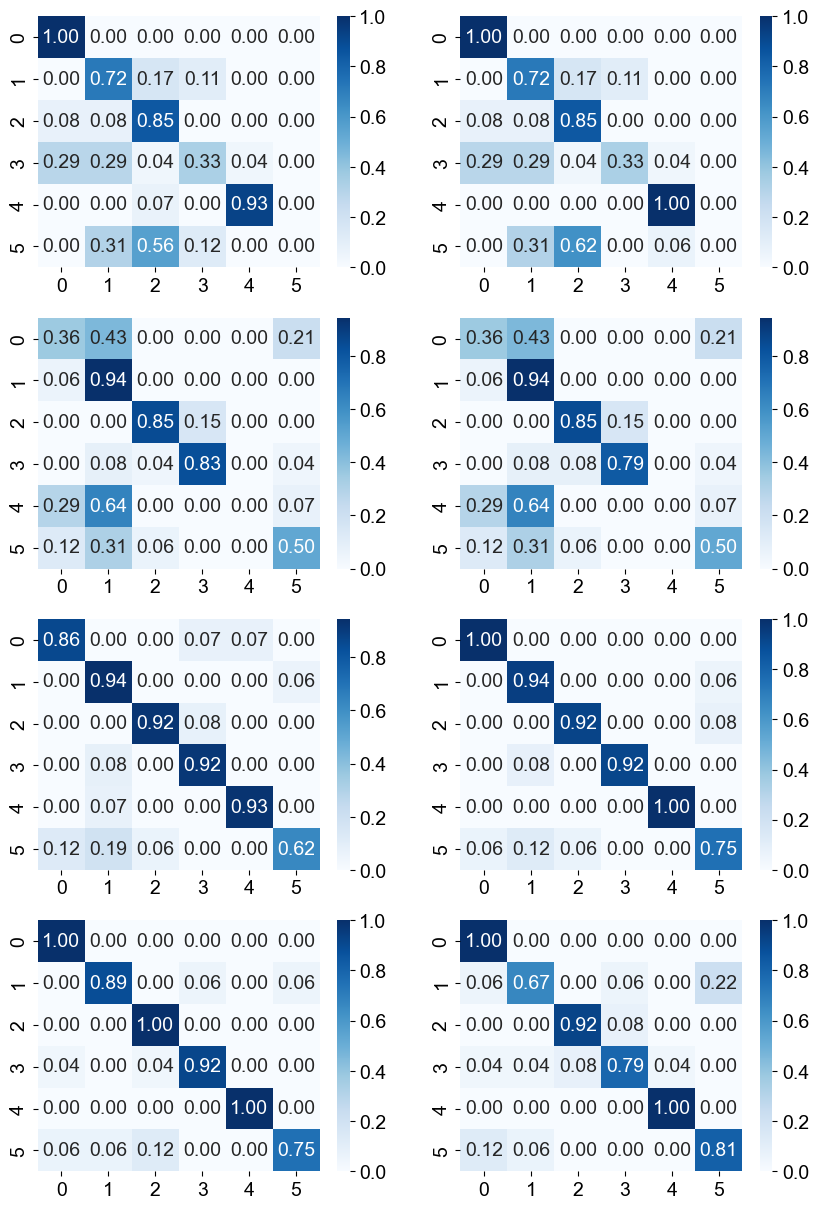

In [83]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(10, 15))

# pv_biased
loader = DataLoader(pv_biased_ds, batch_size=batch_size, shuffle=False)
predictions, labels = get_predictions_and_labels(model_lstm_pv_biased, loader)
cm = confusion_matrix(labels, predictions)
normalized_cm = cm / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(normalized_cm, annot=True, fmt='.2f', cmap='Blues', ax=axes[0, 0])
axes[0, 0].set_title('')

# pv_biased_bi
loader = DataLoader(pv_biased_ds, batch_size=batch_size, shuffle=False)
predictions, labels = get_predictions_and_labels(model_lstm_pv_biased_bi, loader)
cm = confusion_matrix(labels, predictions)
normalized_cm = cm / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(normalized_cm, annot=True, fmt='.2f', cmap='Blues', ax=axes[0, 1])

# imu_biased
loader = DataLoader(imu_biased_ds, batch_size=batch_size, shuffle=False)
predictions, labels = get_predictions_and_labels(model_lstm_imu_biased, loader)
cm = confusion_matrix(labels, predictions)
normalized_cm = cm / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(normalized_cm, annot=True, fmt='.2f', cmap='Blues', ax=axes[1, 0])

# imu_biased_bi
loader = DataLoader(imu_biased_ds, batch_size=batch_size, shuffle=False)
predictions, labels = get_predictions_and_labels(model_lstm_imu_biased_bi, loader)
cm = confusion_matrix(labels, predictions)
normalized_cm = cm / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(normalized_cm, annot=True, fmt='.2f', cmap='Blues', ax=axes[1, 1])

# mono
loader = DataLoader(mono_ds, batch_size=batch_size, shuffle=False)
predictions, labels = get_predictions_and_labels(model_lstm_mono, loader)
cm = confusion_matrix(labels, predictions)
normalized_cm = cm / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(normalized_cm, annot=True, fmt='.2f', cmap='Blues', ax=axes[2, 0])

# mono_bi
loader = DataLoader(mono_ds, batch_size=batch_size, shuffle=False)
predictions, labels = get_predictions_and_labels(model_lstm_mono_bi, loader)
cm = confusion_matrix(labels, predictions)
normalized_cm = cm / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(normalized_cm, annot=True, fmt='.2f', cmap='Blues', ax=axes[2, 1])

# dual
loader = DataLoader(dual_ds, batch_size=batch_size, shuffle=False)
predictions, labels = get_predictions_and_labels_dual(best_model_lstm_dual, loader)
cm = confusion_matrix(labels, predictions)
normalized_cm = cm / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(normalized_cm, annot=True, fmt='.2f', cmap='Blues', ax=axes[3, 0])

# dual_bi
loader = DataLoader(dual_ds, batch_size=batch_size, shuffle=False)
predictions, labels = get_predictions_and_labels_dual(best_model_lstm_dual_bi, loader)
cm = confusion_matrix(labels, predictions)
normalized_cm = cm / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(normalized_cm, annot=True, fmt='.2f', cmap='Blues', ax=axes[3, 1])

plt.show()

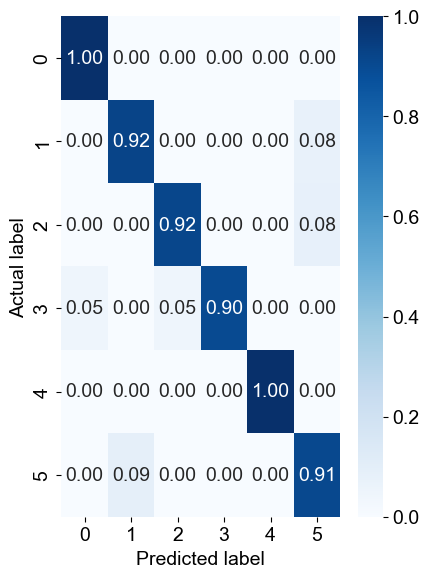

In [68]:
predictions, labels = get_predictions_and_labels_dual(model_lstm_dual, train_loader_dual)
cm = confusion_matrix(labels, predictions)
normalized_cm = cm / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(4.5, 6.5))
sns.heatmap(normalized_cm, annot=True, fmt='.2f', cmap='Blues')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

# plt.savefig('../results/fig3/confusion_matrix_dual.png', dpi=600, bbox_inches='tight')
plt.show()